# WGAN Training

## imports

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WassersteinGenerativeAdversarialNetwork import WassersteinGenerativeAdversarialNetwork as WGAN
from utils.loaders import load_cifar



In [3]:
# run params
SECTION = 'wgan'
RUN_ID = '0004'
DATA_NAME = 'horses'
RUN_FOLDER = f'run/{SECTION}/'
RUN_FOLDER += f'{RUN_ID}_{DATA_NAME}'

for p in ['run', f'run/{SECTION}']:
    if not os.path.exists(p):
        os.mkdir(p)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


## data

In [4]:
if DATA_NAME == 'cars':
    label = 1
elif DATA_NAME == 'horses':
    label = 7
(x_train, y_train) = load_cifar(label, 10)


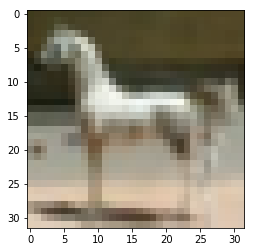

In [5]:
plt.imshow((x_train[150,:,:,:]+1)/2)

## architecture

In [6]:
image_dim = (32,32,3)
latent_dim = 100

generator_initial_dim = (4, 4, 128)

generator_activation = 'leaky_relu'
critic_activation = 'leaky_relu'

critic_learning_rate = 0.00005,
generator_learning_rate = 0.00005,
generator_batch_norm_momentum = 0.8
critic_batch_norm_momentum = None
critic_dense_dim = 0
generator_dropout_rate = None
critic_dropout_rate = None

generator_convolutional_params = [
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 64, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 32, 'kernel_size': (5, 5), 'upsample': 2, },
    {'strides': (1, 1), 'filters': 3, 'kernel_size': (5, 5), 'upsample': 1, },
    ]

critic_convolutional_params = [
    {'strides': (2, 2), 'filters': 32, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 64, 'kernel_size': (5, 5),},
    {'strides': (2, 2), 'filters': 128, 'kernel_size': (5, 5),},
    {'strides': (1, 1), 'filters': 128, 'kernel_size': (5, 5),},
    ]

In [7]:
if mode == 'build':
    gan = WGAN(
        image_dim=image_dim,
        latent_dim=latent_dim,
        generator_initial_dim=generator_initial_dim,
        critic_dense_dim=critic_dense_dim,
        generator_activation=generator_activation,
        critic_activation=critic_activation,
        generator_convolutional_params=generator_convolutional_params,
        critic_learning_rate = critic_learning_rate,
        generator_learning_rate = generator_learning_rate,
        critic_convolutional_params=critic_convolutional_params,
        generator_batch_norm_momentum=generator_batch_norm_momentum,
        critic_batch_norm_momentum=critic_batch_norm_momentum,
        generator_dropout_rate=generator_dropout_rate,
        critic_dropout_rate=critic_dropout_rate,
        )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))








W0608 17:07:57.923156 140685784229632 deprecation.py:506] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
gan.critic_model.summary()

Model: "critic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv2d_0 (Conv2D)     (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv2d_1 (Conv2D)     (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv2d_2 (Conv2D)     (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4, 4, 128)        

In [9]:
gan.generator_model.summary()

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv2d_0 (Conv2D)  (None, 8, 8, 128)     

## training

In [10]:
BATCH_SIZE = 128
EPOCHS = 12000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5 # using double here, because book separates true and generated examples.
CLIP_THRESHOLD = 0.01

In [11]:
gan.train(     
    x_train
    , batch_size=BATCH_SIZE
    , epochs=EPOCHS
    , run_folder=RUN_FOLDER
    , print_every_n_batches=PRINT_EVERY_N_BATCHES
    , critic_training_steps=N_CRITIC
    , clip_threshold=CLIP_THRESHOLD
    , alternating_critic=False
)

W0608 17:08:00.598176 140685784229632 module_wrapper.py:139] From /home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0  disc. loss: (v: -0.000 g: -0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.000 acc.: 0.000


/home/comadan/.venv/gdl/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1  disc. loss: (v: -0.001 g: -0.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.001 acc.: 0.000
epoch: 2  disc. loss: (v: -0.005 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.002 acc.: 0.000
epoch: 3  disc. loss: (v: -0.021 g: -0.001) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.010 acc.: 0.000
epoch: 4  disc. loss: (v: -0.064 g: 0.002) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.039 acc.: 0.000
epoch: 5  disc. loss: (v: -0.180 g: 0.019) acc.: (v: 0.000 g: 0.000)  gen. loss:-0.129 acc.: 0.000
epoch: 6  disc. loss: (v: -0.372 g: 0.056) acc.: (v: 0.164 g: 0.000)  gen. loss:-0.328 acc.: 0.094
epoch: 7  disc. loss: (v: -0.691 g: 0.098) acc.: (v: 0.758 g: 0.000)  gen. loss:-0.707 acc.: 0.828
epoch: 8  disc. loss: (v: -1.083 g: 0.178) acc.: (v: 0.711 g: 0.000)  gen. loss:-1.328 acc.: 0.617
epoch: 9  disc. loss: (v: -1.639 g: 0.260) acc.: (v: 0.445 g: 0.000)  gen. loss:-2.220 acc.: 0.172
epoch: 10  disc. loss: (v: -2.431 g: 0.447) acc.: (v: 0.117 g: 0.000)  gen. loss:-3.545 acc.: 0.039
epoch:

epoch: 84  disc. loss: (v: 0.286 g: -0.082) acc.: (v: 0.008 g: 0.086)  gen. loss:0.103 acc.: 0.016
epoch: 85  disc. loss: (v: 0.163 g: -0.069) acc.: (v: 0.016 g: 0.055)  gen. loss:0.135 acc.: 0.016
epoch: 86  disc. loss: (v: 0.113 g: -0.074) acc.: (v: 0.008 g: 0.055)  gen. loss:0.130 acc.: 0.000
epoch: 87  disc. loss: (v: 0.051 g: -0.087) acc.: (v: 0.008 g: 0.016)  gen. loss:0.129 acc.: 0.000
epoch: 88  disc. loss: (v: -0.038 g: -0.109) acc.: (v: 0.039 g: 0.023)  gen. loss:0.131 acc.: 0.008
epoch: 89  disc. loss: (v: -0.089 g: -0.113) acc.: (v: 0.039 g: 0.047)  gen. loss:0.182 acc.: 0.016
epoch: 90  disc. loss: (v: -0.151 g: -0.132) acc.: (v: 0.062 g: 0.086)  gen. loss:0.190 acc.: 0.008
epoch: 91  disc. loss: (v: -0.254 g: -0.170) acc.: (v: 0.211 g: 0.172)  gen. loss:0.205 acc.: 0.023
epoch: 92  disc. loss: (v: -0.419 g: -0.256) acc.: (v: 0.430 g: 0.258)  gen. loss:0.214 acc.: 0.008
epoch: 93  disc. loss: (v: -0.444 g: -0.235) acc.: (v: 0.375 g: 0.328)  gen. loss:0.186 acc.: 0.070
epoc

epoch: 166  disc. loss: (v: -0.151 g: -0.504) acc.: (v: 0.266 g: 0.477)  gen. loss:0.422 acc.: 0.094
epoch: 167  disc. loss: (v: 0.342 g: -0.640) acc.: (v: 0.117 g: 0.500)  gen. loss:0.802 acc.: 0.023
epoch: 168  disc. loss: (v: 0.475 g: -0.879) acc.: (v: 0.055 g: 0.594)  gen. loss:1.047 acc.: 0.000
epoch: 169  disc. loss: (v: 0.429 g: -0.673) acc.: (v: 0.062 g: 0.602)  gen. loss:0.782 acc.: 0.023
epoch: 170  disc. loss: (v: -0.165 g: -0.279) acc.: (v: 0.297 g: 0.312)  gen. loss:0.069 acc.: 0.164
epoch: 171  disc. loss: (v: -0.904 g: 0.347) acc.: (v: 0.500 g: 0.086)  gen. loss:-0.609 acc.: 0.461
epoch: 172  disc. loss: (v: -1.328 g: 0.891) acc.: (v: 0.523 g: 0.000)  gen. loss:-1.110 acc.: 0.531
epoch: 173  disc. loss: (v: -1.038 g: 0.869) acc.: (v: 0.578 g: 0.000)  gen. loss:-0.702 acc.: 0.547
epoch: 174  disc. loss: (v: -0.618 g: 0.328) acc.: (v: 0.523 g: 0.016)  gen. loss:-0.208 acc.: 0.266
epoch: 175  disc. loss: (v: -0.062 g: -0.513) acc.: (v: 0.188 g: 0.523)  gen. loss:0.625 acc.:

epoch: 248  disc. loss: (v: -1.366 g: 0.991) acc.: (v: 0.648 g: 0.000)  gen. loss:-1.550 acc.: 0.500
epoch: 249  disc. loss: (v: -0.686 g: 0.433) acc.: (v: 0.578 g: 0.031)  gen. loss:-0.506 acc.: 0.531
epoch: 250  disc. loss: (v: 1.814 g: -2.282) acc.: (v: 0.000 g: 0.281)  gen. loss:2.488 acc.: 0.000
epoch: 251  disc. loss: (v: 0.543 g: -0.882) acc.: (v: 0.016 g: 0.617)  gen. loss:1.019 acc.: 0.000
epoch: 252  disc. loss: (v: -0.447 g: 0.136) acc.: (v: 0.477 g: 0.086)  gen. loss:-0.566 acc.: 0.500
epoch: 253  disc. loss: (v: 1.629 g: -2.669) acc.: (v: 0.000 g: 0.188)  gen. loss:3.057 acc.: 0.000
epoch: 254  disc. loss: (v: -0.411 g: 0.059) acc.: (v: 0.383 g: 0.078)  gen. loss:-0.741 acc.: 0.664
epoch: 255  disc. loss: (v: -2.419 g: 2.068) acc.: (v: 0.148 g: 0.000)  gen. loss:-2.133 acc.: 0.227
epoch: 256  disc. loss: (v: 1.579 g: -2.612) acc.: (v: 0.000 g: 0.188)  gen. loss:2.665 acc.: 0.000
epoch: 257  disc. loss: (v: 0.772 g: -0.991) acc.: (v: 0.016 g: 0.539)  gen. loss:0.815 acc.: 0

epoch: 330  disc. loss: (v: -0.274 g: -0.105) acc.: (v: 0.391 g: 0.195)  gen. loss:-0.086 acc.: 0.188
epoch: 331  disc. loss: (v: -2.628 g: 2.786) acc.: (v: 0.156 g: 0.000)  gen. loss:-1.545 acc.: 0.555
epoch: 332  disc. loss: (v: 4.478 g: -5.175) acc.: (v: 0.031 g: 0.086)  gen. loss:5.240 acc.: 0.000
epoch: 333  disc. loss: (v: -3.523 g: 2.498) acc.: (v: 0.047 g: 0.000)  gen. loss:-4.201 acc.: 0.086
epoch: 334  disc. loss: (v: -6.381 g: 6.231) acc.: (v: 0.016 g: 0.000)  gen. loss:-6.243 acc.: 0.039
epoch: 335  disc. loss: (v: 0.371 g: -0.578) acc.: (v: 0.141 g: 0.328)  gen. loss:1.302 acc.: 0.070
epoch: 336  disc. loss: (v: 3.307 g: -3.437) acc.: (v: 0.016 g: 0.148)  gen. loss:3.543 acc.: 0.008
epoch: 337  disc. loss: (v: -1.230 g: 1.134) acc.: (v: 0.594 g: 0.000)  gen. loss:-1.963 acc.: 0.344
epoch: 338  disc. loss: (v: -4.052 g: 3.950) acc.: (v: 0.062 g: 0.000)  gen. loss:-3.877 acc.: 0.062
epoch: 339  disc. loss: (v: 2.452 g: -3.622) acc.: (v: 0.000 g: 0.055)  gen. loss:4.709 acc.:

epoch: 412  disc. loss: (v: -8.111 g: 6.530) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.152 acc.: 0.000
epoch: 413  disc. loss: (v: -5.775 g: 6.263) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.144 acc.: 0.000
epoch: 414  disc. loss: (v: 3.504 g: -5.020) acc.: (v: 0.039 g: 0.102)  gen. loss:4.851 acc.: 0.062
epoch: 415  disc. loss: (v: -1.369 g: 1.492) acc.: (v: 0.320 g: 0.000)  gen. loss:-2.465 acc.: 0.000
epoch: 416  disc. loss: (v: -5.605 g: 4.802) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.001 acc.: 0.000
epoch: 417  disc. loss: (v: -0.556 g: 0.221) acc.: (v: 0.320 g: 0.172)  gen. loss:0.333 acc.: 0.219
epoch: 418  disc. loss: (v: 1.863 g: -2.016) acc.: (v: 0.102 g: 0.148)  gen. loss:1.869 acc.: 0.133
epoch: 419  disc. loss: (v: -4.074 g: 2.943) acc.: (v: 0.047 g: 0.000)  gen. loss:-4.804 acc.: 0.102
epoch: 420  disc. loss: (v: -1.363 g: 0.764) acc.: (v: 0.539 g: 0.031)  gen. loss:0.729 acc.: 0.000
epoch: 421  disc. loss: (v: -4.958 g: 3.859) acc.: (v: 0.062 g: 0.016)  gen. loss:-4.880 acc.: 

epoch: 494  disc. loss: (v: -0.326 g: -0.777) acc.: (v: 0.305 g: 0.250)  gen. loss:1.604 acc.: 0.102
epoch: 495  disc. loss: (v: -1.026 g: 0.103) acc.: (v: 0.438 g: 0.164)  gen. loss:-1.071 acc.: 0.633
epoch: 496  disc. loss: (v: -8.342 g: 6.897) acc.: (v: 0.008 g: 0.000)  gen. loss:-6.917 acc.: 0.000
epoch: 497  disc. loss: (v: -7.214 g: 5.795) acc.: (v: 0.016 g: 0.000)  gen. loss:-4.946 acc.: 0.047
epoch: 498  disc. loss: (v: 0.958 g: -2.735) acc.: (v: 0.141 g: 0.164)  gen. loss:4.368 acc.: 0.008
epoch: 499  disc. loss: (v: -7.998 g: 5.347) acc.: (v: 0.016 g: 0.000)  gen. loss:-7.541 acc.: 0.016
epoch: 500  disc. loss: (v: -4.502 g: 3.548) acc.: (v: 0.070 g: 0.000)  gen. loss:-0.989 acc.: 0.297
epoch: 501  disc. loss: (v: -2.837 g: 1.424) acc.: (v: 0.125 g: 0.062)  gen. loss:-0.884 acc.: 0.352
epoch: 502  disc. loss: (v: -12.001 g: 8.849) acc.: (v: 0.008 g: 0.008)  gen. loss:-13.236 acc.: 0.016
epoch: 503  disc. loss: (v: -2.545 g: 1.457) acc.: (v: 0.188 g: 0.008)  gen. loss:2.560 ac

epoch: 576  disc. loss: (v: -9.855 g: 8.587) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.806 acc.: 0.000
epoch: 577  disc. loss: (v: -5.206 g: 5.492) acc.: (v: 0.047 g: 0.000)  gen. loss:-3.779 acc.: 0.086
epoch: 578  disc. loss: (v: 4.496 g: -5.262) acc.: (v: 0.008 g: 0.070)  gen. loss:5.942 acc.: 0.000
epoch: 579  disc. loss: (v: 0.925 g: -0.882) acc.: (v: 0.078 g: 0.266)  gen. loss:0.797 acc.: 0.109
epoch: 580  disc. loss: (v: -6.959 g: 5.817) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.408 acc.: 0.039
epoch: 581  disc. loss: (v: -6.197 g: 5.387) acc.: (v: 0.039 g: 0.000)  gen. loss:-5.354 acc.: 0.031
epoch: 582  disc. loss: (v: 0.925 g: -2.209) acc.: (v: 0.125 g: 0.180)  gen. loss:1.676 acc.: 0.039
epoch: 583  disc. loss: (v: -0.159 g: -1.124) acc.: (v: 0.227 g: 0.234)  gen. loss:1.696 acc.: 0.039
epoch: 584  disc. loss: (v: -3.635 g: 2.284) acc.: (v: 0.031 g: 0.000)  gen. loss:-2.176 acc.: 0.336
epoch: 585  disc. loss: (v: -6.924 g: 4.869) acc.: (v: 0.016 g: 0.000)  gen. loss:-7.950 acc.

epoch: 658  disc. loss: (v: -4.259 g: 3.774) acc.: (v: 0.016 g: 0.000)  gen. loss:-5.085 acc.: 0.008
epoch: 659  disc. loss: (v: 1.568 g: -2.378) acc.: (v: 0.156 g: 0.133)  gen. loss:4.451 acc.: 0.062
epoch: 660  disc. loss: (v: -1.218 g: 0.838) acc.: (v: 0.195 g: 0.117)  gen. loss:-1.092 acc.: 0.211
epoch: 661  disc. loss: (v: -11.745 g: 10.127) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.646 acc.: 0.000
epoch: 662  disc. loss: (v: 0.692 g: -2.155) acc.: (v: 0.109 g: 0.062)  gen. loss:4.030 acc.: 0.062
epoch: 663  disc. loss: (v: 1.066 g: -1.249) acc.: (v: 0.055 g: 0.062)  gen. loss:1.047 acc.: 0.094
epoch: 664  disc. loss: (v: -9.121 g: 7.982) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.087 acc.: 0.000
epoch: 665  disc. loss: (v: -5.216 g: 4.728) acc.: (v: 0.000 g: 0.000)  gen. loss:-2.259 acc.: 0.195
epoch: 666  disc. loss: (v: -0.177 g: -0.151) acc.: (v: 0.148 g: 0.133)  gen. loss:-0.841 acc.: 0.258
epoch: 667  disc. loss: (v: -8.217 g: 7.328) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.934 

epoch: 739  disc. loss: (v: -7.087 g: 6.608) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.773 acc.: 0.227
epoch: 740  disc. loss: (v: -1.673 g: 0.151) acc.: (v: 0.273 g: 0.141)  gen. loss:1.027 acc.: 0.164
epoch: 741  disc. loss: (v: -10.233 g: 7.890) acc.: (v: 0.023 g: 0.000)  gen. loss:-11.247 acc.: 0.031
epoch: 742  disc. loss: (v: -4.515 g: 3.133) acc.: (v: 0.039 g: 0.000)  gen. loss:1.110 acc.: 0.188
epoch: 743  disc. loss: (v: 0.763 g: -2.305) acc.: (v: 0.141 g: 0.117)  gen. loss:3.716 acc.: 0.070
epoch: 744  disc. loss: (v: -13.351 g: 10.890) acc.: (v: 0.016 g: 0.000)  gen. loss:-15.285 acc.: 0.016
epoch: 745  disc. loss: (v: -4.744 g: 3.807) acc.: (v: 0.016 g: 0.000)  gen. loss:-0.985 acc.: 0.312
epoch: 746  disc. loss: (v: 5.502 g: -7.611) acc.: (v: 0.062 g: 0.039)  gen. loss:8.927 acc.: 0.039
epoch: 747  disc. loss: (v: -3.129 g: 2.303) acc.: (v: 0.125 g: 0.023)  gen. loss:-4.752 acc.: 0.000
epoch: 748  disc. loss: (v: -12.805 g: 11.497) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.92

epoch: 820  disc. loss: (v: -7.986 g: 6.681) acc.: (v: 0.008 g: 0.000)  gen. loss:-8.669 acc.: 0.008
epoch: 821  disc. loss: (v: -4.068 g: 2.723) acc.: (v: 0.016 g: 0.000)  gen. loss:-2.620 acc.: 0.156
epoch: 822  disc. loss: (v: 0.682 g: -1.696) acc.: (v: 0.109 g: 0.172)  gen. loss:-1.710 acc.: 0.250
epoch: 823  disc. loss: (v: -17.322 g: 14.028) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.501 acc.: 0.000
epoch: 824  disc. loss: (v: 5.028 g: -6.972) acc.: (v: 0.016 g: 0.000)  gen. loss:9.150 acc.: 0.000
epoch: 825  disc. loss: (v: 8.309 g: -9.083) acc.: (v: 0.047 g: 0.008)  gen. loss:8.711 acc.: 0.000
epoch: 826  disc. loss: (v: -15.055 g: 9.841) acc.: (v: 0.008 g: 0.000)  gen. loss:-17.614 acc.: 0.000
epoch: 827  disc. loss: (v: -3.291 g: 2.032) acc.: (v: 0.062 g: 0.000)  gen. loss:2.483 acc.: 0.055
epoch: 828  disc. loss: (v: 8.011 g: -10.130) acc.: (v: 0.008 g: 0.016)  gen. loss:9.990 acc.: 0.008
epoch: 829  disc. loss: (v: 2.950 g: -3.449) acc.: (v: 0.070 g: 0.117)  gen. loss:1.257 a

epoch: 901  disc. loss: (v: -4.333 g: 2.139) acc.: (v: 0.000 g: 0.000)  gen. loss:2.527 acc.: 0.070
epoch: 902  disc. loss: (v: 4.505 g: -8.864) acc.: (v: 0.031 g: 0.023)  gen. loss:6.198 acc.: 0.062
epoch: 903  disc. loss: (v: -15.994 g: 10.613) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.505 acc.: 0.016
epoch: 904  disc. loss: (v: -10.312 g: 9.284) acc.: (v: 0.023 g: 0.000)  gen. loss:-4.507 acc.: 0.000
epoch: 905  disc. loss: (v: 3.048 g: -4.800) acc.: (v: 0.031 g: 0.086)  gen. loss:3.707 acc.: 0.062
epoch: 906  disc. loss: (v: -8.364 g: 6.378) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.635 acc.: 0.000
epoch: 907  disc. loss: (v: -12.768 g: 10.241) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.358 acc.: 0.008
epoch: 908  disc. loss: (v: 3.018 g: -8.656) acc.: (v: 0.062 g: 0.031)  gen. loss:8.666 acc.: 0.039
epoch: 909  disc. loss: (v: -8.359 g: 6.075) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.453 acc.: 0.000
epoch: 910  disc. loss: (v: -4.833 g: 2.225) acc.: (v: 0.039 g: 0.000)  gen. loss:-2.97

epoch: 982  disc. loss: (v: -14.663 g: 9.950) acc.: (v: 0.008 g: 0.016)  gen. loss:-15.158 acc.: 0.023
epoch: 983  disc. loss: (v: -3.535 g: 2.184) acc.: (v: 0.062 g: 0.125)  gen. loss:3.680 acc.: 0.000
epoch: 984  disc. loss: (v: 2.898 g: -5.567) acc.: (v: 0.023 g: 0.000)  gen. loss:12.630 acc.: 0.000
epoch: 985  disc. loss: (v: -8.906 g: 7.036) acc.: (v: 0.047 g: 0.031)  gen. loss:-5.755 acc.: 0.078
epoch: 986  disc. loss: (v: 5.472 g: -7.429) acc.: (v: 0.078 g: 0.055)  gen. loss:5.805 acc.: 0.070
epoch: 987  disc. loss: (v: -16.614 g: 12.746) acc.: (v: 0.008 g: 0.008)  gen. loss:-16.566 acc.: 0.016
epoch: 988  disc. loss: (v: 6.686 g: -10.859) acc.: (v: 0.039 g: 0.016)  gen. loss:7.067 acc.: 0.008
epoch: 989  disc. loss: (v: 1.372 g: -2.601) acc.: (v: 0.086 g: 0.078)  gen. loss:1.005 acc.: 0.047
epoch: 990  disc. loss: (v: -15.253 g: 14.407) acc.: (v: 0.000 g: 0.023)  gen. loss:-9.428 acc.: 0.047
epoch: 991  disc. loss: (v: -11.652 g: 8.519) acc.: (v: 0.023 g: 0.023)  gen. loss:-12.

epoch: 1062  disc. loss: (v: -14.804 g: 11.102) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.438 acc.: 0.023
epoch: 1063  disc. loss: (v: -9.823 g: 8.431) acc.: (v: 0.016 g: 0.000)  gen. loss:-1.743 acc.: 0.164
epoch: 1064  disc. loss: (v: 4.249 g: -8.011) acc.: (v: 0.062 g: 0.062)  gen. loss:11.322 acc.: 0.023
epoch: 1065  disc. loss: (v: -7.102 g: 3.633) acc.: (v: 0.039 g: 0.062)  gen. loss:-11.853 acc.: 0.008
epoch: 1066  disc. loss: (v: -11.119 g: 11.085) acc.: (v: 0.047 g: 0.023)  gen. loss:-3.560 acc.: 0.078
epoch: 1067  disc. loss: (v: 12.540 g: -15.503) acc.: (v: 0.023 g: 0.016)  gen. loss:14.251 acc.: 0.008
epoch: 1068  disc. loss: (v: 2.968 g: -3.966) acc.: (v: 0.047 g: 0.109)  gen. loss:-3.884 acc.: 0.070
epoch: 1069  disc. loss: (v: -3.132 g: 1.644) acc.: (v: 0.086 g: 0.047)  gen. loss:1.632 acc.: 0.117
epoch: 1070  disc. loss: (v: -10.023 g: 7.441) acc.: (v: 0.023 g: 0.023)  gen. loss:-11.875 acc.: 0.031
epoch: 1071  disc. loss: (v: 6.918 g: -10.231) acc.: (v: 0.023 g: 0.031) 

epoch: 1142  disc. loss: (v: 5.250 g: -6.138) acc.: (v: 0.016 g: 0.031)  gen. loss:6.687 acc.: 0.031
epoch: 1143  disc. loss: (v: -23.023 g: 14.858) acc.: (v: 0.016 g: 0.039)  gen. loss:-22.470 acc.: 0.023
epoch: 1144  disc. loss: (v: -16.593 g: 15.570) acc.: (v: 0.023 g: 0.008)  gen. loss:-13.353 acc.: 0.039
epoch: 1145  disc. loss: (v: 9.482 g: -15.734) acc.: (v: 0.039 g: 0.000)  gen. loss:15.630 acc.: 0.008
epoch: 1146  disc. loss: (v: 4.902 g: -7.037) acc.: (v: 0.062 g: 0.062)  gen. loss:9.414 acc.: 0.023
epoch: 1147  disc. loss: (v: 0.410 g: -2.558) acc.: (v: 0.219 g: 0.219)  gen. loss:-0.559 acc.: 0.055
epoch: 1148  disc. loss: (v: -10.029 g: 7.927) acc.: (v: 0.039 g: 0.031)  gen. loss:-11.917 acc.: 0.023
epoch: 1149  disc. loss: (v: 8.153 g: -15.033) acc.: (v: 0.047 g: 0.031)  gen. loss:12.504 acc.: 0.016
epoch: 1150  disc. loss: (v: -2.191 g: 0.436) acc.: (v: 0.086 g: 0.008)  gen. loss:-1.283 acc.: 0.055
epoch: 1151  disc. loss: (v: -16.989 g: 14.505) acc.: (v: 0.000 g: 0.000) 

epoch: 1222  disc. loss: (v: -15.889 g: 15.277) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.191 acc.: 0.016
epoch: 1223  disc. loss: (v: -5.385 g: 3.863) acc.: (v: 0.000 g: 0.000)  gen. loss:5.027 acc.: 0.039
epoch: 1224  disc. loss: (v: -17.742 g: 12.663) acc.: (v: 0.023 g: 0.023)  gen. loss:-21.627 acc.: 0.016
epoch: 1225  disc. loss: (v: -0.354 g: -3.683) acc.: (v: 0.055 g: 0.102)  gen. loss:9.303 acc.: 0.047
epoch: 1226  disc. loss: (v: 0.870 g: -4.818) acc.: (v: 0.102 g: 0.062)  gen. loss:10.854 acc.: 0.023
epoch: 1227  disc. loss: (v: -16.962 g: 11.133) acc.: (v: 0.000 g: 0.016)  gen. loss:-18.826 acc.: 0.016
epoch: 1228  disc. loss: (v: -2.370 g: 0.092) acc.: (v: 0.102 g: 0.172)  gen. loss:0.712 acc.: 0.164
epoch: 1229  disc. loss: (v: 7.736 g: -12.317) acc.: (v: 0.031 g: 0.023)  gen. loss:13.036 acc.: 0.016
epoch: 1230  disc. loss: (v: 0.107 g: -1.557) acc.: (v: 0.266 g: 0.172)  gen. loss:-1.504 acc.: 0.164
epoch: 1231  disc. loss: (v: -21.142 g: 18.881) acc.: (v: 0.016 g: 0.031)  

epoch: 1302  disc. loss: (v: -13.724 g: 9.261) acc.: (v: 0.000 g: 0.016)  gen. loss:-19.236 acc.: 0.039
epoch: 1303  disc. loss: (v: 7.646 g: -12.451) acc.: (v: 0.031 g: 0.023)  gen. loss:8.573 acc.: 0.039
epoch: 1304  disc. loss: (v: 3.434 g: -5.370) acc.: (v: 0.047 g: 0.000)  gen. loss:2.819 acc.: 0.047
epoch: 1305  disc. loss: (v: -21.552 g: 17.006) acc.: (v: 0.016 g: 0.016)  gen. loss:-20.153 acc.: 0.000
epoch: 1306  disc. loss: (v: -0.718 g: -2.457) acc.: (v: 0.109 g: 0.117)  gen. loss:7.341 acc.: 0.055
epoch: 1307  disc. loss: (v: -5.976 g: 3.722) acc.: (v: 0.023 g: 0.016)  gen. loss:-3.887 acc.: 0.047
epoch: 1308  disc. loss: (v: -2.258 g: 0.003) acc.: (v: 0.102 g: 0.047)  gen. loss:0.715 acc.: 0.109
epoch: 1309  disc. loss: (v: -17.456 g: 14.230) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.019 acc.: 0.016
epoch: 1310  disc. loss: (v: 9.118 g: -14.094) acc.: (v: 0.031 g: 0.008)  gen. loss:13.898 acc.: 0.016
epoch: 1311  disc. loss: (v: -15.119 g: 10.611) acc.: (v: 0.023 g: 0.008)  

epoch: 1382  disc. loss: (v: -26.737 g: 23.054) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.475 acc.: 0.000
epoch: 1383  disc. loss: (v: -18.772 g: 18.498) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.014 acc.: 0.000
epoch: 1384  disc. loss: (v: -8.959 g: 7.183) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.178 acc.: 0.008
epoch: 1385  disc. loss: (v: -24.831 g: 23.238) acc.: (v: 0.016 g: 0.000)  gen. loss:-20.951 acc.: 0.008
epoch: 1386  disc. loss: (v: 13.190 g: -16.308) acc.: (v: 0.008 g: 0.000)  gen. loss:14.562 acc.: 0.023
epoch: 1387  disc. loss: (v: 2.762 g: -3.066) acc.: (v: 0.141 g: 0.062)  gen. loss:-0.436 acc.: 0.242
epoch: 1388  disc. loss: (v: 9.492 g: -12.730) acc.: (v: 0.031 g: 0.016)  gen. loss:15.382 acc.: 0.023
epoch: 1389  disc. loss: (v: -2.448 g: 0.902) acc.: (v: 0.086 g: 0.086)  gen. loss:-3.070 acc.: 0.062
epoch: 1390  disc. loss: (v: -10.561 g: 9.566) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.723 acc.: 0.023
epoch: 1391  disc. loss: (v: 9.917 g: -10.045) acc.: (v: 0.023 g: 0.0

epoch: 1462  disc. loss: (v: 4.495 g: -6.472) acc.: (v: 0.039 g: 0.039)  gen. loss:8.675 acc.: 0.047
epoch: 1463  disc. loss: (v: -11.341 g: 8.777) acc.: (v: 0.008 g: 0.023)  gen. loss:-14.177 acc.: 0.023
epoch: 1464  disc. loss: (v: -4.212 g: 2.574) acc.: (v: 0.031 g: 0.086)  gen. loss:-5.124 acc.: 0.047
epoch: 1465  disc. loss: (v: -5.198 g: 3.709) acc.: (v: 0.047 g: 0.055)  gen. loss:-7.267 acc.: 0.000
epoch: 1466  disc. loss: (v: 6.119 g: -5.813) acc.: (v: 0.031 g: 0.047)  gen. loss:-0.146 acc.: 0.203
epoch: 1467  disc. loss: (v: -11.362 g: 7.542) acc.: (v: 0.016 g: 0.047)  gen. loss:-15.501 acc.: 0.016
epoch: 1468  disc. loss: (v: 7.476 g: -10.036) acc.: (v: 0.023 g: 0.070)  gen. loss:13.168 acc.: 0.023
epoch: 1469  disc. loss: (v: -10.675 g: 8.786) acc.: (v: 0.016 g: 0.023)  gen. loss:-10.589 acc.: 0.008
epoch: 1470  disc. loss: (v: 10.543 g: -13.152) acc.: (v: 0.008 g: 0.008)  gen. loss:12.241 acc.: 0.023
epoch: 1471  disc. loss: (v: -14.534 g: 11.629) acc.: (v: 0.016 g: 0.008) 

epoch: 1542  disc. loss: (v: -24.566 g: 20.769) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.750 acc.: 0.000
epoch: 1543  disc. loss: (v: -11.892 g: 10.263) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.165 acc.: 0.000
epoch: 1544  disc. loss: (v: 10.488 g: -14.762) acc.: (v: 0.016 g: 0.031)  gen. loss:9.927 acc.: 0.023
epoch: 1545  disc. loss: (v: -9.139 g: 7.595) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.714 acc.: 0.008
epoch: 1546  disc. loss: (v: -16.720 g: 16.215) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.141 acc.: 0.000
epoch: 1547  disc. loss: (v: -1.544 g: -0.310) acc.: (v: 0.055 g: 0.094)  gen. loss:0.684 acc.: 0.070
epoch: 1548  disc. loss: (v: 0.398 g: -2.416) acc.: (v: 0.203 g: 0.188)  gen. loss:1.197 acc.: 0.094
epoch: 1549  disc. loss: (v: 14.238 g: -18.020) acc.: (v: 0.016 g: 0.008)  gen. loss:14.876 acc.: 0.016
epoch: 1550  disc. loss: (v: -18.904 g: 11.626) acc.: (v: 0.023 g: 0.016)  gen. loss:-19.375 acc.: 0.008
epoch: 1551  disc. loss: (v: -10.773 g: 11.280) acc.: (v: 0.000 g: 0.

epoch: 1622  disc. loss: (v: -2.680 g: -1.176) acc.: (v: 0.047 g: 0.047)  gen. loss:11.916 acc.: 0.000
epoch: 1623  disc. loss: (v: -8.855 g: 6.587) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.916 acc.: 0.000
epoch: 1624  disc. loss: (v: -15.783 g: 13.168) acc.: (v: 0.023 g: 0.047)  gen. loss:-14.901 acc.: 0.023
epoch: 1625  disc. loss: (v: 0.138 g: -4.522) acc.: (v: 0.047 g: 0.055)  gen. loss:10.735 acc.: 0.023
epoch: 1626  disc. loss: (v: -13.087 g: 11.232) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.825 acc.: 0.000
epoch: 1627  disc. loss: (v: -11.545 g: 9.776) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.098 acc.: 0.000
epoch: 1628  disc. loss: (v: -19.291 g: 16.857) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.607 acc.: 0.000
epoch: 1629  disc. loss: (v: 6.555 g: -6.022) acc.: (v: 0.008 g: 0.008)  gen. loss:1.283 acc.: 0.016
epoch: 1630  disc. loss: (v: -15.191 g: 12.430) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.270 acc.: 0.008
epoch: 1631  disc. loss: (v: -9.725 g: 7.431) acc.: (v: 0.000 g: 0.

epoch: 1702  disc. loss: (v: -9.975 g: 6.083) acc.: (v: 0.047 g: 0.023)  gen. loss:-8.052 acc.: 0.023
epoch: 1703  disc. loss: (v: 10.360 g: -12.813) acc.: (v: 0.000 g: 0.000)  gen. loss:20.469 acc.: 0.000
epoch: 1704  disc. loss: (v: 13.430 g: -17.216) acc.: (v: 0.000 g: 0.000)  gen. loss:18.490 acc.: 0.000
epoch: 1705  disc. loss: (v: 11.724 g: -13.801) acc.: (v: 0.000 g: 0.031)  gen. loss:10.691 acc.: 0.023
epoch: 1706  disc. loss: (v: -0.918 g: -0.811) acc.: (v: 0.055 g: 0.102)  gen. loss:-2.083 acc.: 0.039
epoch: 1707  disc. loss: (v: 19.203 g: -23.999) acc.: (v: 0.000 g: 0.016)  gen. loss:17.527 acc.: 0.023
epoch: 1708  disc. loss: (v: -7.827 g: 4.070) acc.: (v: 0.031 g: 0.055)  gen. loss:-8.926 acc.: 0.055
epoch: 1709  disc. loss: (v: -5.296 g: 3.878) acc.: (v: 0.023 g: 0.070)  gen. loss:-4.605 acc.: 0.070
epoch: 1710  disc. loss: (v: 13.217 g: -14.286) acc.: (v: 0.031 g: 0.008)  gen. loss:8.897 acc.: 0.023
epoch: 1711  disc. loss: (v: -7.225 g: 7.442) acc.: (v: 0.031 g: 0.016) 

epoch: 1782  disc. loss: (v: 2.657 g: -3.558) acc.: (v: 0.031 g: 0.039)  gen. loss:3.763 acc.: 0.016
epoch: 1783  disc. loss: (v: -26.095 g: 24.868) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.964 acc.: 0.000
epoch: 1784  disc. loss: (v: -34.785 g: 32.836) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.264 acc.: 0.000
epoch: 1785  disc. loss: (v: -19.753 g: 19.594) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.512 acc.: 0.000
epoch: 1786  disc. loss: (v: 0.505 g: -5.577) acc.: (v: 0.039 g: 0.039)  gen. loss:11.924 acc.: 0.039
epoch: 1787  disc. loss: (v: -9.288 g: 7.726) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.729 acc.: 0.008
epoch: 1788  disc. loss: (v: -26.098 g: 22.579) acc.: (v: 0.000 g: 0.008)  gen. loss:-25.939 acc.: 0.016
epoch: 1789  disc. loss: (v: -10.392 g: 8.831) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.439 acc.: 0.008
epoch: 1790  disc. loss: (v: 7.999 g: -10.483) acc.: (v: 0.023 g: 0.039)  gen. loss:11.661 acc.: 0.023
epoch: 1791  disc. loss: (v: -8.349 g: 6.172) acc.: (v: 0.016 g: 0.0

epoch: 1862  disc. loss: (v: 9.973 g: -11.052) acc.: (v: 0.023 g: 0.000)  gen. loss:9.231 acc.: 0.047
epoch: 1863  disc. loss: (v: -0.853 g: -1.187) acc.: (v: 0.203 g: 0.227)  gen. loss:-0.453 acc.: 0.094
epoch: 1864  disc. loss: (v: -2.371 g: 0.538) acc.: (v: 0.109 g: 0.094)  gen. loss:-2.440 acc.: 0.070
epoch: 1865  disc. loss: (v: 6.410 g: -6.665) acc.: (v: 0.008 g: 0.023)  gen. loss:3.923 acc.: 0.047
epoch: 1866  disc. loss: (v: -16.278 g: 14.266) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.129 acc.: 0.000
epoch: 1867  disc. loss: (v: -29.052 g: 31.313) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.961 acc.: 0.008
epoch: 1868  disc. loss: (v: -1.199 g: -1.818) acc.: (v: 0.094 g: 0.055)  gen. loss:2.945 acc.: 0.039
epoch: 1869  disc. loss: (v: 5.811 g: -6.814) acc.: (v: 0.031 g: 0.031)  gen. loss:3.921 acc.: 0.016
epoch: 1870  disc. loss: (v: -18.160 g: 15.363) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.219 acc.: 0.000
epoch: 1871  disc. loss: (v: -21.559 g: 20.420) acc.: (v: 0.000 g: 0.008) 

epoch: 1942  disc. loss: (v: 1.986 g: -5.211) acc.: (v: 0.047 g: 0.047)  gen. loss:-0.560 acc.: 0.039
epoch: 1943  disc. loss: (v: 13.261 g: -16.930) acc.: (v: 0.000 g: 0.000)  gen. loss:23.045 acc.: 0.016
epoch: 1944  disc. loss: (v: -1.608 g: -1.492) acc.: (v: 0.102 g: 0.023)  gen. loss:-5.151 acc.: 0.039
epoch: 1945  disc. loss: (v: 1.303 g: -2.865) acc.: (v: 0.078 g: 0.070)  gen. loss:11.868 acc.: 0.000
epoch: 1946  disc. loss: (v: 11.751 g: -14.104) acc.: (v: 0.023 g: 0.023)  gen. loss:12.062 acc.: 0.047
epoch: 1947  disc. loss: (v: -6.194 g: 3.535) acc.: (v: 0.047 g: 0.062)  gen. loss:-9.219 acc.: 0.039
epoch: 1948  disc. loss: (v: 0.662 g: -1.472) acc.: (v: 0.117 g: 0.148)  gen. loss:5.518 acc.: 0.000
epoch: 1949  disc. loss: (v: 4.524 g: -5.237) acc.: (v: 0.055 g: 0.086)  gen. loss:0.768 acc.: 0.125
epoch: 1950  disc. loss: (v: -10.002 g: 7.889) acc.: (v: 0.008 g: 0.016)  gen. loss:-11.428 acc.: 0.023
epoch: 1951  disc. loss: (v: -6.029 g: 3.581) acc.: (v: 0.016 g: 0.047)  gen.

epoch: 2022  disc. loss: (v: 0.691 g: -2.592) acc.: (v: 0.125 g: 0.109)  gen. loss:6.595 acc.: 0.023
epoch: 2023  disc. loss: (v: 16.719 g: -18.553) acc.: (v: 0.000 g: 0.016)  gen. loss:15.950 acc.: 0.031
epoch: 2024  disc. loss: (v: -6.172 g: 1.507) acc.: (v: 0.070 g: 0.023)  gen. loss:-9.933 acc.: 0.023
epoch: 2025  disc. loss: (v: 5.712 g: -7.589) acc.: (v: 0.000 g: 0.000)  gen. loss:14.957 acc.: 0.000
epoch: 2026  disc. loss: (v: 6.502 g: -8.955) acc.: (v: 0.008 g: 0.008)  gen. loss:12.108 acc.: 0.000
epoch: 2027  disc. loss: (v: 12.314 g: -13.138) acc.: (v: 0.016 g: 0.016)  gen. loss:8.238 acc.: 0.008
epoch: 2028  disc. loss: (v: -6.929 g: 3.250) acc.: (v: 0.047 g: 0.039)  gen. loss:-9.420 acc.: 0.039
epoch: 2029  disc. loss: (v: 11.528 g: -13.488) acc.: (v: 0.016 g: 0.008)  gen. loss:11.435 acc.: 0.000
epoch: 2030  disc. loss: (v: 13.135 g: -13.627) acc.: (v: 0.008 g: 0.000)  gen. loss:5.729 acc.: 0.055
epoch: 2031  disc. loss: (v: -11.708 g: 8.142) acc.: (v: 0.031 g: 0.023)  gen

epoch: 2102  disc. loss: (v: -3.195 g: 1.877) acc.: (v: 0.023 g: 0.016)  gen. loss:-3.484 acc.: 0.039
epoch: 2103  disc. loss: (v: -14.111 g: 11.734) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.208 acc.: 0.023
epoch: 2104  disc. loss: (v: -10.020 g: 8.856) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.742 acc.: 0.000
epoch: 2105  disc. loss: (v: 5.497 g: -7.233) acc.: (v: 0.031 g: 0.039)  gen. loss:7.397 acc.: 0.023
epoch: 2106  disc. loss: (v: -7.195 g: 4.133) acc.: (v: 0.031 g: 0.023)  gen. loss:-14.572 acc.: 0.023
epoch: 2107  disc. loss: (v: 3.075 g: -6.133) acc.: (v: 0.070 g: 0.078)  gen. loss:8.522 acc.: 0.047
epoch: 2108  disc. loss: (v: -10.089 g: 7.844) acc.: (v: 0.039 g: 0.047)  gen. loss:-10.467 acc.: 0.023
epoch: 2109  disc. loss: (v: 1.666 g: -3.189) acc.: (v: 0.094 g: 0.047)  gen. loss:-1.397 acc.: 0.156
epoch: 2110  disc. loss: (v: 1.686 g: -3.724) acc.: (v: 0.078 g: 0.055)  gen. loss:10.188 acc.: 0.000
epoch: 2111  disc. loss: (v: 11.488 g: -14.467) acc.: (v: 0.000 g: 0.000)  ge

epoch: 2182  disc. loss: (v: -16.858 g: 13.944) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.634 acc.: 0.000
epoch: 2183  disc. loss: (v: -22.701 g: 21.182) acc.: (v: 0.008 g: 0.000)  gen. loss:-20.120 acc.: 0.008
epoch: 2184  disc. loss: (v: -3.581 g: -1.243) acc.: (v: 0.016 g: 0.039)  gen. loss:4.601 acc.: 0.023
epoch: 2185  disc. loss: (v: -10.755 g: 7.480) acc.: (v: 0.008 g: 0.023)  gen. loss:-2.431 acc.: 0.008
epoch: 2186  disc. loss: (v: -18.529 g: 16.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.755 acc.: 0.000
epoch: 2187  disc. loss: (v: -25.708 g: 23.652) acc.: (v: 0.031 g: 0.000)  gen. loss:-23.252 acc.: 0.023
epoch: 2188  disc. loss: (v: -7.410 g: 4.743) acc.: (v: 0.016 g: 0.047)  gen. loss:-3.853 acc.: 0.094
epoch: 2189  disc. loss: (v: 1.254 g: -2.815) acc.: (v: 0.117 g: 0.031)  gen. loss:6.733 acc.: 0.031
epoch: 2190  disc. loss: (v: -6.151 g: 3.098) acc.: (v: 0.016 g: 0.016)  gen. loss:-7.858 acc.: 0.062
epoch: 2191  disc. loss: (v: 2.490 g: -4.255) acc.: (v: 0.055 g: 0.086

epoch: 2262  disc. loss: (v: 12.368 g: -13.999) acc.: (v: 0.008 g: 0.016)  gen. loss:13.374 acc.: 0.008
epoch: 2263  disc. loss: (v: -13.925 g: 10.981) acc.: (v: 0.008 g: 0.031)  gen. loss:-14.825 acc.: 0.008
epoch: 2264  disc. loss: (v: 14.625 g: -17.673) acc.: (v: 0.031 g: 0.008)  gen. loss:19.936 acc.: 0.023
epoch: 2265  disc. loss: (v: 18.473 g: -19.774) acc.: (v: 0.023 g: 0.016)  gen. loss:13.295 acc.: 0.000
epoch: 2266  disc. loss: (v: 0.433 g: -2.184) acc.: (v: 0.102 g: 0.047)  gen. loss:-3.679 acc.: 0.039
epoch: 2267  disc. loss: (v: -0.620 g: -1.026) acc.: (v: 0.156 g: 0.148)  gen. loss:-2.132 acc.: 0.117
epoch: 2268  disc. loss: (v: -3.714 g: 2.175) acc.: (v: 0.070 g: 0.062)  gen. loss:2.256 acc.: 0.062
epoch: 2269  disc. loss: (v: -11.780 g: 9.335) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.800 acc.: 0.016
epoch: 2270  disc. loss: (v: -24.859 g: 25.602) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.527 acc.: 0.000
epoch: 2271  disc. loss: (v: -33.120 g: 31.776) acc.: (v: 0.000 g: 0.

epoch: 2342  disc. loss: (v: -15.490 g: 13.295) acc.: (v: 0.008 g: 0.000)  gen. loss:-13.707 acc.: 0.008
epoch: 2343  disc. loss: (v: 7.437 g: -11.966) acc.: (v: 0.031 g: 0.008)  gen. loss:14.316 acc.: 0.016
epoch: 2344  disc. loss: (v: 11.497 g: -13.812) acc.: (v: 0.023 g: 0.016)  gen. loss:15.780 acc.: 0.008
epoch: 2345  disc. loss: (v: -9.694 g: 5.693) acc.: (v: 0.047 g: 0.023)  gen. loss:-7.421 acc.: 0.016
epoch: 2346  disc. loss: (v: -9.794 g: 5.146) acc.: (v: 0.016 g: 0.039)  gen. loss:-8.745 acc.: 0.008
epoch: 2347  disc. loss: (v: 21.443 g: -25.854) acc.: (v: 0.000 g: 0.000)  gen. loss:25.306 acc.: 0.000
epoch: 2348  disc. loss: (v: 18.338 g: -20.655) acc.: (v: 0.016 g: 0.000)  gen. loss:15.886 acc.: 0.000
epoch: 2349  disc. loss: (v: -1.383 g: -1.986) acc.: (v: 0.047 g: 0.047)  gen. loss:-0.987 acc.: 0.023
epoch: 2350  disc. loss: (v: 11.427 g: -13.594) acc.: (v: 0.000 g: 0.008)  gen. loss:18.422 acc.: 0.000
epoch: 2351  disc. loss: (v: -3.455 g: 1.391) acc.: (v: 0.055 g: 0.03

epoch: 2422  disc. loss: (v: -12.708 g: 11.397) acc.: (v: 0.000 g: 0.000)  gen. loss:0.103 acc.: 0.062
epoch: 2423  disc. loss: (v: -10.128 g: 8.034) acc.: (v: 0.023 g: 0.016)  gen. loss:-7.916 acc.: 0.016
epoch: 2424  disc. loss: (v: -31.937 g: 28.481) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.923 acc.: 0.000
epoch: 2425  disc. loss: (v: -16.801 g: 13.339) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.831 acc.: 0.039
epoch: 2426  disc. loss: (v: -17.133 g: 14.617) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.445 acc.: 0.000
epoch: 2427  disc. loss: (v: -12.346 g: 12.388) acc.: (v: 0.023 g: 0.000)  gen. loss:-17.948 acc.: 0.000
epoch: 2428  disc. loss: (v: -35.197 g: 31.379) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.420 acc.: 0.000
epoch: 2429  disc. loss: (v: -30.524 g: 27.100) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.270 acc.: 0.000
epoch: 2430  disc. loss: (v: -10.491 g: 8.190) acc.: (v: 0.008 g: 0.008)  gen. loss:-6.934 acc.: 0.016
epoch: 2431  disc. loss: (v: -20.122 g: 18.301) acc.: (v: 0.00

epoch: 2502  disc. loss: (v: -11.768 g: 7.252) acc.: (v: 0.016 g: 0.023)  gen. loss:-11.399 acc.: 0.016
epoch: 2503  disc. loss: (v: 12.266 g: -15.322) acc.: (v: 0.008 g: 0.000)  gen. loss:18.361 acc.: 0.000
epoch: 2504  disc. loss: (v: 8.931 g: -11.872) acc.: (v: 0.000 g: 0.000)  gen. loss:15.907 acc.: 0.000
epoch: 2505  disc. loss: (v: 13.385 g: -16.785) acc.: (v: 0.000 g: 0.000)  gen. loss:13.254 acc.: 0.000
epoch: 2506  disc. loss: (v: 16.920 g: -21.548) acc.: (v: 0.000 g: 0.000)  gen. loss:23.573 acc.: 0.016
epoch: 2507  disc. loss: (v: -6.812 g: -0.973) acc.: (v: 0.031 g: 0.023)  gen. loss:-9.670 acc.: 0.023
epoch: 2508  disc. loss: (v: -6.843 g: 6.013) acc.: (v: 0.031 g: 0.000)  gen. loss:1.211 acc.: 0.031
epoch: 2509  disc. loss: (v: 9.634 g: -10.682) acc.: (v: 0.000 g: 0.008)  gen. loss:12.311 acc.: 0.000
epoch: 2510  disc. loss: (v: 16.463 g: -20.213) acc.: (v: 0.016 g: 0.008)  gen. loss:23.832 acc.: 0.008
epoch: 2511  disc. loss: (v: 1.886 g: -3.348) acc.: (v: 0.031 g: 0.078

epoch: 2582  disc. loss: (v: -2.471 g: 0.625) acc.: (v: 0.086 g: 0.070)  gen. loss:-3.296 acc.: 0.039
epoch: 2583  disc. loss: (v: -9.322 g: 7.323) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.913 acc.: 0.000
epoch: 2584  disc. loss: (v: -31.386 g: 24.959) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.879 acc.: 0.000
epoch: 2585  disc. loss: (v: -11.054 g: 9.313) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.317 acc.: 0.000
epoch: 2586  disc. loss: (v: 6.412 g: -10.706) acc.: (v: 0.016 g: 0.016)  gen. loss:6.050 acc.: 0.039
epoch: 2587  disc. loss: (v: -22.056 g: 18.429) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.660 acc.: 0.000
epoch: 2588  disc. loss: (v: -30.054 g: 25.611) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.805 acc.: 0.008
epoch: 2589  disc. loss: (v: -6.780 g: 4.201) acc.: (v: 0.047 g: 0.055)  gen. loss:-5.606 acc.: 0.055
epoch: 2590  disc. loss: (v: -10.875 g: 7.562) acc.: (v: 0.023 g: 0.047)  gen. loss:0.349 acc.: 0.016
epoch: 2591  disc. loss: (v: -20.787 g: 18.789) acc.: (v: 0.000 g: 0.00

epoch: 2662  disc. loss: (v: 13.870 g: -15.699) acc.: (v: 0.000 g: 0.000)  gen. loss:16.052 acc.: 0.000
epoch: 2663  disc. loss: (v: -8.693 g: 3.211) acc.: (v: 0.000 g: 0.039)  gen. loss:-13.355 acc.: 0.016
epoch: 2664  disc. loss: (v: 4.012 g: -7.262) acc.: (v: 0.031 g: 0.031)  gen. loss:4.490 acc.: 0.023
epoch: 2665  disc. loss: (v: 17.322 g: -24.112) acc.: (v: 0.023 g: 0.016)  gen. loss:23.720 acc.: 0.008
epoch: 2666  disc. loss: (v: 7.749 g: -10.589) acc.: (v: 0.008 g: 0.008)  gen. loss:14.629 acc.: 0.000
epoch: 2667  disc. loss: (v: 15.003 g: -18.683) acc.: (v: 0.000 g: 0.000)  gen. loss:23.646 acc.: 0.000
epoch: 2668  disc. loss: (v: 15.882 g: -18.376) acc.: (v: 0.000 g: 0.000)  gen. loss:16.448 acc.: 0.000
epoch: 2669  disc. loss: (v: 6.362 g: -8.671) acc.: (v: 0.016 g: 0.039)  gen. loss:-0.123 acc.: 0.031
epoch: 2670  disc. loss: (v: -5.003 g: 3.339) acc.: (v: 0.039 g: 0.055)  gen. loss:1.726 acc.: 0.047
epoch: 2671  disc. loss: (v: 8.582 g: -11.505) acc.: (v: 0.031 g: 0.016)  

epoch: 2742  disc. loss: (v: -29.791 g: 25.678) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.087 acc.: 0.000
epoch: 2743  disc. loss: (v: -7.384 g: 5.463) acc.: (v: 0.039 g: 0.023)  gen. loss:-7.219 acc.: 0.031
epoch: 2744  disc. loss: (v: -1.661 g: -7.053) acc.: (v: 0.008 g: 0.016)  gen. loss:8.739 acc.: 0.016
epoch: 2745  disc. loss: (v: -18.217 g: 16.550) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.564 acc.: 0.000
epoch: 2746  disc. loss: (v: -33.721 g: 30.041) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.224 acc.: 0.000
epoch: 2747  disc. loss: (v: -23.184 g: 23.722) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.119 acc.: 0.000
epoch: 2748  disc. loss: (v: -12.196 g: 11.835) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.903 acc.: 0.008
epoch: 2749  disc. loss: (v: -5.846 g: 4.962) acc.: (v: 0.008 g: 0.016)  gen. loss:-1.088 acc.: 0.062
epoch: 2750  disc. loss: (v: -16.953 g: 17.294) acc.: (v: 0.016 g: 0.016)  gen. loss:-12.427 acc.: 0.000
epoch: 2751  disc. loss: (v: -9.783 g: 10.387) acc.: (v: 0.023 g

epoch: 2822  disc. loss: (v: -3.472 g: 1.555) acc.: (v: 0.117 g: 0.062)  gen. loss:-9.458 acc.: 0.016
epoch: 2823  disc. loss: (v: -17.038 g: 17.069) acc.: (v: 0.000 g: 0.008)  gen. loss:-13.644 acc.: 0.000
epoch: 2824  disc. loss: (v: -4.860 g: 2.261) acc.: (v: 0.047 g: 0.055)  gen. loss:4.249 acc.: 0.031
epoch: 2825  disc. loss: (v: -8.078 g: 6.839) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.315 acc.: 0.031
epoch: 2826  disc. loss: (v: -1.345 g: -0.668) acc.: (v: 0.125 g: 0.102)  gen. loss:-6.319 acc.: 0.039
epoch: 2827  disc. loss: (v: 6.710 g: -12.014) acc.: (v: 0.031 g: 0.000)  gen. loss:15.280 acc.: 0.016
epoch: 2828  disc. loss: (v: -8.574 g: 7.077) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.778 acc.: 0.000
epoch: 2829  disc. loss: (v: -25.786 g: 23.853) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.675 acc.: 0.000
epoch: 2830  disc. loss: (v: -7.580 g: 4.226) acc.: (v: 0.016 g: 0.039)  gen. loss:1.531 acc.: 0.023
epoch: 2831  disc. loss: (v: -19.810 g: 16.841) acc.: (v: 0.000 g: 0.000)  g

epoch: 2902  disc. loss: (v: 24.147 g: -28.164) acc.: (v: 0.000 g: 0.000)  gen. loss:25.602 acc.: 0.000
epoch: 2903  disc. loss: (v: 23.531 g: -26.158) acc.: (v: 0.008 g: 0.000)  gen. loss:20.454 acc.: 0.000
epoch: 2904  disc. loss: (v: 15.242 g: -18.203) acc.: (v: 0.016 g: 0.016)  gen. loss:22.379 acc.: 0.000
epoch: 2905  disc. loss: (v: 3.809 g: -7.896) acc.: (v: 0.023 g: 0.016)  gen. loss:-1.511 acc.: 0.016
epoch: 2906  disc. loss: (v: -28.420 g: 18.731) acc.: (v: 0.008 g: 0.023)  gen. loss:-26.074 acc.: 0.016
epoch: 2907  disc. loss: (v: -22.795 g: 22.639) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.452 acc.: 0.023
epoch: 2908  disc. loss: (v: 17.880 g: -28.603) acc.: (v: 0.008 g: 0.008)  gen. loss:22.770 acc.: 0.023
epoch: 2909  disc. loss: (v: 12.290 g: -17.596) acc.: (v: 0.000 g: 0.016)  gen. loss:15.710 acc.: 0.000
epoch: 2910  disc. loss: (v: -0.355 g: -1.739) acc.: (v: 0.039 g: 0.086)  gen. loss:4.269 acc.: 0.016
epoch: 2911  disc. loss: (v: -13.094 g: 11.090) acc.: (v: 0.000 g:

epoch: 2982  disc. loss: (v: -7.205 g: 6.095) acc.: (v: 0.023 g: 0.039)  gen. loss:-6.990 acc.: 0.047
epoch: 2983  disc. loss: (v: -17.157 g: 11.939) acc.: (v: 0.016 g: 0.047)  gen. loss:-19.900 acc.: 0.016
epoch: 2984  disc. loss: (v: 8.251 g: -10.418) acc.: (v: 0.000 g: 0.000)  gen. loss:16.234 acc.: 0.000
epoch: 2985  disc. loss: (v: 11.994 g: -14.964) acc.: (v: 0.000 g: 0.000)  gen. loss:19.048 acc.: 0.000
epoch: 2986  disc. loss: (v: 16.998 g: -18.749) acc.: (v: 0.000 g: 0.016)  gen. loss:15.988 acc.: 0.000
epoch: 2987  disc. loss: (v: 5.879 g: -8.600) acc.: (v: 0.000 g: 0.008)  gen. loss:3.954 acc.: 0.062
epoch: 2988  disc. loss: (v: -4.335 g: 0.831) acc.: (v: 0.062 g: 0.047)  gen. loss:-10.566 acc.: 0.039
epoch: 2989  disc. loss: (v: -3.773 g: 2.228) acc.: (v: 0.047 g: 0.031)  gen. loss:5.393 acc.: 0.000
epoch: 2990  disc. loss: (v: 9.287 g: -10.810) acc.: (v: 0.000 g: 0.016)  gen. loss:16.467 acc.: 0.000
epoch: 2991  disc. loss: (v: 21.350 g: -23.973) acc.: (v: 0.008 g: 0.008) 

epoch: 3062  disc. loss: (v: -39.704 g: 39.437) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.991 acc.: 0.000
epoch: 3063  disc. loss: (v: -34.883 g: 36.286) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.660 acc.: 0.008
epoch: 3064  disc. loss: (v: -15.727 g: 15.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.558 acc.: 0.000
epoch: 3065  disc. loss: (v: 16.287 g: -21.760) acc.: (v: 0.023 g: 0.008)  gen. loss:20.303 acc.: 0.008
epoch: 3066  disc. loss: (v: 19.338 g: -23.860) acc.: (v: 0.000 g: 0.008)  gen. loss:22.130 acc.: 0.000
epoch: 3067  disc. loss: (v: 26.648 g: -25.370) acc.: (v: 0.008 g: 0.008)  gen. loss:23.379 acc.: 0.000
epoch: 3068  disc. loss: (v: 3.704 g: -7.857) acc.: (v: 0.055 g: 0.031)  gen. loss:-4.554 acc.: 0.039
epoch: 3069  disc. loss: (v: -17.359 g: 14.007) acc.: (v: 0.008 g: 0.023)  gen. loss:-13.953 acc.: 0.023
epoch: 3070  disc. loss: (v: -6.457 g: 5.457) acc.: (v: 0.047 g: 0.023)  gen. loss:-0.566 acc.: 0.031
epoch: 3071  disc. loss: (v: 19.324 g: -22.317) acc.: (v: 0.008 

epoch: 3142  disc. loss: (v: -2.913 g: -0.062) acc.: (v: 0.031 g: 0.031)  gen. loss:-8.483 acc.: 0.023
epoch: 3143  disc. loss: (v: -36.086 g: 30.547) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.889 acc.: 0.000
epoch: 3144  disc. loss: (v: -33.116 g: 29.463) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.448 acc.: 0.000
epoch: 3145  disc. loss: (v: -3.519 g: -1.825) acc.: (v: 0.008 g: 0.055)  gen. loss:7.396 acc.: 0.055
epoch: 3146  disc. loss: (v: -1.260 g: -0.608) acc.: (v: 0.023 g: 0.016)  gen. loss:-2.118 acc.: 0.016
epoch: 3147  disc. loss: (v: -34.258 g: 28.200) acc.: (v: 0.000 g: 0.000)  gen. loss:-36.158 acc.: 0.008
epoch: 3148  disc. loss: (v: -24.172 g: 22.405) acc.: (v: 0.008 g: 0.000)  gen. loss:-24.392 acc.: 0.000
epoch: 3149  disc. loss: (v: -7.365 g: 5.940) acc.: (v: 0.016 g: 0.055)  gen. loss:-2.793 acc.: 0.023
epoch: 3150  disc. loss: (v: 16.510 g: -18.642) acc.: (v: 0.008 g: 0.000)  gen. loss:20.509 acc.: 0.008
epoch: 3151  disc. loss: (v: 12.807 g: -12.522) acc.: (v: 0.000 g:

epoch: 3222  disc. loss: (v: 15.402 g: -15.164) acc.: (v: 0.008 g: 0.008)  gen. loss:9.390 acc.: 0.016
epoch: 3223  disc. loss: (v: 0.967 g: -1.332) acc.: (v: 0.141 g: 0.094)  gen. loss:2.858 acc.: 0.086
epoch: 3224  disc. loss: (v: -18.704 g: 16.446) acc.: (v: 0.008 g: 0.008)  gen. loss:-21.594 acc.: 0.000
epoch: 3225  disc. loss: (v: -40.638 g: 38.033) acc.: (v: 0.000 g: 0.008)  gen. loss:-36.430 acc.: 0.008
epoch: 3226  disc. loss: (v: -13.811 g: 10.377) acc.: (v: 0.000 g: 0.016)  gen. loss:-4.041 acc.: 0.031
epoch: 3227  disc. loss: (v: -2.177 g: -5.251) acc.: (v: 0.031 g: 0.023)  gen. loss:5.896 acc.: 0.000
epoch: 3228  disc. loss: (v: -2.252 g: 1.118) acc.: (v: 0.016 g: 0.031)  gen. loss:-4.843 acc.: 0.016
epoch: 3229  disc. loss: (v: -43.699 g: 38.183) acc.: (v: 0.000 g: 0.000)  gen. loss:-43.216 acc.: 0.000
epoch: 3230  disc. loss: (v: -48.978 g: 44.505) acc.: (v: 0.000 g: 0.000)  gen. loss:-44.173 acc.: 0.000
epoch: 3231  disc. loss: (v: -34.991 g: 32.690) acc.: (v: 0.000 g: 0

epoch: 3302  disc. loss: (v: 11.232 g: -17.337) acc.: (v: 0.016 g: 0.016)  gen. loss:22.102 acc.: 0.000
epoch: 3303  disc. loss: (v: 21.588 g: -22.798) acc.: (v: 0.008 g: 0.016)  gen. loss:21.945 acc.: 0.008
epoch: 3304  disc. loss: (v: 10.528 g: -13.059) acc.: (v: 0.000 g: 0.000)  gen. loss:7.358 acc.: 0.023
epoch: 3305  disc. loss: (v: -7.956 g: 3.061) acc.: (v: 0.031 g: 0.008)  gen. loss:-3.674 acc.: 0.023
epoch: 3306  disc. loss: (v: 3.126 g: -5.498) acc.: (v: 0.023 g: 0.039)  gen. loss:16.999 acc.: 0.000
epoch: 3307  disc. loss: (v: 22.827 g: -24.851) acc.: (v: 0.000 g: 0.000)  gen. loss:27.447 acc.: 0.000
epoch: 3308  disc. loss: (v: -1.332 g: 0.068) acc.: (v: 0.031 g: 0.094)  gen. loss:4.791 acc.: 0.047
epoch: 3309  disc. loss: (v: 12.262 g: -12.554) acc.: (v: 0.008 g: 0.023)  gen. loss:5.406 acc.: 0.016
epoch: 3310  disc. loss: (v: -11.846 g: 9.489) acc.: (v: 0.039 g: 0.016)  gen. loss:-10.471 acc.: 0.039
epoch: 3311  disc. loss: (v: -4.234 g: 3.255) acc.: (v: 0.055 g: 0.062)  

epoch: 3382  disc. loss: (v: -17.329 g: 9.238) acc.: (v: 0.008 g: 0.008)  gen. loss:-20.831 acc.: 0.000
epoch: 3383  disc. loss: (v: -19.217 g: 16.894) acc.: (v: 0.016 g: 0.008)  gen. loss:-17.628 acc.: 0.023
epoch: 3384  disc. loss: (v: 10.850 g: -14.870) acc.: (v: 0.000 g: 0.008)  gen. loss:22.603 acc.: 0.023
epoch: 3385  disc. loss: (v: 14.437 g: -19.617) acc.: (v: 0.008 g: 0.008)  gen. loss:20.937 acc.: 0.008
epoch: 3386  disc. loss: (v: 2.610 g: -6.056) acc.: (v: 0.086 g: 0.023)  gen. loss:5.321 acc.: 0.023
epoch: 3387  disc. loss: (v: 2.841 g: -5.960) acc.: (v: 0.023 g: 0.039)  gen. loss:8.925 acc.: 0.031
epoch: 3388  disc. loss: (v: 2.844 g: -5.660) acc.: (v: 0.016 g: 0.023)  gen. loss:10.187 acc.: 0.031
epoch: 3389  disc. loss: (v: 18.819 g: -21.691) acc.: (v: 0.008 g: 0.000)  gen. loss:20.424 acc.: 0.000
epoch: 3390  disc. loss: (v: 18.063 g: -20.166) acc.: (v: 0.000 g: 0.008)  gen. loss:23.737 acc.: 0.008
epoch: 3391  disc. loss: (v: -5.780 g: 4.159) acc.: (v: 0.023 g: 0.031)

epoch: 3462  disc. loss: (v: -28.280 g: 25.006) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.635 acc.: 0.000
epoch: 3463  disc. loss: (v: -33.518 g: 30.281) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.518 acc.: 0.000
epoch: 3464  disc. loss: (v: -21.627 g: 20.227) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.067 acc.: 0.000
epoch: 3465  disc. loss: (v: 5.529 g: -7.283) acc.: (v: 0.031 g: 0.031)  gen. loss:5.319 acc.: 0.008
epoch: 3466  disc. loss: (v: -13.849 g: 13.119) acc.: (v: 0.016 g: 0.000)  gen. loss:-20.492 acc.: 0.000
epoch: 3467  disc. loss: (v: -25.962 g: 25.041) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.673 acc.: 0.016
epoch: 3468  disc. loss: (v: -7.869 g: 8.202) acc.: (v: 0.016 g: 0.039)  gen. loss:-2.130 acc.: 0.062
epoch: 3469  disc. loss: (v: 18.965 g: -24.776) acc.: (v: 0.008 g: 0.000)  gen. loss:23.390 acc.: 0.000
epoch: 3470  disc. loss: (v: 8.556 g: -10.802) acc.: (v: 0.008 g: 0.031)  gen. loss:12.326 acc.: 0.000
epoch: 3471  disc. loss: (v: 5.387 g: -7.774) acc.: (v: 0.023 g: 

epoch: 3542  disc. loss: (v: -4.187 g: 2.471) acc.: (v: 0.047 g: 0.055)  gen. loss:0.661 acc.: 0.062
epoch: 3543  disc. loss: (v: -0.797 g: 1.837) acc.: (v: 0.023 g: 0.016)  gen. loss:-4.147 acc.: 0.055
epoch: 3544  disc. loss: (v: -15.372 g: 13.651) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.534 acc.: 0.000
epoch: 3545  disc. loss: (v: -24.014 g: 21.666) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.993 acc.: 0.000
epoch: 3546  disc. loss: (v: -25.158 g: 22.093) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.192 acc.: 0.000
epoch: 3547  disc. loss: (v: -5.338 g: -4.152) acc.: (v: 0.039 g: 0.086)  gen. loss:11.960 acc.: 0.016
epoch: 3548  disc. loss: (v: -2.333 g: 1.226) acc.: (v: 0.031 g: 0.055)  gen. loss:-2.748 acc.: 0.031
epoch: 3549  disc. loss: (v: -28.032 g: 25.828) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.991 acc.: 0.000
epoch: 3550  disc. loss: (v: -34.457 g: 29.086) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.586 acc.: 0.016
epoch: 3551  disc. loss: (v: -35.020 g: 35.983) acc.: (v: 0.000 g: 

epoch: 3622  disc. loss: (v: 1.630 g: -2.702) acc.: (v: 0.086 g: 0.062)  gen. loss:0.451 acc.: 0.102
epoch: 3623  disc. loss: (v: 2.612 g: -4.191) acc.: (v: 0.031 g: 0.062)  gen. loss:1.807 acc.: 0.031
epoch: 3624  disc. loss: (v: -10.337 g: 8.300) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.552 acc.: 0.016
epoch: 3625  disc. loss: (v: -6.171 g: 5.042) acc.: (v: 0.039 g: 0.039)  gen. loss:-11.664 acc.: 0.000
epoch: 3626  disc. loss: (v: -19.008 g: 16.962) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.378 acc.: 0.000
epoch: 3627  disc. loss: (v: -2.805 g: -0.153) acc.: (v: 0.055 g: 0.016)  gen. loss:2.743 acc.: 0.023
epoch: 3628  disc. loss: (v: -0.192 g: -1.201) acc.: (v: 0.055 g: 0.047)  gen. loss:1.904 acc.: 0.078
epoch: 3629  disc. loss: (v: -32.062 g: 28.302) acc.: (v: 0.008 g: 0.016)  gen. loss:-27.067 acc.: 0.000
epoch: 3630  disc. loss: (v: -27.929 g: 29.171) acc.: (v: 0.008 g: 0.031)  gen. loss:-22.841 acc.: 0.016
epoch: 3631  disc. loss: (v: 1.075 g: -4.333) acc.: (v: 0.047 g: 0.062) 

epoch: 3702  disc. loss: (v: -24.219 g: 21.191) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.595 acc.: 0.000
epoch: 3703  disc. loss: (v: -24.733 g: 24.104) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.583 acc.: 0.008
epoch: 3704  disc. loss: (v: -5.090 g: 3.104) acc.: (v: 0.055 g: 0.023)  gen. loss:2.788 acc.: 0.047
epoch: 3705  disc. loss: (v: -14.921 g: 13.068) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.323 acc.: 0.000
epoch: 3706  disc. loss: (v: -31.499 g: 37.593) acc.: (v: 0.008 g: 0.000)  gen. loss:-19.717 acc.: 0.000
epoch: 3707  disc. loss: (v: -16.969 g: 15.846) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.928 acc.: 0.000
epoch: 3708  disc. loss: (v: -0.335 g: -2.463) acc.: (v: 0.055 g: 0.023)  gen. loss:8.889 acc.: 0.031
epoch: 3709  disc. loss: (v: -5.871 g: 5.124) acc.: (v: 0.062 g: 0.016)  gen. loss:-4.658 acc.: 0.055
epoch: 3710  disc. loss: (v: -13.689 g: 12.527) acc.: (v: 0.039 g: 0.016)  gen. loss:-11.813 acc.: 0.008
epoch: 3711  disc. loss: (v: -5.015 g: 2.827) acc.: (v: 0.039 g: 

epoch: 3782  disc. loss: (v: -11.310 g: 8.446) acc.: (v: 0.000 g: 0.008)  gen. loss:-2.970 acc.: 0.008
epoch: 3783  disc. loss: (v: -0.894 g: -0.002) acc.: (v: 0.039 g: 0.039)  gen. loss:-0.752 acc.: 0.023
epoch: 3784  disc. loss: (v: -17.733 g: 16.712) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.771 acc.: 0.000
epoch: 3785  disc. loss: (v: -34.718 g: 30.889) acc.: (v: 0.000 g: 0.031)  gen. loss:-28.127 acc.: 0.008
epoch: 3786  disc. loss: (v: -16.770 g: 16.514) acc.: (v: 0.008 g: 0.031)  gen. loss:-12.544 acc.: 0.031
epoch: 3787  disc. loss: (v: 18.759 g: -21.552) acc.: (v: 0.000 g: 0.023)  gen. loss:24.733 acc.: 0.008
epoch: 3788  disc. loss: (v: 19.918 g: -23.412) acc.: (v: 0.016 g: 0.023)  gen. loss:23.429 acc.: 0.008
epoch: 3789  disc. loss: (v: 7.281 g: -7.617) acc.: (v: 0.031 g: 0.047)  gen. loss:1.442 acc.: 0.086
epoch: 3790  disc. loss: (v: -12.615 g: 7.201) acc.: (v: 0.016 g: 0.023)  gen. loss:-13.730 acc.: 0.016
epoch: 3791  disc. loss: (v: -8.818 g: 7.951) acc.: (v: 0.023 g: 0

epoch: 3862  disc. loss: (v: 4.067 g: -5.906) acc.: (v: 0.070 g: 0.039)  gen. loss:7.309 acc.: 0.031
epoch: 3863  disc. loss: (v: -8.369 g: 7.008) acc.: (v: 0.016 g: 0.000)  gen. loss:-6.210 acc.: 0.016
epoch: 3864  disc. loss: (v: -31.941 g: 29.316) acc.: (v: 0.000 g: 0.008)  gen. loss:-30.366 acc.: 0.000
epoch: 3865  disc. loss: (v: -28.486 g: 27.620) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.834 acc.: 0.000
epoch: 3866  disc. loss: (v: -17.423 g: 17.484) acc.: (v: 0.016 g: 0.016)  gen. loss:-6.664 acc.: 0.016
epoch: 3867  disc. loss: (v: 10.859 g: -15.756) acc.: (v: 0.016 g: 0.047)  gen. loss:23.815 acc.: 0.016
epoch: 3868  disc. loss: (v: 19.496 g: -23.692) acc.: (v: 0.008 g: 0.000)  gen. loss:28.023 acc.: 0.008
epoch: 3869  disc. loss: (v: 8.543 g: -10.319) acc.: (v: 0.008 g: 0.008)  gen. loss:3.064 acc.: 0.031
epoch: 3870  disc. loss: (v: -3.874 g: 3.216) acc.: (v: 0.039 g: 0.039)  gen. loss:1.516 acc.: 0.070
epoch: 3871  disc. loss: (v: -3.659 g: 2.238) acc.: (v: 0.117 g: 0.094) 

epoch: 3942  disc. loss: (v: -7.570 g: 5.145) acc.: (v: 0.039 g: 0.047)  gen. loss:-9.362 acc.: 0.047
epoch: 3943  disc. loss: (v: -5.575 g: 3.736) acc.: (v: 0.047 g: 0.047)  gen. loss:-2.053 acc.: 0.125
epoch: 3944  disc. loss: (v: 5.714 g: -7.974) acc.: (v: 0.023 g: 0.023)  gen. loss:20.048 acc.: 0.000
epoch: 3945  disc. loss: (v: 22.317 g: -23.743) acc.: (v: 0.000 g: 0.000)  gen. loss:24.691 acc.: 0.000
epoch: 3946  disc. loss: (v: -1.812 g: -0.986) acc.: (v: 0.047 g: 0.031)  gen. loss:-8.410 acc.: 0.023
epoch: 3947  disc. loss: (v: -5.594 g: 4.271) acc.: (v: 0.047 g: 0.031)  gen. loss:-3.570 acc.: 0.023
epoch: 3948  disc. loss: (v: -5.398 g: 3.974) acc.: (v: 0.055 g: 0.047)  gen. loss:4.177 acc.: 0.031
epoch: 3949  disc. loss: (v: -22.574 g: 19.963) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.856 acc.: 0.000
epoch: 3950  disc. loss: (v: -17.293 g: 15.866) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.121 acc.: 0.000
epoch: 3951  disc. loss: (v: 8.625 g: -8.526) acc.: (v: 0.008 g: 0.016)  g

epoch: 4022  disc. loss: (v: -11.954 g: 8.411) acc.: (v: 0.016 g: 0.055)  gen. loss:-16.317 acc.: 0.031
epoch: 4023  disc. loss: (v: 4.892 g: -6.298) acc.: (v: 0.016 g: 0.031)  gen. loss:15.311 acc.: 0.016
epoch: 4024  disc. loss: (v: 22.219 g: -24.644) acc.: (v: 0.000 g: 0.008)  gen. loss:24.077 acc.: 0.000
epoch: 4025  disc. loss: (v: 1.510 g: -3.122) acc.: (v: 0.102 g: 0.070)  gen. loss:2.926 acc.: 0.047
epoch: 4026  disc. loss: (v: 4.050 g: -4.449) acc.: (v: 0.102 g: 0.086)  gen. loss:-1.804 acc.: 0.055
epoch: 4027  disc. loss: (v: -6.848 g: 5.857) acc.: (v: 0.000 g: 0.000)  gen. loss:0.580 acc.: 0.078
epoch: 4028  disc. loss: (v: 2.479 g: -3.717) acc.: (v: 0.055 g: 0.047)  gen. loss:2.197 acc.: 0.086
epoch: 4029  disc. loss: (v: -17.068 g: 15.164) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.304 acc.: 0.000
epoch: 4030  disc. loss: (v: -20.350 g: 16.047) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.768 acc.: 0.000
epoch: 4031  disc. loss: (v: -4.196 g: 1.263) acc.: (v: 0.047 g: 0.039)  ge

epoch: 4102  disc. loss: (v: 2.231 g: -7.821) acc.: (v: 0.023 g: 0.047)  gen. loss:9.961 acc.: 0.039
epoch: 4103  disc. loss: (v: -2.499 g: 2.273) acc.: (v: 0.047 g: 0.047)  gen. loss:-10.849 acc.: 0.008
epoch: 4104  disc. loss: (v: -32.027 g: 27.186) acc.: (v: 0.008 g: 0.000)  gen. loss:-31.315 acc.: 0.023
epoch: 4105  disc. loss: (v: -21.398 g: 20.422) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.055 acc.: 0.000
epoch: 4106  disc. loss: (v: -15.507 g: 13.955) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.477 acc.: 0.000
epoch: 4107  disc. loss: (v: -13.717 g: 12.373) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.737 acc.: 0.000
epoch: 4108  disc. loss: (v: -24.319 g: 21.976) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.057 acc.: 0.000
epoch: 4109  disc. loss: (v: -11.478 g: 9.784) acc.: (v: 0.008 g: 0.000)  gen. loss:-5.045 acc.: 0.039
epoch: 4110  disc. loss: (v: -10.251 g: 9.730) acc.: (v: 0.008 g: 0.000)  gen. loss:-5.211 acc.: 0.031
epoch: 4111  disc. loss: (v: 2.847 g: -3.390) acc.: (v: 0.102 g: 

epoch: 4182  disc. loss: (v: -35.389 g: 35.491) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.323 acc.: 0.008
epoch: 4183  disc. loss: (v: -14.948 g: 11.964) acc.: (v: 0.000 g: 0.000)  gen. loss:-3.053 acc.: 0.008
epoch: 4184  disc. loss: (v: -16.435 g: 16.212) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.887 acc.: 0.000
epoch: 4185  disc. loss: (v: -21.460 g: 20.473) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.724 acc.: 0.000
epoch: 4186  disc. loss: (v: -8.234 g: 6.185) acc.: (v: 0.023 g: 0.008)  gen. loss:-5.813 acc.: 0.039
epoch: 4187  disc. loss: (v: -32.106 g: 29.370) acc.: (v: 0.000 g: 0.008)  gen. loss:-30.693 acc.: 0.008
epoch: 4188  disc. loss: (v: -21.286 g: 21.134) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.148 acc.: 0.000
epoch: 4189  disc. loss: (v: -7.036 g: 6.448) acc.: (v: 0.023 g: 0.008)  gen. loss:-6.617 acc.: 0.023
epoch: 4190  disc. loss: (v: -6.222 g: 5.240) acc.: (v: 0.031 g: 0.000)  gen. loss:-7.762 acc.: 0.000
epoch: 4191  disc. loss: (v: -10.227 g: 9.278) acc.: (v: 0.000 g:

epoch: 4262  disc. loss: (v: 11.194 g: -12.519) acc.: (v: 0.000 g: 0.000)  gen. loss:8.644 acc.: 0.000
epoch: 4263  disc. loss: (v: 20.744 g: -22.230) acc.: (v: 0.000 g: 0.000)  gen. loss:20.433 acc.: 0.000
epoch: 4264  disc. loss: (v: 9.719 g: -11.326) acc.: (v: 0.000 g: 0.023)  gen. loss:12.601 acc.: 0.008
epoch: 4265  disc. loss: (v: -14.584 g: 8.779) acc.: (v: 0.039 g: 0.055)  gen. loss:-19.861 acc.: 0.008
epoch: 4266  disc. loss: (v: -13.870 g: 16.659) acc.: (v: 0.000 g: 0.023)  gen. loss:-0.862 acc.: 0.094
epoch: 4267  disc. loss: (v: -8.073 g: 7.421) acc.: (v: 0.055 g: 0.016)  gen. loss:-1.822 acc.: 0.117
epoch: 4268  disc. loss: (v: 18.084 g: -18.614) acc.: (v: 0.008 g: 0.008)  gen. loss:16.903 acc.: 0.023
epoch: 4269  disc. loss: (v: 8.087 g: -8.963) acc.: (v: 0.000 g: 0.000)  gen. loss:6.376 acc.: 0.000
epoch: 4270  disc. loss: (v: 5.831 g: -6.070) acc.: (v: 0.031 g: 0.070)  gen. loss:-3.660 acc.: 0.078
epoch: 4271  disc. loss: (v: 5.508 g: -5.812) acc.: (v: 0.055 g: 0.039)  

epoch: 4342  disc. loss: (v: -10.564 g: 9.902) acc.: (v: 0.047 g: 0.016)  gen. loss:-12.374 acc.: 0.055
epoch: 4343  disc. loss: (v: -20.159 g: 20.965) acc.: (v: 0.023 g: 0.008)  gen. loss:-17.424 acc.: 0.008
epoch: 4344  disc. loss: (v: -13.921 g: 15.914) acc.: (v: 0.016 g: 0.008)  gen. loss:-4.995 acc.: 0.023
epoch: 4345  disc. loss: (v: 4.228 g: -6.444) acc.: (v: 0.062 g: 0.031)  gen. loss:6.495 acc.: 0.016
epoch: 4346  disc. loss: (v: -1.832 g: 0.537) acc.: (v: 0.070 g: 0.055)  gen. loss:-2.547 acc.: 0.078
epoch: 4347  disc. loss: (v: -13.859 g: 12.338) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.776 acc.: 0.008
epoch: 4348  disc. loss: (v: -8.365 g: 5.942) acc.: (v: 0.031 g: 0.023)  gen. loss:1.052 acc.: 0.031
epoch: 4349  disc. loss: (v: -8.603 g: 6.793) acc.: (v: 0.023 g: 0.039)  gen. loss:-6.537 acc.: 0.023
epoch: 4350  disc. loss: (v: -26.332 g: 22.385) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.559 acc.: 0.000
epoch: 4351  disc. loss: (v: -20.162 g: 17.613) acc.: (v: 0.000 g: 0.00

epoch: 4422  disc. loss: (v: -15.480 g: 14.020) acc.: (v: 0.000 g: 0.008)  gen. loss:-11.277 acc.: 0.008
epoch: 4423  disc. loss: (v: -6.998 g: 6.635) acc.: (v: 0.008 g: 0.000)  gen. loss:-2.545 acc.: 0.086
epoch: 4424  disc. loss: (v: -0.295 g: -0.793) acc.: (v: 0.172 g: 0.188)  gen. loss:-3.518 acc.: 0.086
epoch: 4425  disc. loss: (v: 10.864 g: -11.420) acc.: (v: 0.023 g: 0.023)  gen. loss:7.793 acc.: 0.000
epoch: 4426  disc. loss: (v: 11.057 g: -13.876) acc.: (v: 0.008 g: 0.000)  gen. loss:19.151 acc.: 0.000
epoch: 4427  disc. loss: (v: -0.238 g: -1.366) acc.: (v: 0.062 g: 0.078)  gen. loss:4.853 acc.: 0.039
epoch: 4428  disc. loss: (v: -19.814 g: 15.423) acc.: (v: 0.023 g: 0.016)  gen. loss:-18.024 acc.: 0.008
epoch: 4429  disc. loss: (v: -21.382 g: 22.091) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.308 acc.: 0.008
epoch: 4430  disc. loss: (v: 15.438 g: -20.066) acc.: (v: 0.016 g: 0.016)  gen. loss:22.527 acc.: 0.016
epoch: 4431  disc. loss: (v: 15.521 g: -17.621) acc.: (v: 0.008 g: 

epoch: 4502  disc. loss: (v: 19.466 g: -22.218) acc.: (v: 0.008 g: 0.016)  gen. loss:22.494 acc.: 0.000
epoch: 4503  disc. loss: (v: 5.234 g: -6.396) acc.: (v: 0.016 g: 0.086)  gen. loss:5.696 acc.: 0.039
epoch: 4504  disc. loss: (v: -4.937 g: 3.906) acc.: (v: 0.008 g: 0.031)  gen. loss:-8.350 acc.: 0.016
epoch: 4505  disc. loss: (v: 3.024 g: -3.761) acc.: (v: 0.055 g: 0.070)  gen. loss:1.931 acc.: 0.047
epoch: 4506  disc. loss: (v: 8.638 g: -9.957) acc.: (v: 0.016 g: 0.023)  gen. loss:9.999 acc.: 0.016
epoch: 4507  disc. loss: (v: 2.575 g: -2.667) acc.: (v: 0.055 g: 0.039)  gen. loss:1.348 acc.: 0.102
epoch: 4508  disc. loss: (v: -21.313 g: 18.230) acc.: (v: 0.008 g: 0.016)  gen. loss:-26.519 acc.: 0.000
epoch: 4509  disc. loss: (v: -20.517 g: 21.234) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.330 acc.: 0.000
epoch: 4510  disc. loss: (v: -4.682 g: 1.211) acc.: (v: 0.062 g: 0.047)  gen. loss:6.197 acc.: 0.023
epoch: 4511  disc. loss: (v: -5.897 g: 3.129) acc.: (v: 0.031 g: 0.008)  gen. l

epoch: 4582  disc. loss: (v: 0.635 g: -1.593) acc.: (v: 0.133 g: 0.070)  gen. loss:0.514 acc.: 0.109
epoch: 4583  disc. loss: (v: 12.575 g: -10.785) acc.: (v: 0.016 g: 0.016)  gen. loss:7.182 acc.: 0.055
epoch: 4584  disc. loss: (v: 0.789 g: -2.093) acc.: (v: 0.031 g: 0.055)  gen. loss:3.961 acc.: 0.078
epoch: 4585  disc. loss: (v: -11.711 g: 10.212) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.696 acc.: 0.031
epoch: 4586  disc. loss: (v: -32.881 g: 28.063) acc.: (v: 0.000 g: 0.008)  gen. loss:-35.682 acc.: 0.000
epoch: 4587  disc. loss: (v: -5.306 g: 1.544) acc.: (v: 0.031 g: 0.023)  gen. loss:-0.450 acc.: 0.023
epoch: 4588  disc. loss: (v: 7.017 g: -12.267) acc.: (v: 0.008 g: 0.039)  gen. loss:7.756 acc.: 0.023
epoch: 4589  disc. loss: (v: -1.794 g: -3.091) acc.: (v: 0.023 g: 0.016)  gen. loss:4.449 acc.: 0.000
epoch: 4590  disc. loss: (v: -29.809 g: 25.627) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.355 acc.: 0.008
epoch: 4591  disc. loss: (v: -37.132 g: 31.628) acc.: (v: 0.000 g: 0.016) 

epoch: 4662  disc. loss: (v: -4.680 g: 3.543) acc.: (v: 0.031 g: 0.047)  gen. loss:-5.002 acc.: 0.039
epoch: 4663  disc. loss: (v: -10.798 g: 8.964) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.416 acc.: 0.047
epoch: 4664  disc. loss: (v: -18.361 g: 16.371) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.807 acc.: 0.000
epoch: 4665  disc. loss: (v: -34.056 g: 33.373) acc.: (v: 0.000 g: 0.023)  gen. loss:-28.926 acc.: 0.008
epoch: 4666  disc. loss: (v: -36.362 g: 38.861) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.405 acc.: 0.000
epoch: 4667  disc. loss: (v: 2.314 g: -4.643) acc.: (v: 0.008 g: 0.023)  gen. loss:11.065 acc.: 0.016
epoch: 4668  disc. loss: (v: 0.970 g: -3.656) acc.: (v: 0.023 g: 0.055)  gen. loss:4.657 acc.: 0.000
epoch: 4669  disc. loss: (v: -13.227 g: 11.516) acc.: (v: 0.016 g: 0.023)  gen. loss:-10.294 acc.: 0.023
epoch: 4670  disc. loss: (v: -34.912 g: 29.171) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.382 acc.: 0.016
epoch: 4671  disc. loss: (v: -20.599 g: 23.606) acc.: (v: 0.000 g:

epoch: 4742  disc. loss: (v: 7.685 g: -8.302) acc.: (v: 0.008 g: 0.023)  gen. loss:4.712 acc.: 0.008
epoch: 4743  disc. loss: (v: -1.793 g: 0.233) acc.: (v: 0.023 g: 0.062)  gen. loss:1.152 acc.: 0.031
epoch: 4744  disc. loss: (v: 0.182 g: -1.246) acc.: (v: 0.086 g: 0.078)  gen. loss:2.167 acc.: 0.117
epoch: 4745  disc. loss: (v: 13.725 g: -16.525) acc.: (v: 0.016 g: 0.031)  gen. loss:18.652 acc.: 0.000
epoch: 4746  disc. loss: (v: -12.632 g: 12.663) acc.: (v: 0.016 g: 0.023)  gen. loss:-7.156 acc.: 0.031
epoch: 4747  disc. loss: (v: 5.230 g: -6.781) acc.: (v: 0.008 g: 0.047)  gen. loss:9.007 acc.: 0.008
epoch: 4748  disc. loss: (v: 3.151 g: -4.348) acc.: (v: 0.016 g: 0.094)  gen. loss:6.720 acc.: 0.031
epoch: 4749  disc. loss: (v: 0.141 g: -0.492) acc.: (v: 0.094 g: 0.078)  gen. loss:-5.191 acc.: 0.031
epoch: 4750  disc. loss: (v: -22.813 g: 20.090) acc.: (v: 0.023 g: 0.023)  gen. loss:-23.817 acc.: 0.008
epoch: 4751  disc. loss: (v: -1.189 g: 0.599) acc.: (v: 0.133 g: 0.109)  gen. lo

epoch: 4822  disc. loss: (v: -7.215 g: 5.696) acc.: (v: 0.047 g: 0.055)  gen. loss:-1.494 acc.: 0.156
epoch: 4823  disc. loss: (v: 13.884 g: -17.639) acc.: (v: 0.023 g: 0.047)  gen. loss:11.710 acc.: 0.047
epoch: 4824  disc. loss: (v: -13.553 g: 12.585) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.543 acc.: 0.000
epoch: 4825  disc. loss: (v: -16.835 g: 14.670) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.100 acc.: 0.039
epoch: 4826  disc. loss: (v: -17.797 g: 16.481) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.908 acc.: 0.000
epoch: 4827  disc. loss: (v: -43.908 g: 45.130) acc.: (v: 0.000 g: 0.000)  gen. loss:-39.472 acc.: 0.000
epoch: 4828  disc. loss: (v: -44.446 g: 41.748) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.646 acc.: 0.000
epoch: 4829  disc. loss: (v: -20.104 g: 19.819) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.865 acc.: 0.008
epoch: 4830  disc. loss: (v: -4.118 g: 1.106) acc.: (v: 0.016 g: 0.008)  gen. loss:3.379 acc.: 0.016
epoch: 4831  disc. loss: (v: -11.636 g: 10.233) acc.: (v: 0.008 

epoch: 4902  disc. loss: (v: -10.596 g: 9.135) acc.: (v: 0.031 g: 0.023)  gen. loss:-11.057 acc.: 0.031
epoch: 4903  disc. loss: (v: -5.454 g: 2.200) acc.: (v: 0.062 g: 0.008)  gen. loss:1.187 acc.: 0.008
epoch: 4904  disc. loss: (v: -15.433 g: 15.737) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.916 acc.: 0.000
epoch: 4905  disc. loss: (v: -34.753 g: 31.193) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.979 acc.: 0.008
epoch: 4906  disc. loss: (v: -21.976 g: 21.558) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.752 acc.: 0.000
epoch: 4907  disc. loss: (v: -10.986 g: 9.986) acc.: (v: 0.023 g: 0.023)  gen. loss:-4.148 acc.: 0.062
epoch: 4908  disc. loss: (v: -0.648 g: -1.531) acc.: (v: 0.031 g: 0.070)  gen. loss:8.297 acc.: 0.039
epoch: 4909  disc. loss: (v: 7.599 g: -8.269) acc.: (v: 0.047 g: 0.055)  gen. loss:6.671 acc.: 0.031
epoch: 4910  disc. loss: (v: 9.090 g: -9.748) acc.: (v: 0.047 g: 0.078)  gen. loss:6.502 acc.: 0.055
epoch: 4911  disc. loss: (v: 12.758 g: -14.785) acc.: (v: 0.000 g: 0.000)

epoch: 4982  disc. loss: (v: -27.267 g: 24.340) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.097 acc.: 0.000
epoch: 4983  disc. loss: (v: -26.706 g: 24.425) acc.: (v: 0.000 g: 0.008)  gen. loss:-29.320 acc.: 0.000
epoch: 4984  disc. loss: (v: -24.154 g: 20.457) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.999 acc.: 0.023
epoch: 4985  disc. loss: (v: -32.425 g: 29.450) acc.: (v: 0.000 g: 0.000)  gen. loss:-35.186 acc.: 0.000
epoch: 4986  disc. loss: (v: -27.334 g: 24.436) acc.: (v: 0.008 g: 0.000)  gen. loss:-30.652 acc.: 0.008
epoch: 4987  disc. loss: (v: -41.093 g: 39.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-42.497 acc.: 0.000
epoch: 4988  disc. loss: (v: -39.325 g: 42.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.067 acc.: 0.000
epoch: 4989  disc. loss: (v: -21.360 g: 21.558) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.093 acc.: 0.000
epoch: 4990  disc. loss: (v: -12.062 g: 12.290) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.609 acc.: 0.016
epoch: 4991  disc. loss: (v: -0.904 g: -0.154) acc.: (v:

epoch: 5061  disc. loss: (v: 15.907 g: -20.919) acc.: (v: 0.008 g: 0.000)  gen. loss:23.094 acc.: 0.000
epoch: 5062  disc. loss: (v: -1.309 g: -3.014) acc.: (v: 0.016 g: 0.055)  gen. loss:3.791 acc.: 0.031
epoch: 5063  disc. loss: (v: 2.797 g: -5.432) acc.: (v: 0.031 g: 0.047)  gen. loss:12.009 acc.: 0.000
epoch: 5064  disc. loss: (v: 17.941 g: -22.529) acc.: (v: 0.000 g: 0.000)  gen. loss:20.096 acc.: 0.000
epoch: 5065  disc. loss: (v: 9.338 g: -14.864) acc.: (v: 0.008 g: 0.000)  gen. loss:19.244 acc.: 0.000
epoch: 5066  disc. loss: (v: 17.569 g: -21.844) acc.: (v: 0.000 g: 0.000)  gen. loss:22.130 acc.: 0.000
epoch: 5067  disc. loss: (v: 5.610 g: -10.088) acc.: (v: 0.039 g: 0.016)  gen. loss:4.920 acc.: 0.070
epoch: 5068  disc. loss: (v: -9.127 g: 13.184) acc.: (v: 0.023 g: 0.023)  gen. loss:-8.840 acc.: 0.000
epoch: 5069  disc. loss: (v: 6.817 g: -7.050) acc.: (v: 0.039 g: 0.031)  gen. loss:5.839 acc.: 0.031
epoch: 5070  disc. loss: (v: 15.547 g: -15.590) acc.: (v: 0.008 g: 0.016)  

epoch: 5140  disc. loss: (v: 13.257 g: -19.815) acc.: (v: 0.016 g: 0.008)  gen. loss:19.353 acc.: 0.000
epoch: 5141  disc. loss: (v: 5.554 g: -10.623) acc.: (v: 0.023 g: 0.047)  gen. loss:10.359 acc.: 0.023
epoch: 5142  disc. loss: (v: 7.876 g: -12.140) acc.: (v: 0.023 g: 0.016)  gen. loss:2.479 acc.: 0.031
epoch: 5143  disc. loss: (v: 18.663 g: -20.910) acc.: (v: 0.000 g: 0.008)  gen. loss:16.175 acc.: 0.008
epoch: 5144  disc. loss: (v: 9.658 g: -11.798) acc.: (v: 0.008 g: 0.047)  gen. loss:11.711 acc.: 0.016
epoch: 5145  disc. loss: (v: 10.842 g: -10.802) acc.: (v: 0.023 g: 0.031)  gen. loss:0.136 acc.: 0.016
epoch: 5146  disc. loss: (v: 17.042 g: -16.838) acc.: (v: 0.000 g: 0.047)  gen. loss:10.063 acc.: 0.016
epoch: 5147  disc. loss: (v: 7.138 g: -4.972) acc.: (v: 0.023 g: 0.078)  gen. loss:4.537 acc.: 0.047
epoch: 5148  disc. loss: (v: -18.032 g: 16.540) acc.: (v: 0.008 g: 0.008)  gen. loss:-24.450 acc.: 0.008
epoch: 5149  disc. loss: (v: -39.954 g: 40.937) acc.: (v: 0.008 g: 0.00

epoch: 5219  disc. loss: (v: -6.962 g: 5.588) acc.: (v: 0.031 g: 0.008)  gen. loss:-13.417 acc.: 0.023
epoch: 5220  disc. loss: (v: 11.802 g: -12.754) acc.: (v: 0.031 g: 0.039)  gen. loss:10.903 acc.: 0.039
epoch: 5221  disc. loss: (v: 21.706 g: -21.562) acc.: (v: 0.008 g: 0.000)  gen. loss:20.858 acc.: 0.031
epoch: 5222  disc. loss: (v: 26.110 g: -23.498) acc.: (v: 0.000 g: 0.008)  gen. loss:20.934 acc.: 0.008
epoch: 5223  disc. loss: (v: 23.165 g: -21.317) acc.: (v: 0.000 g: 0.000)  gen. loss:17.481 acc.: 0.000
epoch: 5224  disc. loss: (v: 2.402 g: -2.426) acc.: (v: 0.031 g: 0.008)  gen. loss:-9.162 acc.: 0.008
epoch: 5225  disc. loss: (v: -25.823 g: 27.589) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.030 acc.: 0.000
epoch: 5226  disc. loss: (v: -34.851 g: 33.924) acc.: (v: 0.000 g: 0.008)  gen. loss:-33.585 acc.: 0.000
epoch: 5227  disc. loss: (v: -34.599 g: 33.645) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.993 acc.: 0.000
epoch: 5228  disc. loss: (v: -23.153 g: 20.476) acc.: (v: 0.000 

epoch: 5298  disc. loss: (v: 2.745 g: -9.155) acc.: (v: 0.047 g: 0.039)  gen. loss:12.281 acc.: 0.008
epoch: 5299  disc. loss: (v: 1.417 g: -7.517) acc.: (v: 0.008 g: 0.031)  gen. loss:10.404 acc.: 0.008
epoch: 5300  disc. loss: (v: 5.638 g: -10.831) acc.: (v: 0.031 g: 0.023)  gen. loss:6.554 acc.: 0.008
epoch: 5301  disc. loss: (v: 5.966 g: -11.042) acc.: (v: 0.039 g: 0.016)  gen. loss:2.359 acc.: 0.031
epoch: 5302  disc. loss: (v: 13.916 g: -16.802) acc.: (v: 0.000 g: 0.008)  gen. loss:17.499 acc.: 0.008
epoch: 5303  disc. loss: (v: 15.417 g: -17.996) acc.: (v: 0.000 g: 0.000)  gen. loss:11.307 acc.: 0.008
epoch: 5304  disc. loss: (v: 9.779 g: -11.955) acc.: (v: 0.008 g: 0.031)  gen. loss:0.954 acc.: 0.008
epoch: 5305  disc. loss: (v: -1.862 g: 4.701) acc.: (v: 0.023 g: 0.031)  gen. loss:-2.990 acc.: 0.031
epoch: 5306  disc. loss: (v: 1.854 g: -0.099) acc.: (v: 0.031 g: 0.047)  gen. loss:-0.182 acc.: 0.055
epoch: 5307  disc. loss: (v: 11.601 g: -12.904) acc.: (v: 0.008 g: 0.016)  gen

epoch: 5377  disc. loss: (v: 5.051 g: -12.156) acc.: (v: 0.062 g: 0.016)  gen. loss:10.817 acc.: 0.008
epoch: 5378  disc. loss: (v: 0.672 g: -6.881) acc.: (v: 0.102 g: 0.047)  gen. loss:6.165 acc.: 0.008
epoch: 5379  disc. loss: (v: 9.263 g: -12.540) acc.: (v: 0.008 g: 0.023)  gen. loss:11.480 acc.: 0.000
epoch: 5380  disc. loss: (v: 14.659 g: -17.127) acc.: (v: 0.000 g: 0.000)  gen. loss:13.004 acc.: 0.000
epoch: 5381  disc. loss: (v: 24.573 g: -27.694) acc.: (v: 0.008 g: 0.000)  gen. loss:22.153 acc.: 0.023
epoch: 5382  disc. loss: (v: 26.830 g: -27.336) acc.: (v: 0.000 g: 0.000)  gen. loss:25.496 acc.: 0.000
epoch: 5383  disc. loss: (v: 24.920 g: -25.200) acc.: (v: 0.000 g: 0.000)  gen. loss:19.684 acc.: 0.000
epoch: 5384  disc. loss: (v: 10.119 g: -10.388) acc.: (v: 0.023 g: 0.023)  gen. loss:0.030 acc.: 0.016
epoch: 5385  disc. loss: (v: -10.432 g: 12.434) acc.: (v: 0.023 g: 0.008)  gen. loss:-12.935 acc.: 0.023
epoch: 5386  disc. loss: (v: -21.605 g: 25.107) acc.: (v: 0.031 g: 0.

epoch: 5456  disc. loss: (v: 17.042 g: -17.199) acc.: (v: 0.000 g: 0.000)  gen. loss:17.837 acc.: 0.000
epoch: 5457  disc. loss: (v: 7.571 g: -9.453) acc.: (v: 0.016 g: 0.031)  gen. loss:8.106 acc.: 0.039
epoch: 5458  disc. loss: (v: 3.449 g: -6.156) acc.: (v: 0.031 g: 0.039)  gen. loss:6.428 acc.: 0.023
epoch: 5459  disc. loss: (v: 6.186 g: -8.926) acc.: (v: 0.023 g: 0.031)  gen. loss:9.553 acc.: 0.023
epoch: 5460  disc. loss: (v: 0.808 g: -5.712) acc.: (v: 0.047 g: 0.070)  gen. loss:4.088 acc.: 0.031
epoch: 5461  disc. loss: (v: -2.780 g: -5.196) acc.: (v: 0.047 g: 0.031)  gen. loss:0.453 acc.: 0.023
epoch: 5462  disc. loss: (v: -2.046 g: -4.190) acc.: (v: 0.055 g: 0.047)  gen. loss:6.908 acc.: 0.016
epoch: 5463  disc. loss: (v: 6.525 g: -13.592) acc.: (v: 0.008 g: 0.008)  gen. loss:8.269 acc.: 0.016
epoch: 5464  disc. loss: (v: 8.036 g: -9.851) acc.: (v: 0.016 g: 0.000)  gen. loss:6.546 acc.: 0.016
epoch: 5465  disc. loss: (v: 12.890 g: -15.878) acc.: (v: 0.000 g: 0.000)  gen. loss:

epoch: 5536  disc. loss: (v: 4.240 g: -11.482) acc.: (v: 0.039 g: 0.023)  gen. loss:10.187 acc.: 0.023
epoch: 5537  disc. loss: (v: 8.385 g: -9.767) acc.: (v: 0.016 g: 0.023)  gen. loss:5.160 acc.: 0.023
epoch: 5538  disc. loss: (v: 12.443 g: -17.219) acc.: (v: 0.000 g: 0.000)  gen. loss:13.791 acc.: 0.000
epoch: 5539  disc. loss: (v: 13.239 g: -17.168) acc.: (v: 0.008 g: 0.016)  gen. loss:14.291 acc.: 0.016
epoch: 5540  disc. loss: (v: 18.862 g: -21.996) acc.: (v: 0.000 g: 0.000)  gen. loss:23.886 acc.: 0.000
epoch: 5541  disc. loss: (v: 26.108 g: -25.679) acc.: (v: 0.000 g: 0.000)  gen. loss:24.712 acc.: 0.000
epoch: 5542  disc. loss: (v: 24.840 g: -25.016) acc.: (v: 0.000 g: 0.000)  gen. loss:23.205 acc.: 0.000
epoch: 5543  disc. loss: (v: 25.528 g: -22.934) acc.: (v: 0.000 g: 0.000)  gen. loss:20.160 acc.: 0.000
epoch: 5544  disc. loss: (v: 11.237 g: -9.865) acc.: (v: 0.031 g: 0.031)  gen. loss:5.460 acc.: 0.047
epoch: 5545  disc. loss: (v: -11.620 g: 13.922) acc.: (v: 0.031 g: 0.0

epoch: 5616  disc. loss: (v: -11.135 g: 8.352) acc.: (v: 0.000 g: 0.016)  gen. loss:-10.529 acc.: 0.016
epoch: 5617  disc. loss: (v: -20.559 g: 18.836) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.173 acc.: 0.000
epoch: 5618  disc. loss: (v: -28.442 g: 26.840) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.429 acc.: 0.000
epoch: 5619  disc. loss: (v: -28.636 g: 28.562) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.122 acc.: 0.000
epoch: 5620  disc. loss: (v: -25.628 g: 26.456) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.829 acc.: 0.000
epoch: 5621  disc. loss: (v: -9.454 g: 9.037) acc.: (v: 0.047 g: 0.047)  gen. loss:-4.563 acc.: 0.031
epoch: 5622  disc. loss: (v: 8.458 g: -8.440) acc.: (v: 0.023 g: 0.031)  gen. loss:12.184 acc.: 0.016
epoch: 5623  disc. loss: (v: 19.272 g: -19.561) acc.: (v: 0.000 g: 0.000)  gen. loss:20.873 acc.: 0.000
epoch: 5624  disc. loss: (v: 18.707 g: -19.726) acc.: (v: 0.000 g: 0.000)  gen. loss:20.300 acc.: 0.000
epoch: 5625  disc. loss: (v: 11.568 g: -13.397) acc.: (v: 0.000 

epoch: 5695  disc. loss: (v: -16.485 g: 15.114) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.274 acc.: 0.000
epoch: 5696  disc. loss: (v: -22.780 g: 21.546) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.343 acc.: 0.000
epoch: 5697  disc. loss: (v: -27.879 g: 25.659) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.567 acc.: 0.000
epoch: 5698  disc. loss: (v: -26.266 g: 26.547) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.896 acc.: 0.000
epoch: 5699  disc. loss: (v: -27.456 g: 25.533) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.280 acc.: 0.000
epoch: 5700  disc. loss: (v: -19.038 g: 18.548) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.953 acc.: 0.000
epoch: 5701  disc. loss: (v: -13.721 g: 13.521) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.902 acc.: 0.000
epoch: 5702  disc. loss: (v: -9.127 g: 9.251) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.977 acc.: 0.008
epoch: 5703  disc. loss: (v: -4.316 g: 1.804) acc.: (v: 0.078 g: 0.047)  gen. loss:1.712 acc.: 0.031
epoch: 5704  disc. loss: (v: -2.178 g: 1.242) acc.: (v: 0.039 

epoch: 5775  disc. loss: (v: -3.960 g: 3.536) acc.: (v: 0.109 g: 0.047)  gen. loss:-4.594 acc.: 0.062
epoch: 5776  disc. loss: (v: -5.747 g: 2.247) acc.: (v: 0.023 g: 0.016)  gen. loss:-4.330 acc.: 0.039
epoch: 5777  disc. loss: (v: 8.807 g: -9.154) acc.: (v: 0.023 g: 0.023)  gen. loss:14.284 acc.: 0.000
epoch: 5778  disc. loss: (v: 17.569 g: -20.268) acc.: (v: 0.000 g: 0.000)  gen. loss:14.097 acc.: 0.008
epoch: 5779  disc. loss: (v: 10.702 g: -12.251) acc.: (v: 0.016 g: 0.008)  gen. loss:8.464 acc.: 0.008
epoch: 5780  disc. loss: (v: 4.286 g: -7.161) acc.: (v: 0.039 g: 0.055)  gen. loss:9.017 acc.: 0.023
epoch: 5781  disc. loss: (v: 8.092 g: -9.140) acc.: (v: 0.016 g: 0.047)  gen. loss:12.009 acc.: 0.008
epoch: 5782  disc. loss: (v: 9.241 g: -11.445) acc.: (v: 0.016 g: 0.016)  gen. loss:7.796 acc.: 0.023
epoch: 5783  disc. loss: (v: 9.647 g: -10.164) acc.: (v: 0.000 g: 0.055)  gen. loss:7.222 acc.: 0.031
epoch: 5784  disc. loss: (v: 7.929 g: -7.811) acc.: (v: 0.008 g: 0.008)  gen. lo

epoch: 5855  disc. loss: (v: -19.690 g: 18.509) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.583 acc.: 0.000
epoch: 5856  disc. loss: (v: -28.543 g: 26.748) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.508 acc.: 0.000
epoch: 5857  disc. loss: (v: -34.278 g: 33.360) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.845 acc.: 0.000
epoch: 5858  disc. loss: (v: -29.396 g: 28.800) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.655 acc.: 0.000
epoch: 5859  disc. loss: (v: -30.623 g: 28.385) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.970 acc.: 0.008
epoch: 5860  disc. loss: (v: -24.701 g: 22.037) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.314 acc.: 0.000
epoch: 5861  disc. loss: (v: -24.948 g: 20.908) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.971 acc.: 0.000
epoch: 5862  disc. loss: (v: -17.374 g: 10.908) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.390 acc.: 0.016
epoch: 5863  disc. loss: (v: -24.211 g: 25.834) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.468 acc.: 0.000
epoch: 5864  disc. loss: (v: -31.179 g: 31.192) acc.: (v

epoch: 5935  disc. loss: (v: 17.668 g: -18.964) acc.: (v: 0.008 g: 0.000)  gen. loss:15.517 acc.: 0.000
epoch: 5936  disc. loss: (v: 17.008 g: -14.160) acc.: (v: 0.016 g: 0.047)  gen. loss:13.353 acc.: 0.000
epoch: 5937  disc. loss: (v: 16.135 g: -13.930) acc.: (v: 0.000 g: 0.016)  gen. loss:11.276 acc.: 0.008
epoch: 5938  disc. loss: (v: -0.858 g: 1.483) acc.: (v: 0.164 g: 0.062)  gen. loss:-6.562 acc.: 0.031
epoch: 5939  disc. loss: (v: -21.117 g: 18.315) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.978 acc.: 0.000
epoch: 5940  disc. loss: (v: -30.025 g: 25.871) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.481 acc.: 0.000
epoch: 5941  disc. loss: (v: -31.720 g: 28.606) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.916 acc.: 0.000
epoch: 5942  disc. loss: (v: -37.269 g: 34.359) acc.: (v: 0.000 g: 0.000)  gen. loss:-34.329 acc.: 0.000
epoch: 5943  disc. loss: (v: -29.109 g: 26.301) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.222 acc.: 0.000
epoch: 5944  disc. loss: (v: -19.903 g: 17.198) acc.: (v: 0.0

epoch: 6014  disc. loss: (v: -16.309 g: 15.929) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.252 acc.: 0.008
epoch: 6015  disc. loss: (v: -15.406 g: 13.997) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.232 acc.: 0.000
epoch: 6016  disc. loss: (v: -0.816 g: -0.698) acc.: (v: 0.133 g: 0.094)  gen. loss:2.482 acc.: 0.070
epoch: 6017  disc. loss: (v: 13.978 g: -14.090) acc.: (v: 0.000 g: 0.031)  gen. loss:14.949 acc.: 0.000
epoch: 6018  disc. loss: (v: 12.365 g: -15.014) acc.: (v: 0.008 g: 0.008)  gen. loss:15.386 acc.: 0.008
epoch: 6019  disc. loss: (v: 14.116 g: -17.470) acc.: (v: 0.000 g: 0.000)  gen. loss:18.878 acc.: 0.000
epoch: 6020  disc. loss: (v: 11.678 g: -15.309) acc.: (v: 0.000 g: 0.000)  gen. loss:19.451 acc.: 0.000
epoch: 6021  disc. loss: (v: 8.971 g: -10.784) acc.: (v: 0.031 g: 0.016)  gen. loss:9.551 acc.: 0.000
epoch: 6022  disc. loss: (v: 5.510 g: -9.793) acc.: (v: 0.031 g: 0.008)  gen. loss:7.600 acc.: 0.062
epoch: 6023  disc. loss: (v: 6.943 g: -11.539) acc.: (v: 0.023 g: 0.0

epoch: 6094  disc. loss: (v: 6.011 g: -7.583) acc.: (v: 0.023 g: 0.047)  gen. loss:6.637 acc.: 0.023
epoch: 6095  disc. loss: (v: -0.621 g: -0.854) acc.: (v: 0.055 g: 0.125)  gen. loss:0.690 acc.: 0.094
epoch: 6096  disc. loss: (v: -6.726 g: 6.419) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.005 acc.: 0.016
epoch: 6097  disc. loss: (v: -19.476 g: 18.684) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.153 acc.: 0.000
epoch: 6098  disc. loss: (v: -13.058 g: 11.732) acc.: (v: 0.016 g: 0.000)  gen. loss:-8.469 acc.: 0.023
epoch: 6099  disc. loss: (v: -9.772 g: 8.534) acc.: (v: 0.031 g: 0.023)  gen. loss:-7.518 acc.: 0.023
epoch: 6100  disc. loss: (v: -17.622 g: 14.216) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.317 acc.: 0.008
epoch: 6101  disc. loss: (v: -19.948 g: 18.068) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.437 acc.: 0.000
epoch: 6102  disc. loss: (v: -29.279 g: 27.752) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.616 acc.: 0.000
epoch: 6103  disc. loss: (v: -19.082 g: 17.459) acc.: (v: 0.000 g: 0

epoch: 6174  disc. loss: (v: 4.756 g: -6.102) acc.: (v: 0.008 g: 0.039)  gen. loss:8.740 acc.: 0.016
epoch: 6175  disc. loss: (v: 7.331 g: -10.584) acc.: (v: 0.023 g: 0.016)  gen. loss:8.777 acc.: 0.000
epoch: 6176  disc. loss: (v: 0.929 g: -4.244) acc.: (v: 0.039 g: 0.031)  gen. loss:1.668 acc.: 0.016
epoch: 6177  disc. loss: (v: -17.616 g: 16.755) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.120 acc.: 0.000
epoch: 6178  disc. loss: (v: -26.154 g: 21.062) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.687 acc.: 0.008
epoch: 6179  disc. loss: (v: -21.567 g: 18.405) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.373 acc.: 0.008
epoch: 6180  disc. loss: (v: -3.875 g: 3.194) acc.: (v: 0.039 g: 0.000)  gen. loss:-2.909 acc.: 0.055
epoch: 6181  disc. loss: (v: 2.610 g: -3.634) acc.: (v: 0.023 g: 0.039)  gen. loss:1.697 acc.: 0.031
epoch: 6182  disc. loss: (v: -0.831 g: -0.851) acc.: (v: 0.031 g: 0.023)  gen. loss:3.726 acc.: 0.062
epoch: 6183  disc. loss: (v: -9.085 g: 7.995) acc.: (v: 0.023 g: 0.016)  gen

epoch: 6254  disc. loss: (v: -23.550 g: 21.647) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.273 acc.: 0.000
epoch: 6255  disc. loss: (v: -9.725 g: 10.455) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.765 acc.: 0.039
epoch: 6256  disc. loss: (v: -24.875 g: 24.238) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.845 acc.: 0.000
epoch: 6257  disc. loss: (v: -23.723 g: 21.562) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.745 acc.: 0.000
epoch: 6258  disc. loss: (v: -16.901 g: 16.133) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.864 acc.: 0.000
epoch: 6259  disc. loss: (v: -20.706 g: 20.034) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.568 acc.: 0.000
epoch: 6260  disc. loss: (v: -15.736 g: 15.550) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.788 acc.: 0.000
epoch: 6261  disc. loss: (v: -9.828 g: 8.503) acc.: (v: 0.000 g: 0.008)  gen. loss:-9.657 acc.: 0.008
epoch: 6262  disc. loss: (v: -6.538 g: 5.125) acc.: (v: 0.047 g: 0.031)  gen. loss:-5.126 acc.: 0.078
epoch: 6263  disc. loss: (v: -0.518 g: -0.616) acc.: (v: 0.039

epoch: 6333  disc. loss: (v: -19.141 g: 17.239) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.312 acc.: 0.000
epoch: 6334  disc. loss: (v: -10.190 g: 9.430) acc.: (v: 0.016 g: 0.000)  gen. loss:-9.892 acc.: 0.008
epoch: 6335  disc. loss: (v: -2.838 g: 2.237) acc.: (v: 0.117 g: 0.047)  gen. loss:-3.006 acc.: 0.078
epoch: 6336  disc. loss: (v: 5.116 g: -7.345) acc.: (v: 0.008 g: 0.016)  gen. loss:4.641 acc.: 0.023
epoch: 6337  disc. loss: (v: -12.769 g: 10.699) acc.: (v: 0.023 g: 0.008)  gen. loss:-10.139 acc.: 0.016
epoch: 6338  disc. loss: (v: -24.119 g: 23.892) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.420 acc.: 0.000
epoch: 6339  disc. loss: (v: -21.818 g: 16.920) acc.: (v: 0.000 g: 0.016)  gen. loss:-20.611 acc.: 0.000
epoch: 6340  disc. loss: (v: -23.275 g: 22.264) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.135 acc.: 0.008
epoch: 6341  disc. loss: (v: -12.841 g: 10.630) acc.: (v: 0.016 g: 0.008)  gen. loss:-9.605 acc.: 0.016
epoch: 6342  disc. loss: (v: -14.750 g: 13.138) acc.: (v: 0.016 g

epoch: 6413  disc. loss: (v: -16.337 g: 13.839) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.621 acc.: 0.008
epoch: 6414  disc. loss: (v: -8.583 g: 7.504) acc.: (v: 0.016 g: 0.031)  gen. loss:-6.721 acc.: 0.055
epoch: 6415  disc. loss: (v: -12.826 g: 11.546) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.406 acc.: 0.000
epoch: 6416  disc. loss: (v: -7.958 g: 6.539) acc.: (v: 0.078 g: 0.023)  gen. loss:-9.225 acc.: 0.023
epoch: 6417  disc. loss: (v: -9.089 g: 9.597) acc.: (v: 0.031 g: 0.023)  gen. loss:-5.095 acc.: 0.047
epoch: 6418  disc. loss: (v: -5.342 g: 3.452) acc.: (v: 0.078 g: 0.016)  gen. loss:-1.020 acc.: 0.016
epoch: 6419  disc. loss: (v: -10.499 g: 8.848) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.234 acc.: 0.000
epoch: 6420  disc. loss: (v: -15.418 g: 14.216) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.714 acc.: 0.000
epoch: 6421  disc. loss: (v: -22.073 g: 21.020) acc.: (v: 0.008 g: 0.000)  gen. loss:-22.521 acc.: 0.000
epoch: 6422  disc. loss: (v: -22.242 g: 22.072) acc.: (v: 0.000 g: 0

epoch: 6493  disc. loss: (v: -17.443 g: 16.695) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.887 acc.: 0.008
epoch: 6494  disc. loss: (v: -21.086 g: 21.072) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.027 acc.: 0.000
epoch: 6495  disc. loss: (v: -28.718 g: 26.501) acc.: (v: 0.000 g: 0.000)  gen. loss:-31.179 acc.: 0.000
epoch: 6496  disc. loss: (v: -23.293 g: 22.085) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.185 acc.: 0.000
epoch: 6497  disc. loss: (v: -11.738 g: 10.090) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.462 acc.: 0.039
epoch: 6498  disc. loss: (v: -4.737 g: 2.541) acc.: (v: 0.055 g: 0.086)  gen. loss:3.799 acc.: 0.031
epoch: 6499  disc. loss: (v: 8.458 g: -11.707) acc.: (v: 0.023 g: 0.016)  gen. loss:15.471 acc.: 0.008
epoch: 6500  disc. loss: (v: 8.782 g: -9.705) acc.: (v: 0.031 g: 0.023)  gen. loss:7.132 acc.: 0.023
epoch: 6501  disc. loss: (v: -8.870 g: 8.338) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.038 acc.: 0.008
epoch: 6502  disc. loss: (v: -19.812 g: 17.169) acc.: (v: 0.000 g: 

epoch: 6572  disc. loss: (v: -16.527 g: 15.460) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.740 acc.: 0.000
epoch: 6573  disc. loss: (v: -3.544 g: 2.942) acc.: (v: 0.023 g: 0.047)  gen. loss:-0.344 acc.: 0.109
epoch: 6574  disc. loss: (v: 1.676 g: -2.875) acc.: (v: 0.031 g: 0.039)  gen. loss:2.491 acc.: 0.047
epoch: 6575  disc. loss: (v: -10.122 g: 10.146) acc.: (v: 0.016 g: 0.031)  gen. loss:-14.785 acc.: 0.000
epoch: 6576  disc. loss: (v: -23.797 g: 21.885) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.472 acc.: 0.000
epoch: 6577  disc. loss: (v: -26.506 g: 25.233) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.540 acc.: 0.000
epoch: 6578  disc. loss: (v: -21.206 g: 19.850) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.572 acc.: 0.000
epoch: 6579  disc. loss: (v: -21.124 g: 20.131) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.754 acc.: 0.000
epoch: 6580  disc. loss: (v: -31.771 g: 30.838) acc.: (v: 0.000 g: 0.000)  gen. loss:-28.358 acc.: 0.000
epoch: 6581  disc. loss: (v: -17.711 g: 15.989) acc.: (v: 0.00

epoch: 6652  disc. loss: (v: -10.104 g: 9.562) acc.: (v: 0.055 g: 0.031)  gen. loss:-9.284 acc.: 0.008
epoch: 6653  disc. loss: (v: -13.676 g: 13.403) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.531 acc.: 0.000
epoch: 6654  disc. loss: (v: -17.304 g: 16.630) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.803 acc.: 0.000
epoch: 6655  disc. loss: (v: -22.651 g: 22.000) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.302 acc.: 0.000
epoch: 6656  disc. loss: (v: -3.901 g: 3.765) acc.: (v: 0.031 g: 0.000)  gen. loss:-7.549 acc.: 0.016
epoch: 6657  disc. loss: (v: -19.705 g: 18.965) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.929 acc.: 0.008
epoch: 6658  disc. loss: (v: -12.108 g: 10.867) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.605 acc.: 0.000
epoch: 6659  disc. loss: (v: -14.974 g: 13.596) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.462 acc.: 0.008
epoch: 6660  disc. loss: (v: -26.368 g: 25.647) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.312 acc.: 0.000
epoch: 6661  disc. loss: (v: -21.887 g: 21.255) acc.: (v: 0.

epoch: 6732  disc. loss: (v: -0.017 g: -1.778) acc.: (v: 0.047 g: 0.031)  gen. loss:0.928 acc.: 0.031
epoch: 6733  disc. loss: (v: -6.220 g: 5.860) acc.: (v: 0.031 g: 0.039)  gen. loss:-4.043 acc.: 0.023
epoch: 6734  disc. loss: (v: -15.909 g: 18.784) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.996 acc.: 0.016
epoch: 6735  disc. loss: (v: -19.942 g: 19.504) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.442 acc.: 0.000
epoch: 6736  disc. loss: (v: -18.960 g: 18.036) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.945 acc.: 0.000
epoch: 6737  disc. loss: (v: -17.332 g: 18.747) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.142 acc.: 0.000
epoch: 6738  disc. loss: (v: -14.869 g: 14.864) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.954 acc.: 0.000
epoch: 6739  disc. loss: (v: -4.703 g: 2.950) acc.: (v: 0.039 g: 0.070)  gen. loss:0.900 acc.: 0.055
epoch: 6740  disc. loss: (v: -12.514 g: 11.452) acc.: (v: 0.008 g: 0.008)  gen. loss:-10.496 acc.: 0.016
epoch: 6741  disc. loss: (v: -3.611 g: 2.065) acc.: (v: 0.039 g: 0

epoch: 6812  disc. loss: (v: -14.780 g: 13.442) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.761 acc.: 0.000
epoch: 6813  disc. loss: (v: -25.487 g: 23.580) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.697 acc.: 0.016
epoch: 6814  disc. loss: (v: -19.967 g: 18.722) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.120 acc.: 0.000
epoch: 6815  disc. loss: (v: -22.061 g: 19.166) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.296 acc.: 0.000
epoch: 6816  disc. loss: (v: -20.338 g: 17.577) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.900 acc.: 0.008
epoch: 6817  disc. loss: (v: -28.187 g: 26.273) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.272 acc.: 0.000
epoch: 6818  disc. loss: (v: -30.423 g: 27.940) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.334 acc.: 0.000
epoch: 6819  disc. loss: (v: -29.224 g: 28.823) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.781 acc.: 0.000
epoch: 6820  disc. loss: (v: -27.308 g: 25.988) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.643 acc.: 0.000
epoch: 6821  disc. loss: (v: -25.113 g: 25.118) acc.: (

epoch: 6892  disc. loss: (v: -14.346 g: 13.168) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.995 acc.: 0.000
epoch: 6893  disc. loss: (v: -12.538 g: 11.390) acc.: (v: 0.016 g: 0.023)  gen. loss:-11.901 acc.: 0.000
epoch: 6894  disc. loss: (v: -26.131 g: 24.255) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.001 acc.: 0.000
epoch: 6895  disc. loss: (v: -22.816 g: 22.287) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.879 acc.: 0.000
epoch: 6896  disc. loss: (v: -15.509 g: 15.864) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.580 acc.: 0.000
epoch: 6897  disc. loss: (v: 0.567 g: -3.263) acc.: (v: 0.148 g: 0.094)  gen. loss:6.785 acc.: 0.039
epoch: 6898  disc. loss: (v: 10.608 g: -12.905) acc.: (v: 0.000 g: 0.016)  gen. loss:15.409 acc.: 0.000
epoch: 6899  disc. loss: (v: 3.737 g: -4.693) acc.: (v: 0.055 g: 0.055)  gen. loss:2.185 acc.: 0.094
epoch: 6900  disc. loss: (v: -4.333 g: 2.289) acc.: (v: 0.055 g: 0.094)  gen. loss:-1.494 acc.: 0.055
epoch: 6901  disc. loss: (v: -9.112 g: 7.780) acc.: (v: 0.000 g: 0.

epoch: 6972  disc. loss: (v: -22.755 g: 22.117) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.535 acc.: 0.000
epoch: 6973  disc. loss: (v: -24.592 g: 22.124) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.839 acc.: 0.016
epoch: 6974  disc. loss: (v: -9.594 g: 7.857) acc.: (v: 0.016 g: 0.016)  gen. loss:-2.944 acc.: 0.102
epoch: 6975  disc. loss: (v: 6.001 g: -7.601) acc.: (v: 0.023 g: 0.055)  gen. loss:6.328 acc.: 0.055
epoch: 6976  disc. loss: (v: 1.394 g: -1.147) acc.: (v: 0.039 g: 0.055)  gen. loss:2.373 acc.: 0.078
epoch: 6977  disc. loss: (v: -6.868 g: 6.391) acc.: (v: 0.016 g: 0.000)  gen. loss:-9.231 acc.: 0.000
epoch: 6978  disc. loss: (v: -14.674 g: 14.223) acc.: (v: 0.016 g: 0.023)  gen. loss:-13.358 acc.: 0.016
epoch: 6979  disc. loss: (v: -24.297 g: 19.892) acc.: (v: 0.008 g: 0.000)  gen. loss:-20.806 acc.: 0.000
epoch: 6980  disc. loss: (v: -16.723 g: 16.855) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.428 acc.: 0.000
epoch: 6981  disc. loss: (v: -3.416 g: 0.503) acc.: (v: 0.070 g: 0.01

epoch: 7052  disc. loss: (v: -20.135 g: 18.641) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.770 acc.: 0.000
epoch: 7053  disc. loss: (v: -24.841 g: 21.788) acc.: (v: 0.008 g: 0.000)  gen. loss:-23.951 acc.: 0.008
epoch: 7054  disc. loss: (v: -14.181 g: 11.931) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.288 acc.: 0.000
epoch: 7055  disc. loss: (v: -5.400 g: 3.002) acc.: (v: 0.023 g: 0.023)  gen. loss:-2.519 acc.: 0.016
epoch: 7056  disc. loss: (v: -10.787 g: 8.527) acc.: (v: 0.008 g: 0.023)  gen. loss:-11.372 acc.: 0.031
epoch: 7057  disc. loss: (v: -19.868 g: 18.622) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.124 acc.: 0.000
epoch: 7058  disc. loss: (v: -31.231 g: 30.186) acc.: (v: 0.000 g: 0.000)  gen. loss:-32.265 acc.: 0.000
epoch: 7059  disc. loss: (v: -32.485 g: 32.306) acc.: (v: 0.000 g: 0.000)  gen. loss:-33.500 acc.: 0.000
epoch: 7060  disc. loss: (v: -22.213 g: 22.544) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.112 acc.: 0.008
epoch: 7061  disc. loss: (v: -12.899 g: 12.835) acc.: (v: 0

epoch: 7131  disc. loss: (v: -27.356 g: 26.889) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.188 acc.: 0.000
epoch: 7132  disc. loss: (v: -9.987 g: 8.775) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.817 acc.: 0.039
epoch: 7133  disc. loss: (v: -16.688 g: 14.595) acc.: (v: 0.000 g: 0.023)  gen. loss:-19.844 acc.: 0.000
epoch: 7134  disc. loss: (v: -21.010 g: 20.176) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.801 acc.: 0.000
epoch: 7135  disc. loss: (v: -22.056 g: 20.575) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.115 acc.: 0.000
epoch: 7136  disc. loss: (v: -20.101 g: 18.759) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.332 acc.: 0.000
epoch: 7137  disc. loss: (v: -25.939 g: 23.707) acc.: (v: 0.000 g: 0.000)  gen. loss:-27.806 acc.: 0.000
epoch: 7138  disc. loss: (v: -25.324 g: 23.983) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.055 acc.: 0.000
epoch: 7139  disc. loss: (v: -21.969 g: 22.161) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.778 acc.: 0.000
epoch: 7140  disc. loss: (v: -9.200 g: 7.823) acc.: (v: 0.

epoch: 7211  disc. loss: (v: -11.388 g: 11.910) acc.: (v: 0.008 g: 0.031)  gen. loss:-9.297 acc.: 0.008
epoch: 7212  disc. loss: (v: -12.822 g: 11.982) acc.: (v: 0.016 g: 0.008)  gen. loss:-11.899 acc.: 0.023
epoch: 7213  disc. loss: (v: -19.630 g: 18.206) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.600 acc.: 0.000
epoch: 7214  disc. loss: (v: -6.353 g: 2.326) acc.: (v: 0.008 g: 0.016)  gen. loss:3.428 acc.: 0.055
epoch: 7215  disc. loss: (v: -4.766 g: 1.543) acc.: (v: 0.031 g: 0.047)  gen. loss:-1.145 acc.: 0.031
epoch: 7216  disc. loss: (v: -24.534 g: 20.820) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.394 acc.: 0.008
epoch: 7217  disc. loss: (v: -27.118 g: 24.193) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.095 acc.: 0.008
epoch: 7218  disc. loss: (v: -26.794 g: 26.838) acc.: (v: 0.008 g: 0.000)  gen. loss:-25.051 acc.: 0.016
epoch: 7219  disc. loss: (v: -17.693 g: 18.698) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.034 acc.: 0.008
epoch: 7220  disc. loss: (v: -1.165 g: -2.311) acc.: (v: 0.039 

epoch: 7291  disc. loss: (v: -6.195 g: 5.891) acc.: (v: 0.047 g: 0.031)  gen. loss:-3.978 acc.: 0.078
epoch: 7292  disc. loss: (v: 4.620 g: -6.173) acc.: (v: 0.039 g: 0.031)  gen. loss:3.708 acc.: 0.047
epoch: 7293  disc. loss: (v: 13.991 g: -16.616) acc.: (v: 0.008 g: 0.008)  gen. loss:15.898 acc.: 0.016
epoch: 7294  disc. loss: (v: 0.515 g: -1.883) acc.: (v: 0.078 g: 0.047)  gen. loss:-0.579 acc.: 0.086
epoch: 7295  disc. loss: (v: -6.415 g: 5.407) acc.: (v: 0.023 g: 0.039)  gen. loss:-10.596 acc.: 0.039
epoch: 7296  disc. loss: (v: -10.475 g: 9.927) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.561 acc.: 0.000
epoch: 7297  disc. loss: (v: 2.351 g: -4.588) acc.: (v: 0.016 g: 0.016)  gen. loss:2.975 acc.: 0.016
epoch: 7298  disc. loss: (v: -9.002 g: 5.657) acc.: (v: 0.016 g: 0.008)  gen. loss:-3.324 acc.: 0.016
epoch: 7299  disc. loss: (v: -23.406 g: 21.979) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.189 acc.: 0.000
epoch: 7300  disc. loss: (v: -27.523 g: 24.639) acc.: (v: 0.000 g: 0.000)  g

epoch: 7371  disc. loss: (v: -7.923 g: 9.725) acc.: (v: 0.023 g: 0.023)  gen. loss:-15.681 acc.: 0.000
epoch: 7372  disc. loss: (v: -14.841 g: 12.899) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.873 acc.: 0.000
epoch: 7373  disc. loss: (v: -7.796 g: 6.367) acc.: (v: 0.031 g: 0.039)  gen. loss:-5.785 acc.: 0.031
epoch: 7374  disc. loss: (v: -1.610 g: -0.130) acc.: (v: 0.117 g: 0.141)  gen. loss:-1.137 acc.: 0.086
epoch: 7375  disc. loss: (v: 7.255 g: -8.148) acc.: (v: 0.016 g: 0.023)  gen. loss:6.044 acc.: 0.031
epoch: 7376  disc. loss: (v: 6.071 g: -7.005) acc.: (v: 0.023 g: 0.039)  gen. loss:7.883 acc.: 0.016
epoch: 7377  disc. loss: (v: 4.192 g: -5.632) acc.: (v: 0.031 g: 0.047)  gen. loss:3.019 acc.: 0.086
epoch: 7378  disc. loss: (v: -4.915 g: 4.748) acc.: (v: 0.062 g: 0.055)  gen. loss:-9.767 acc.: 0.008
epoch: 7379  disc. loss: (v: -0.556 g: 0.229) acc.: (v: 0.055 g: 0.062)  gen. loss:-3.803 acc.: 0.039
epoch: 7380  disc. loss: (v: 2.810 g: -4.599) acc.: (v: 0.039 g: 0.070)  gen. lo

epoch: 7451  disc. loss: (v: 18.146 g: -20.907) acc.: (v: 0.000 g: 0.000)  gen. loss:14.041 acc.: 0.000
epoch: 7452  disc. loss: (v: 18.503 g: -21.654) acc.: (v: 0.000 g: 0.008)  gen. loss:16.626 acc.: 0.008
epoch: 7453  disc. loss: (v: 8.080 g: -10.827) acc.: (v: 0.047 g: 0.023)  gen. loss:16.277 acc.: 0.008
epoch: 7454  disc. loss: (v: 6.243 g: -8.236) acc.: (v: 0.031 g: 0.023)  gen. loss:2.147 acc.: 0.062
epoch: 7455  disc. loss: (v: -1.631 g: 3.132) acc.: (v: 0.047 g: 0.031)  gen. loss:4.588 acc.: 0.070
epoch: 7456  disc. loss: (v: 4.236 g: -4.632) acc.: (v: 0.070 g: 0.031)  gen. loss:1.208 acc.: 0.094
epoch: 7457  disc. loss: (v: 3.765 g: -3.700) acc.: (v: 0.055 g: 0.094)  gen. loss:6.600 acc.: 0.016
epoch: 7458  disc. loss: (v: 12.714 g: -14.112) acc.: (v: 0.023 g: 0.023)  gen. loss:15.342 acc.: 0.016
epoch: 7459  disc. loss: (v: 13.421 g: -15.052) acc.: (v: 0.000 g: 0.031)  gen. loss:15.095 acc.: 0.008
epoch: 7460  disc. loss: (v: 4.034 g: -3.853) acc.: (v: 0.039 g: 0.086)  gen.

epoch: 7531  disc. loss: (v: 0.662 g: -1.553) acc.: (v: 0.062 g: 0.148)  gen. loss:1.488 acc.: 0.070
epoch: 7532  disc. loss: (v: 8.997 g: -10.350) acc.: (v: 0.016 g: 0.023)  gen. loss:10.155 acc.: 0.031
epoch: 7533  disc. loss: (v: -13.402 g: 10.210) acc.: (v: 0.016 g: 0.008)  gen. loss:-14.694 acc.: 0.031
epoch: 7534  disc. loss: (v: -25.768 g: 25.367) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.856 acc.: 0.000
epoch: 7535  disc. loss: (v: -31.408 g: 31.580) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.228 acc.: 0.000
epoch: 7536  disc. loss: (v: -12.184 g: 9.299) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.716 acc.: 0.016
epoch: 7537  disc. loss: (v: -15.559 g: 14.644) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.681 acc.: 0.000
epoch: 7538  disc. loss: (v: -11.527 g: 10.343) acc.: (v: 0.000 g: 0.008)  gen. loss:-6.284 acc.: 0.047
epoch: 7539  disc. loss: (v: -7.970 g: 5.643) acc.: (v: 0.023 g: 0.031)  gen. loss:-6.061 acc.: 0.039
epoch: 7540  disc. loss: (v: -2.824 g: 1.286) acc.: (v: 0.094 g: 0.

epoch: 7611  disc. loss: (v: 17.640 g: -21.709) acc.: (v: 0.016 g: 0.000)  gen. loss:18.574 acc.: 0.023
epoch: 7612  disc. loss: (v: 13.554 g: -18.088) acc.: (v: 0.008 g: 0.016)  gen. loss:15.989 acc.: 0.000
epoch: 7613  disc. loss: (v: 7.374 g: -8.140) acc.: (v: 0.000 g: 0.031)  gen. loss:8.329 acc.: 0.047
epoch: 7614  disc. loss: (v: 8.128 g: -8.149) acc.: (v: 0.000 g: 0.055)  gen. loss:9.141 acc.: 0.008
epoch: 7615  disc. loss: (v: 3.979 g: -3.994) acc.: (v: 0.039 g: 0.094)  gen. loss:8.925 acc.: 0.000
epoch: 7616  disc. loss: (v: -1.219 g: 1.227) acc.: (v: 0.039 g: 0.023)  gen. loss:-0.804 acc.: 0.070
epoch: 7617  disc. loss: (v: -19.602 g: 16.906) acc.: (v: 0.016 g: 0.016)  gen. loss:-19.986 acc.: 0.008
epoch: 7618  disc. loss: (v: -29.386 g: 28.456) acc.: (v: 0.016 g: 0.000)  gen. loss:-28.979 acc.: 0.000
epoch: 7619  disc. loss: (v: -32.783 g: 32.137) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.956 acc.: 0.000
epoch: 7620  disc. loss: (v: -6.362 g: -0.079) acc.: (v: 0.023 g: 0.031)

epoch: 7691  disc. loss: (v: -9.183 g: 8.461) acc.: (v: 0.047 g: 0.016)  gen. loss:-13.156 acc.: 0.008
epoch: 7692  disc. loss: (v: -22.389 g: 19.726) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.344 acc.: 0.000
epoch: 7693  disc. loss: (v: -20.983 g: 19.910) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.146 acc.: 0.000
epoch: 7694  disc. loss: (v: -17.434 g: 15.458) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.093 acc.: 0.008
epoch: 7695  disc. loss: (v: -12.789 g: 11.624) acc.: (v: 0.016 g: 0.008)  gen. loss:-13.058 acc.: 0.000
epoch: 7696  disc. loss: (v: -24.113 g: 22.525) acc.: (v: 0.000 g: 0.000)  gen. loss:-25.476 acc.: 0.000
epoch: 7697  disc. loss: (v: -16.421 g: 18.038) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.736 acc.: 0.000
epoch: 7698  disc. loss: (v: -0.721 g: 1.016) acc.: (v: 0.094 g: 0.062)  gen. loss:-1.189 acc.: 0.125
epoch: 7699  disc. loss: (v: 11.649 g: -15.913) acc.: (v: 0.016 g: 0.008)  gen. loss:16.611 acc.: 0.000
epoch: 7700  disc. loss: (v: 13.748 g: -15.771) acc.: (v: 0.0

epoch: 7771  disc. loss: (v: 2.576 g: -4.033) acc.: (v: 0.031 g: 0.055)  gen. loss:5.474 acc.: 0.055
epoch: 7772  disc. loss: (v: 12.219 g: -14.586) acc.: (v: 0.000 g: 0.000)  gen. loss:10.328 acc.: 0.008
epoch: 7773  disc. loss: (v: 10.308 g: -11.915) acc.: (v: 0.000 g: 0.016)  gen. loss:11.713 acc.: 0.008
epoch: 7774  disc. loss: (v: 11.264 g: -12.630) acc.: (v: 0.000 g: 0.000)  gen. loss:12.199 acc.: 0.016
epoch: 7775  disc. loss: (v: 14.810 g: -15.491) acc.: (v: 0.000 g: 0.000)  gen. loss:15.073 acc.: 0.000
epoch: 7776  disc. loss: (v: 7.971 g: -8.812) acc.: (v: 0.008 g: 0.000)  gen. loss:8.410 acc.: 0.023
epoch: 7777  disc. loss: (v: -2.423 g: 1.764) acc.: (v: 0.070 g: 0.039)  gen. loss:-4.593 acc.: 0.078
epoch: 7778  disc. loss: (v: -6.873 g: 6.117) acc.: (v: 0.047 g: 0.031)  gen. loss:-8.117 acc.: 0.008
epoch: 7779  disc. loss: (v: -12.059 g: 11.153) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.982 acc.: 0.008
epoch: 7780  disc. loss: (v: -7.243 g: 5.314) acc.: (v: 0.008 g: 0.031)  

epoch: 7851  disc. loss: (v: 2.778 g: -4.133) acc.: (v: 0.062 g: 0.102)  gen. loss:11.319 acc.: 0.039
epoch: 7852  disc. loss: (v: 11.967 g: -9.644) acc.: (v: 0.047 g: 0.070)  gen. loss:9.689 acc.: 0.031
epoch: 7853  disc. loss: (v: -4.071 g: 3.109) acc.: (v: 0.062 g: 0.047)  gen. loss:-5.146 acc.: 0.047
epoch: 7854  disc. loss: (v: -17.302 g: 14.846) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.888 acc.: 0.000
epoch: 7855  disc. loss: (v: -11.878 g: 10.981) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.745 acc.: 0.000
epoch: 7856  disc. loss: (v: -9.785 g: 9.017) acc.: (v: 0.023 g: 0.023)  gen. loss:-7.347 acc.: 0.070
epoch: 7857  disc. loss: (v: 6.506 g: -8.634) acc.: (v: 0.000 g: 0.008)  gen. loss:13.525 acc.: 0.000
epoch: 7858  disc. loss: (v: 13.901 g: -15.897) acc.: (v: 0.000 g: 0.008)  gen. loss:13.365 acc.: 0.000
epoch: 7859  disc. loss: (v: 13.461 g: -15.490) acc.: (v: 0.008 g: 0.023)  gen. loss:14.244 acc.: 0.039
epoch: 7860  disc. loss: (v: 3.298 g: -5.458) acc.: (v: 0.055 g: 0.062) 

epoch: 7931  disc. loss: (v: 10.934 g: -12.743) acc.: (v: 0.000 g: 0.016)  gen. loss:16.775 acc.: 0.008
epoch: 7932  disc. loss: (v: 10.049 g: -13.231) acc.: (v: 0.008 g: 0.016)  gen. loss:12.162 acc.: 0.039
epoch: 7933  disc. loss: (v: 6.626 g: -5.344) acc.: (v: 0.031 g: 0.070)  gen. loss:1.792 acc.: 0.117
epoch: 7934  disc. loss: (v: -5.334 g: 4.917) acc.: (v: 0.047 g: 0.023)  gen. loss:-5.002 acc.: 0.070
epoch: 7935  disc. loss: (v: 6.391 g: -7.747) acc.: (v: 0.039 g: 0.039)  gen. loss:9.511 acc.: 0.039
epoch: 7936  disc. loss: (v: 14.742 g: -16.630) acc.: (v: 0.000 g: 0.031)  gen. loss:12.594 acc.: 0.016
epoch: 7937  disc. loss: (v: 0.288 g: -0.774) acc.: (v: 0.055 g: 0.062)  gen. loss:-1.103 acc.: 0.117
epoch: 7938  disc. loss: (v: 1.509 g: -1.799) acc.: (v: 0.070 g: 0.109)  gen. loss:-2.857 acc.: 0.078
epoch: 7939  disc. loss: (v: -14.552 g: 13.124) acc.: (v: 0.016 g: 0.023)  gen. loss:-14.464 acc.: 0.008
epoch: 7940  disc. loss: (v: -31.276 g: 30.366) acc.: (v: 0.000 g: 0.000)  

epoch: 8011  disc. loss: (v: 9.824 g: -11.191) acc.: (v: 0.000 g: 0.016)  gen. loss:9.576 acc.: 0.000
epoch: 8012  disc. loss: (v: 10.536 g: -11.257) acc.: (v: 0.031 g: 0.023)  gen. loss:9.253 acc.: 0.023
epoch: 8013  disc. loss: (v: 8.739 g: -10.250) acc.: (v: 0.000 g: 0.031)  gen. loss:11.849 acc.: 0.016
epoch: 8014  disc. loss: (v: 7.020 g: -7.117) acc.: (v: 0.031 g: 0.047)  gen. loss:3.480 acc.: 0.055
epoch: 8015  disc. loss: (v: -2.412 g: 1.667) acc.: (v: 0.094 g: 0.039)  gen. loss:1.925 acc.: 0.062
epoch: 8016  disc. loss: (v: -17.098 g: 14.216) acc.: (v: 0.000 g: 0.016)  gen. loss:-18.749 acc.: 0.016
epoch: 8017  disc. loss: (v: -18.426 g: 17.539) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.795 acc.: 0.000
epoch: 8018  disc. loss: (v: -13.128 g: 11.229) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.828 acc.: 0.031
epoch: 8019  disc. loss: (v: -10.081 g: 8.800) acc.: (v: 0.031 g: 0.023)  gen. loss:-12.079 acc.: 0.000
epoch: 8020  disc. loss: (v: -18.815 g: 17.307) acc.: (v: 0.000 g: 0.000

epoch: 8091  disc. loss: (v: 5.689 g: -7.305) acc.: (v: 0.000 g: 0.016)  gen. loss:7.525 acc.: 0.000
epoch: 8092  disc. loss: (v: 17.549 g: -18.602) acc.: (v: 0.000 g: 0.000)  gen. loss:17.677 acc.: 0.000
epoch: 8093  disc. loss: (v: 8.766 g: -9.738) acc.: (v: 0.000 g: 0.000)  gen. loss:3.027 acc.: 0.047
epoch: 8094  disc. loss: (v: 12.722 g: -14.947) acc.: (v: 0.000 g: 0.000)  gen. loss:18.290 acc.: 0.016
epoch: 8095  disc. loss: (v: 9.249 g: -12.428) acc.: (v: 0.008 g: 0.031)  gen. loss:9.790 acc.: 0.000
epoch: 8096  disc. loss: (v: -3.902 g: 2.815) acc.: (v: 0.039 g: 0.055)  gen. loss:-5.136 acc.: 0.055
epoch: 8097  disc. loss: (v: -15.067 g: 13.934) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.279 acc.: 0.016
epoch: 8098  disc. loss: (v: -25.174 g: 21.098) acc.: (v: 0.008 g: 0.008)  gen. loss:-26.770 acc.: 0.000
epoch: 8099  disc. loss: (v: -11.828 g: 10.821) acc.: (v: 0.000 g: 0.000)  gen. loss:-7.087 acc.: 0.070
epoch: 8100  disc. loss: (v: -13.164 g: 12.505) acc.: (v: 0.000 g: 0.000

epoch: 8171  disc. loss: (v: -5.387 g: 7.173) acc.: (v: 0.016 g: 0.039)  gen. loss:-10.125 acc.: 0.008
epoch: 8172  disc. loss: (v: -22.068 g: 20.220) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.114 acc.: 0.008
epoch: 8173  disc. loss: (v: -23.344 g: 20.795) acc.: (v: 0.008 g: 0.000)  gen. loss:-19.228 acc.: 0.008
epoch: 8174  disc. loss: (v: -5.628 g: 3.032) acc.: (v: 0.039 g: 0.039)  gen. loss:-0.905 acc.: 0.062
epoch: 8175  disc. loss: (v: 15.403 g: -17.043) acc.: (v: 0.023 g: 0.023)  gen. loss:17.483 acc.: 0.000
epoch: 8176  disc. loss: (v: 17.135 g: -17.934) acc.: (v: 0.008 g: 0.023)  gen. loss:12.902 acc.: 0.008
epoch: 8177  disc. loss: (v: 5.475 g: -5.413) acc.: (v: 0.008 g: 0.094)  gen. loss:4.111 acc.: 0.094
epoch: 8178  disc. loss: (v: -8.142 g: 5.130) acc.: (v: 0.031 g: 0.047)  gen. loss:-7.489 acc.: 0.016
epoch: 8179  disc. loss: (v: -16.392 g: 17.268) acc.: (v: 0.016 g: 0.016)  gen. loss:-14.988 acc.: 0.000
epoch: 8180  disc. loss: (v: -4.429 g: 3.074) acc.: (v: 0.086 g: 0.03

epoch: 8251  disc. loss: (v: -16.431 g: 17.061) acc.: (v: 0.008 g: 0.000)  gen. loss:-11.296 acc.: 0.000
epoch: 8252  disc. loss: (v: 4.129 g: -5.112) acc.: (v: 0.016 g: 0.023)  gen. loss:6.728 acc.: 0.039
epoch: 8253  disc. loss: (v: 3.993 g: -4.499) acc.: (v: 0.047 g: 0.086)  gen. loss:3.372 acc.: 0.055
epoch: 8254  disc. loss: (v: -1.614 g: 0.897) acc.: (v: 0.070 g: 0.094)  gen. loss:-3.814 acc.: 0.047
epoch: 8255  disc. loss: (v: -4.703 g: 3.555) acc.: (v: 0.023 g: 0.000)  gen. loss:-4.543 acc.: 0.047
epoch: 8256  disc. loss: (v: 6.359 g: -6.945) acc.: (v: 0.000 g: 0.078)  gen. loss:6.342 acc.: 0.000
epoch: 8257  disc. loss: (v: 6.305 g: -7.528) acc.: (v: 0.008 g: 0.039)  gen. loss:7.305 acc.: 0.000
epoch: 8258  disc. loss: (v: 6.201 g: -8.288) acc.: (v: 0.023 g: 0.023)  gen. loss:7.345 acc.: 0.062
epoch: 8259  disc. loss: (v: -10.346 g: 9.125) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.818 acc.: 0.000
epoch: 8260  disc. loss: (v: -7.136 g: 6.462) acc.: (v: 0.062 g: 0.031)  gen. loss

epoch: 8331  disc. loss: (v: -0.050 g: -0.134) acc.: (v: 0.094 g: 0.039)  gen. loss:-6.538 acc.: 0.047
epoch: 8332  disc. loss: (v: 4.747 g: -4.644) acc.: (v: 0.047 g: 0.062)  gen. loss:2.600 acc.: 0.078
epoch: 8333  disc. loss: (v: -2.283 g: 1.543) acc.: (v: 0.094 g: 0.070)  gen. loss:-3.860 acc.: 0.047
epoch: 8334  disc. loss: (v: -4.916 g: 2.899) acc.: (v: 0.023 g: 0.039)  gen. loss:-0.235 acc.: 0.055
epoch: 8335  disc. loss: (v: -13.133 g: 11.900) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.415 acc.: 0.000
epoch: 8336  disc. loss: (v: -16.701 g: 15.852) acc.: (v: 0.008 g: 0.008)  gen. loss:-15.166 acc.: 0.008
epoch: 8337  disc. loss: (v: -13.430 g: 14.596) acc.: (v: 0.016 g: 0.039)  gen. loss:-7.102 acc.: 0.016
epoch: 8338  disc. loss: (v: -11.685 g: 11.321) acc.: (v: 0.008 g: 0.000)  gen. loss:-9.185 acc.: 0.000
epoch: 8339  disc. loss: (v: -7.908 g: 6.821) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.260 acc.: 0.078
epoch: 8340  disc. loss: (v: -11.930 g: 11.493) acc.: (v: 0.000 g: 0.000

epoch: 8411  disc. loss: (v: -16.079 g: 14.677) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.255 acc.: 0.000
epoch: 8412  disc. loss: (v: -13.335 g: 11.832) acc.: (v: 0.008 g: 0.016)  gen. loss:-5.838 acc.: 0.031
epoch: 8413  disc. loss: (v: -10.220 g: 8.661) acc.: (v: 0.016 g: 0.000)  gen. loss:-10.876 acc.: 0.016
epoch: 8414  disc. loss: (v: -15.095 g: 14.664) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.826 acc.: 0.000
epoch: 8415  disc. loss: (v: -13.398 g: 11.948) acc.: (v: 0.000 g: 0.031)  gen. loss:-7.611 acc.: 0.039
epoch: 8416  disc. loss: (v: -3.720 g: 2.952) acc.: (v: 0.039 g: 0.008)  gen. loss:1.456 acc.: 0.062
epoch: 8417  disc. loss: (v: 6.422 g: -7.798) acc.: (v: 0.031 g: 0.039)  gen. loss:9.191 acc.: 0.008
epoch: 8418  disc. loss: (v: 15.291 g: -16.582) acc.: (v: 0.016 g: 0.023)  gen. loss:15.936 acc.: 0.000
epoch: 8419  disc. loss: (v: 2.717 g: -1.400) acc.: (v: 0.039 g: 0.070)  gen. loss:-2.208 acc.: 0.094
epoch: 8420  disc. loss: (v: -8.147 g: 6.826) acc.: (v: 0.023 g: 0.000

epoch: 8491  disc. loss: (v: -22.806 g: 22.249) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.941 acc.: 0.000
epoch: 8492  disc. loss: (v: -6.815 g: 5.882) acc.: (v: 0.023 g: 0.023)  gen. loss:-0.466 acc.: 0.039
epoch: 8493  disc. loss: (v: -9.529 g: 7.090) acc.: (v: 0.008 g: 0.016)  gen. loss:-10.105 acc.: 0.031
epoch: 8494  disc. loss: (v: -7.846 g: 6.262) acc.: (v: 0.000 g: 0.000)  gen. loss:-3.689 acc.: 0.070
epoch: 8495  disc. loss: (v: -4.889 g: 3.313) acc.: (v: 0.023 g: 0.055)  gen. loss:3.976 acc.: 0.039
epoch: 8496  disc. loss: (v: 4.759 g: -4.753) acc.: (v: 0.008 g: 0.016)  gen. loss:3.574 acc.: 0.031
epoch: 8497  disc. loss: (v: -11.204 g: 9.491) acc.: (v: 0.000 g: 0.023)  gen. loss:-11.032 acc.: 0.008
epoch: 8498  disc. loss: (v: -2.176 g: 0.092) acc.: (v: 0.078 g: 0.047)  gen. loss:2.819 acc.: 0.047
epoch: 8499  disc. loss: (v: -1.327 g: -0.045) acc.: (v: 0.070 g: 0.078)  gen. loss:2.658 acc.: 0.070
epoch: 8500  disc. loss: (v: -4.647 g: 0.374) acc.: (v: 0.031 g: 0.047)  gen. l

epoch: 8571  disc. loss: (v: -1.118 g: 0.919) acc.: (v: 0.164 g: 0.055)  gen. loss:7.261 acc.: 0.000
epoch: 8572  disc. loss: (v: 7.318 g: -8.332) acc.: (v: 0.000 g: 0.008)  gen. loss:4.721 acc.: 0.055
epoch: 8573  disc. loss: (v: 11.577 g: -16.405) acc.: (v: 0.008 g: 0.016)  gen. loss:17.056 acc.: 0.016
epoch: 8574  disc. loss: (v: 9.213 g: -12.043) acc.: (v: 0.008 g: 0.047)  gen. loss:16.330 acc.: 0.008
epoch: 8575  disc. loss: (v: 6.819 g: -7.690) acc.: (v: 0.023 g: 0.039)  gen. loss:7.611 acc.: 0.016
epoch: 8576  disc. loss: (v: -3.810 g: 1.261) acc.: (v: 0.062 g: 0.086)  gen. loss:-1.275 acc.: 0.078
epoch: 8577  disc. loss: (v: -4.134 g: 5.487) acc.: (v: 0.039 g: 0.023)  gen. loss:-4.876 acc.: 0.055
epoch: 8578  disc. loss: (v: 4.591 g: -5.961) acc.: (v: 0.047 g: 0.039)  gen. loss:9.457 acc.: 0.031
epoch: 8579  disc. loss: (v: 0.081 g: 0.305) acc.: (v: 0.062 g: 0.078)  gen. loss:-4.773 acc.: 0.000
epoch: 8580  disc. loss: (v: -10.676 g: 10.274) acc.: (v: 0.000 g: 0.008)  gen. loss

epoch: 8651  disc. loss: (v: 5.866 g: -4.330) acc.: (v: 0.008 g: 0.023)  gen. loss:2.327 acc.: 0.016
epoch: 8652  disc. loss: (v: -6.486 g: 5.955) acc.: (v: 0.023 g: 0.008)  gen. loss:-8.218 acc.: 0.023
epoch: 8653  disc. loss: (v: -23.754 g: 18.875) acc.: (v: 0.023 g: 0.008)  gen. loss:-18.543 acc.: 0.023
epoch: 8654  disc. loss: (v: -9.702 g: 11.642) acc.: (v: 0.023 g: 0.016)  gen. loss:-3.275 acc.: 0.047
epoch: 8655  disc. loss: (v: 12.419 g: -13.050) acc.: (v: 0.008 g: 0.000)  gen. loss:11.342 acc.: 0.016
epoch: 8656  disc. loss: (v: 5.654 g: -6.469) acc.: (v: 0.023 g: 0.016)  gen. loss:6.919 acc.: 0.008
epoch: 8657  disc. loss: (v: 2.805 g: -4.198) acc.: (v: 0.039 g: 0.031)  gen. loss:5.262 acc.: 0.039
epoch: 8658  disc. loss: (v: 3.880 g: -5.861) acc.: (v: 0.078 g: 0.086)  gen. loss:12.470 acc.: 0.016
epoch: 8659  disc. loss: (v: 3.833 g: -4.457) acc.: (v: 0.047 g: 0.055)  gen. loss:-0.466 acc.: 0.055
epoch: 8660  disc. loss: (v: -15.917 g: 13.980) acc.: (v: 0.008 g: 0.000)  gen.

epoch: 8731  disc. loss: (v: 7.871 g: -10.005) acc.: (v: 0.039 g: 0.039)  gen. loss:11.890 acc.: 0.016
epoch: 8732  disc. loss: (v: 2.276 g: -1.758) acc.: (v: 0.016 g: 0.039)  gen. loss:0.552 acc.: 0.047
epoch: 8733  disc. loss: (v: -11.781 g: 10.851) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.683 acc.: 0.000
epoch: 8734  disc. loss: (v: -27.228 g: 24.676) acc.: (v: 0.016 g: 0.008)  gen. loss:-26.985 acc.: 0.000
epoch: 8735  disc. loss: (v: -15.774 g: 14.055) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.605 acc.: 0.000
epoch: 8736  disc. loss: (v: -11.681 g: 10.065) acc.: (v: 0.008 g: 0.000)  gen. loss:-15.493 acc.: 0.000
epoch: 8737  disc. loss: (v: -15.905 g: 14.784) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.524 acc.: 0.000
epoch: 8738  disc. loss: (v: -16.083 g: 15.174) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.254 acc.: 0.016
epoch: 8739  disc. loss: (v: -2.925 g: 0.313) acc.: (v: 0.055 g: 0.062)  gen. loss:3.500 acc.: 0.023
epoch: 8740  disc. loss: (v: -15.989 g: 13.558) acc.: (v: 0.016 g

epoch: 8811  disc. loss: (v: -2.703 g: 1.852) acc.: (v: 0.172 g: 0.141)  gen. loss:-1.467 acc.: 0.227
epoch: 8812  disc. loss: (v: -0.521 g: 0.015) acc.: (v: 0.078 g: 0.070)  gen. loss:4.744 acc.: 0.047
epoch: 8813  disc. loss: (v: -2.011 g: 0.264) acc.: (v: 0.031 g: 0.023)  gen. loss:-4.579 acc.: 0.031
epoch: 8814  disc. loss: (v: -17.894 g: 16.477) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.601 acc.: 0.016
epoch: 8815  disc. loss: (v: -15.661 g: 16.924) acc.: (v: 0.000 g: 0.008)  gen. loss:-10.682 acc.: 0.023
epoch: 8816  disc. loss: (v: 5.419 g: -5.821) acc.: (v: 0.031 g: 0.031)  gen. loss:5.702 acc.: 0.031
epoch: 8817  disc. loss: (v: 7.720 g: -7.061) acc.: (v: 0.055 g: 0.023)  gen. loss:6.094 acc.: 0.016
epoch: 8818  disc. loss: (v: -3.036 g: 3.894) acc.: (v: 0.047 g: 0.070)  gen. loss:-5.884 acc.: 0.023
epoch: 8819  disc. loss: (v: -21.528 g: 20.088) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.674 acc.: 0.000
epoch: 8820  disc. loss: (v: -15.043 g: 13.253) acc.: (v: 0.000 g: 0.000)  g

epoch: 8891  disc. loss: (v: 5.927 g: -7.571) acc.: (v: 0.031 g: 0.039)  gen. loss:11.745 acc.: 0.023
epoch: 8892  disc. loss: (v: 7.467 g: -8.466) acc.: (v: 0.023 g: 0.031)  gen. loss:10.711 acc.: 0.008
epoch: 8893  disc. loss: (v: -8.614 g: 7.393) acc.: (v: 0.062 g: 0.008)  gen. loss:-12.102 acc.: 0.031
epoch: 8894  disc. loss: (v: -25.877 g: 24.347) acc.: (v: 0.008 g: 0.000)  gen. loss:-25.365 acc.: 0.016
epoch: 8895  disc. loss: (v: -26.436 g: 24.519) acc.: (v: 0.008 g: 0.016)  gen. loss:-27.335 acc.: 0.000
epoch: 8896  disc. loss: (v: -15.242 g: 14.634) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.129 acc.: 0.000
epoch: 8897  disc. loss: (v: 4.374 g: -9.105) acc.: (v: 0.047 g: 0.000)  gen. loss:11.143 acc.: 0.016
epoch: 8898  disc. loss: (v: 1.677 g: -1.680) acc.: (v: 0.023 g: 0.039)  gen. loss:2.190 acc.: 0.016
epoch: 8899  disc. loss: (v: -6.396 g: 4.966) acc.: (v: 0.008 g: 0.016)  gen. loss:-3.524 acc.: 0.031
epoch: 8900  disc. loss: (v: -19.238 g: 17.037) acc.: (v: 0.008 g: 0.008)

epoch: 8971  disc. loss: (v: -22.252 g: 19.443) acc.: (v: 0.000 g: 0.008)  gen. loss:-21.044 acc.: 0.016
epoch: 8972  disc. loss: (v: -12.767 g: 10.684) acc.: (v: 0.023 g: 0.008)  gen. loss:-14.741 acc.: 0.023
epoch: 8973  disc. loss: (v: -1.174 g: 0.327) acc.: (v: 0.156 g: 0.086)  gen. loss:-2.062 acc.: 0.062
epoch: 8974  disc. loss: (v: 4.770 g: -3.826) acc.: (v: 0.023 g: 0.031)  gen. loss:4.121 acc.: 0.016
epoch: 8975  disc. loss: (v: -0.204 g: -5.919) acc.: (v: 0.016 g: 0.023)  gen. loss:7.259 acc.: 0.000
epoch: 8976  disc. loss: (v: 1.475 g: -0.239) acc.: (v: 0.016 g: 0.016)  gen. loss:-5.016 acc.: 0.047
epoch: 8977  disc. loss: (v: -21.195 g: 21.126) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.915 acc.: 0.000
epoch: 8978  disc. loss: (v: -21.060 g: 21.026) acc.: (v: 0.016 g: 0.016)  gen. loss:-17.043 acc.: 0.000
epoch: 8979  disc. loss: (v: -6.681 g: 5.553) acc.: (v: 0.039 g: 0.062)  gen. loss:-2.692 acc.: 0.094
epoch: 8980  disc. loss: (v: 4.298 g: -4.904) acc.: (v: 0.070 g: 0.062)

epoch: 9051  disc. loss: (v: -16.381 g: 13.987) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.165 acc.: 0.008
epoch: 9052  disc. loss: (v: -21.428 g: 21.598) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.573 acc.: 0.000
epoch: 9053  disc. loss: (v: -18.474 g: 16.947) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.563 acc.: 0.000
epoch: 9054  disc. loss: (v: -13.521 g: 12.472) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.733 acc.: 0.000
epoch: 9055  disc. loss: (v: -8.928 g: 7.841) acc.: (v: 0.000 g: 0.008)  gen. loss:-2.643 acc.: 0.055
epoch: 9056  disc. loss: (v: 7.847 g: -8.697) acc.: (v: 0.070 g: 0.023)  gen. loss:7.599 acc.: 0.031
epoch: 9057  disc. loss: (v: 3.381 g: -4.409) acc.: (v: 0.055 g: 0.062)  gen. loss:4.623 acc.: 0.039
epoch: 9058  disc. loss: (v: -6.750 g: 4.480) acc.: (v: 0.039 g: 0.039)  gen. loss:-10.491 acc.: 0.047
epoch: 9059  disc. loss: (v: -14.038 g: 13.528) acc.: (v: 0.008 g: 0.008)  gen. loss:-11.203 acc.: 0.023
epoch: 9060  disc. loss: (v: 0.354 g: -0.614) acc.: (v: 0.086 g: 0.0

epoch: 9131  disc. loss: (v: -3.271 g: 2.074) acc.: (v: 0.094 g: 0.062)  gen. loss:-7.280 acc.: 0.047
epoch: 9132  disc. loss: (v: -17.787 g: 18.166) acc.: (v: 0.000 g: 0.023)  gen. loss:-14.631 acc.: 0.016
epoch: 9133  disc. loss: (v: -19.119 g: 18.860) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.831 acc.: 0.000
epoch: 9134  disc. loss: (v: -6.415 g: 6.137) acc.: (v: 0.039 g: 0.008)  gen. loss:-5.573 acc.: 0.031
epoch: 9135  disc. loss: (v: 0.310 g: -2.099) acc.: (v: 0.078 g: 0.102)  gen. loss:7.520 acc.: 0.047
epoch: 9136  disc. loss: (v: -5.042 g: 4.185) acc.: (v: 0.047 g: 0.055)  gen. loss:-3.787 acc.: 0.062
epoch: 9137  disc. loss: (v: -11.280 g: 5.857) acc.: (v: 0.031 g: 0.023)  gen. loss:-15.249 acc.: 0.000
epoch: 9138  disc. loss: (v: -13.793 g: 13.128) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.095 acc.: 0.008
epoch: 9139  disc. loss: (v: -7.111 g: 5.703) acc.: (v: 0.016 g: 0.023)  gen. loss:-7.096 acc.: 0.016
epoch: 9140  disc. loss: (v: -11.338 g: 9.342) acc.: (v: 0.008 g: 0.000)

epoch: 9211  disc. loss: (v: -7.498 g: 6.509) acc.: (v: 0.008 g: 0.000)  gen. loss:0.638 acc.: 0.031
epoch: 9212  disc. loss: (v: -7.238 g: 6.593) acc.: (v: 0.008 g: 0.023)  gen. loss:-6.410 acc.: 0.031
epoch: 9213  disc. loss: (v: -13.368 g: 9.818) acc.: (v: 0.000 g: 0.008)  gen. loss:-18.830 acc.: 0.000
epoch: 9214  disc. loss: (v: -9.382 g: 8.305) acc.: (v: 0.016 g: 0.031)  gen. loss:-6.675 acc.: 0.016
epoch: 9215  disc. loss: (v: 5.299 g: -5.403) acc.: (v: 0.031 g: 0.078)  gen. loss:8.512 acc.: 0.023
epoch: 9216  disc. loss: (v: -0.924 g: -0.128) acc.: (v: 0.250 g: 0.234)  gen. loss:1.186 acc.: 0.039
epoch: 9217  disc. loss: (v: -4.370 g: 2.509) acc.: (v: 0.031 g: 0.078)  gen. loss:-2.790 acc.: 0.117
epoch: 9218  disc. loss: (v: 2.414 g: -4.035) acc.: (v: 0.055 g: 0.062)  gen. loss:0.479 acc.: 0.117
epoch: 9219  disc. loss: (v: 8.545 g: -10.517) acc.: (v: 0.000 g: 0.023)  gen. loss:14.186 acc.: 0.000
epoch: 9220  disc. loss: (v: 8.274 g: -9.866) acc.: (v: 0.000 g: 0.000)  gen. loss

epoch: 9291  disc. loss: (v: -10.181 g: 8.956) acc.: (v: 0.000 g: 0.000)  gen. loss:-12.665 acc.: 0.000
epoch: 9292  disc. loss: (v: -21.433 g: 16.105) acc.: (v: 0.008 g: 0.016)  gen. loss:-22.984 acc.: 0.000
epoch: 9293  disc. loss: (v: -22.753 g: 21.122) acc.: (v: 0.008 g: 0.008)  gen. loss:-25.273 acc.: 0.000
epoch: 9294  disc. loss: (v: -10.582 g: 10.174) acc.: (v: 0.000 g: 0.000)  gen. loss:-2.613 acc.: 0.062
epoch: 9295  disc. loss: (v: 4.072 g: -5.527) acc.: (v: 0.008 g: 0.008)  gen. loss:7.460 acc.: 0.008
epoch: 9296  disc. loss: (v: 6.837 g: -11.372) acc.: (v: 0.023 g: 0.047)  gen. loss:8.811 acc.: 0.023
epoch: 9297  disc. loss: (v: -3.947 g: 2.808) acc.: (v: 0.055 g: 0.016)  gen. loss:-0.106 acc.: 0.172
epoch: 9298  disc. loss: (v: -3.980 g: 2.210) acc.: (v: 0.094 g: 0.070)  gen. loss:-8.597 acc.: 0.008
epoch: 9299  disc. loss: (v: -7.994 g: 6.473) acc.: (v: 0.016 g: 0.031)  gen. loss:-10.383 acc.: 0.023
epoch: 9300  disc. loss: (v: -4.127 g: 4.250) acc.: (v: 0.047 g: 0.039) 

epoch: 9371  disc. loss: (v: -28.376 g: 28.346) acc.: (v: 0.000 g: 0.008)  gen. loss:-26.659 acc.: 0.000
epoch: 9372  disc. loss: (v: -16.703 g: 16.573) acc.: (v: 0.000 g: 0.000)  gen. loss:-13.800 acc.: 0.000
epoch: 9373  disc. loss: (v: -2.897 g: 2.495) acc.: (v: 0.062 g: 0.039)  gen. loss:-1.844 acc.: 0.094
epoch: 9374  disc. loss: (v: 9.279 g: -12.922) acc.: (v: 0.039 g: 0.023)  gen. loss:10.356 acc.: 0.023
epoch: 9375  disc. loss: (v: 6.853 g: -5.891) acc.: (v: 0.031 g: 0.023)  gen. loss:5.206 acc.: 0.023
epoch: 9376  disc. loss: (v: -9.861 g: 7.949) acc.: (v: 0.000 g: 0.016)  gen. loss:-13.280 acc.: 0.031
epoch: 9377  disc. loss: (v: -28.530 g: 24.922) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.355 acc.: 0.023
epoch: 9378  disc. loss: (v: -27.746 g: 26.627) acc.: (v: 0.008 g: 0.016)  gen. loss:-23.552 acc.: 0.016
epoch: 9379  disc. loss: (v: -5.527 g: 4.422) acc.: (v: 0.031 g: 0.055)  gen. loss:0.162 acc.: 0.039
epoch: 9380  disc. loss: (v: 4.780 g: -6.078) acc.: (v: 0.031 g: 0.062

epoch: 9451  disc. loss: (v: -11.994 g: 12.689) acc.: (v: 0.008 g: 0.016)  gen. loss:-7.610 acc.: 0.008
epoch: 9452  disc. loss: (v: 15.800 g: -19.452) acc.: (v: 0.000 g: 0.008)  gen. loss:17.927 acc.: 0.000
epoch: 9453  disc. loss: (v: 11.438 g: -11.486) acc.: (v: 0.023 g: 0.039)  gen. loss:8.820 acc.: 0.016
epoch: 9454  disc. loss: (v: 10.980 g: -13.177) acc.: (v: 0.008 g: 0.016)  gen. loss:14.231 acc.: 0.031
epoch: 9455  disc. loss: (v: 11.382 g: -10.647) acc.: (v: 0.031 g: 0.047)  gen. loss:9.133 acc.: 0.023
epoch: 9456  disc. loss: (v: 1.183 g: -2.042) acc.: (v: 0.148 g: 0.117)  gen. loss:-1.959 acc.: 0.117
epoch: 9457  disc. loss: (v: -12.587 g: 13.441) acc.: (v: 0.047 g: 0.023)  gen. loss:-5.533 acc.: 0.078
epoch: 9458  disc. loss: (v: -20.263 g: 19.192) acc.: (v: 0.031 g: 0.000)  gen. loss:-21.082 acc.: 0.008
epoch: 9459  disc. loss: (v: -19.882 g: 23.324) acc.: (v: 0.039 g: 0.016)  gen. loss:-12.770 acc.: 0.008
epoch: 9460  disc. loss: (v: -3.057 g: 0.939) acc.: (v: 0.055 g: 0

epoch: 9531  disc. loss: (v: -20.815 g: 18.982) acc.: (v: 0.008 g: 0.016)  gen. loss:-20.555 acc.: 0.000
epoch: 9532  disc. loss: (v: -14.427 g: 15.210) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.671 acc.: 0.047
epoch: 9533  disc. loss: (v: 2.262 g: -3.363) acc.: (v: 0.039 g: 0.008)  gen. loss:3.704 acc.: 0.016
epoch: 9534  disc. loss: (v: 0.658 g: -0.103) acc.: (v: 0.023 g: 0.047)  gen. loss:-9.042 acc.: 0.031
epoch: 9535  disc. loss: (v: -17.987 g: 16.148) acc.: (v: 0.000 g: 0.008)  gen. loss:-16.091 acc.: 0.008
epoch: 9536  disc. loss: (v: -16.107 g: 18.561) acc.: (v: 0.023 g: 0.031)  gen. loss:-9.293 acc.: 0.008
epoch: 9537  disc. loss: (v: 0.767 g: -2.732) acc.: (v: 0.031 g: 0.016)  gen. loss:2.299 acc.: 0.039
epoch: 9538  disc. loss: (v: -0.917 g: -0.496) acc.: (v: 0.023 g: 0.023)  gen. loss:-2.127 acc.: 0.039
epoch: 9539  disc. loss: (v: -9.927 g: 8.546) acc.: (v: 0.023 g: 0.000)  gen. loss:-11.469 acc.: 0.023
epoch: 9540  disc. loss: (v: -9.337 g: 8.587) acc.: (v: 0.016 g: 0.008) 

epoch: 9611  disc. loss: (v: 2.600 g: -2.086) acc.: (v: 0.023 g: 0.055)  gen. loss:-1.082 acc.: 0.109
epoch: 9612  disc. loss: (v: 1.491 g: -0.948) acc.: (v: 0.055 g: 0.023)  gen. loss:-3.267 acc.: 0.016
epoch: 9613  disc. loss: (v: -12.126 g: 11.146) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.675 acc.: 0.016
epoch: 9614  disc. loss: (v: -19.100 g: 18.316) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.806 acc.: 0.000
epoch: 9615  disc. loss: (v: -16.633 g: 15.699) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.496 acc.: 0.000
epoch: 9616  disc. loss: (v: -3.479 g: 2.241) acc.: (v: 0.055 g: 0.055)  gen. loss:1.934 acc.: 0.133
epoch: 9617  disc. loss: (v: 9.675 g: -11.503) acc.: (v: 0.047 g: 0.031)  gen. loss:12.804 acc.: 0.008
epoch: 9618  disc. loss: (v: -4.351 g: 3.815) acc.: (v: 0.062 g: 0.031)  gen. loss:-0.305 acc.: 0.172
epoch: 9619  disc. loss: (v: -7.991 g: 6.204) acc.: (v: 0.016 g: 0.055)  gen. loss:-11.348 acc.: 0.016
epoch: 9620  disc. loss: (v: -18.493 g: 18.449) acc.: (v: 0.039 g: 0.008

epoch: 9691  disc. loss: (v: 1.570 g: -0.773) acc.: (v: 0.062 g: 0.078)  gen. loss:-5.222 acc.: 0.047
epoch: 9692  disc. loss: (v: -2.343 g: -0.206) acc.: (v: 0.078 g: 0.086)  gen. loss:4.761 acc.: 0.023
epoch: 9693  disc. loss: (v: -5.355 g: 5.505) acc.: (v: 0.047 g: 0.047)  gen. loss:-9.146 acc.: 0.000
epoch: 9694  disc. loss: (v: -14.749 g: 13.760) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.163 acc.: 0.000
epoch: 9695  disc. loss: (v: -17.914 g: 17.244) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.309 acc.: 0.016
epoch: 9696  disc. loss: (v: -10.126 g: 8.656) acc.: (v: 0.008 g: 0.008)  gen. loss:-12.232 acc.: 0.008
epoch: 9697  disc. loss: (v: 1.486 g: -2.537) acc.: (v: 0.070 g: 0.047)  gen. loss:4.260 acc.: 0.055
epoch: 9698  disc. loss: (v: -0.926 g: -0.055) acc.: (v: 0.172 g: 0.164)  gen. loss:4.435 acc.: 0.055
epoch: 9699  disc. loss: (v: -3.138 g: 2.574) acc.: (v: 0.117 g: 0.008)  gen. loss:-3.233 acc.: 0.086
epoch: 9700  disc. loss: (v: -12.804 g: 11.631) acc.: (v: 0.000 g: 0.000)  

epoch: 9771  disc. loss: (v: 16.978 g: -16.328) acc.: (v: 0.000 g: 0.016)  gen. loss:13.676 acc.: 0.000
epoch: 9772  disc. loss: (v: 3.669 g: -5.644) acc.: (v: 0.031 g: 0.039)  gen. loss:8.916 acc.: 0.039
epoch: 9773  disc. loss: (v: -4.745 g: 3.773) acc.: (v: 0.055 g: 0.070)  gen. loss:-1.808 acc.: 0.188
epoch: 9774  disc. loss: (v: -5.036 g: 3.887) acc.: (v: 0.047 g: 0.023)  gen. loss:-3.737 acc.: 0.062
epoch: 9775  disc. loss: (v: -15.752 g: 13.674) acc.: (v: 0.008 g: 0.000)  gen. loss:-16.523 acc.: 0.047
epoch: 9776  disc. loss: (v: -5.049 g: 7.174) acc.: (v: 0.031 g: 0.023)  gen. loss:0.524 acc.: 0.148
epoch: 9777  disc. loss: (v: 14.102 g: -17.322) acc.: (v: 0.008 g: 0.008)  gen. loss:12.949 acc.: 0.039
epoch: 9778  disc. loss: (v: 13.852 g: -14.465) acc.: (v: 0.008 g: 0.047)  gen. loss:11.984 acc.: 0.023
epoch: 9779  disc. loss: (v: -1.916 g: 1.356) acc.: (v: 0.109 g: 0.086)  gen. loss:-2.841 acc.: 0.070
epoch: 9780  disc. loss: (v: -5.856 g: 5.510) acc.: (v: 0.016 g: 0.008)  ge

epoch: 9851  disc. loss: (v: -14.541 g: 14.803) acc.: (v: 0.016 g: 0.016)  gen. loss:-11.372 acc.: 0.031
epoch: 9852  disc. loss: (v: 4.639 g: -5.339) acc.: (v: 0.000 g: 0.016)  gen. loss:9.686 acc.: 0.000
epoch: 9853  disc. loss: (v: 8.937 g: -9.964) acc.: (v: 0.039 g: 0.031)  gen. loss:6.762 acc.: 0.016
epoch: 9854  disc. loss: (v: -1.090 g: -1.762) acc.: (v: 0.016 g: 0.016)  gen. loss:3.590 acc.: 0.016
epoch: 9855  disc. loss: (v: -16.783 g: 16.124) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.345 acc.: 0.000
epoch: 9856  disc. loss: (v: -29.469 g: 31.268) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.327 acc.: 0.000
epoch: 9857  disc. loss: (v: -23.473 g: 21.552) acc.: (v: 0.023 g: 0.008)  gen. loss:-21.644 acc.: 0.016
epoch: 9858  disc. loss: (v: -7.688 g: 6.104) acc.: (v: 0.023 g: 0.016)  gen. loss:-3.210 acc.: 0.047
epoch: 9859  disc. loss: (v: 11.897 g: -9.072) acc.: (v: 0.023 g: 0.023)  gen. loss:8.195 acc.: 0.031
epoch: 9860  disc. loss: (v: 8.664 g: -13.428) acc.: (v: 0.039 g: 0.016)

epoch: 9931  disc. loss: (v: -15.973 g: 14.005) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.596 acc.: 0.000
epoch: 9932  disc. loss: (v: -7.797 g: 6.308) acc.: (v: 0.023 g: 0.016)  gen. loss:-7.162 acc.: 0.023
epoch: 9933  disc. loss: (v: -8.342 g: 7.975) acc.: (v: 0.016 g: 0.023)  gen. loss:-6.871 acc.: 0.039
epoch: 9934  disc. loss: (v: 4.249 g: -5.004) acc.: (v: 0.070 g: 0.047)  gen. loss:11.961 acc.: 0.008
epoch: 9935  disc. loss: (v: 6.751 g: -8.012) acc.: (v: 0.008 g: 0.008)  gen. loss:12.796 acc.: 0.000
epoch: 9936  disc. loss: (v: 3.859 g: -4.884) acc.: (v: 0.031 g: 0.031)  gen. loss:2.554 acc.: 0.070
epoch: 9937  disc. loss: (v: -2.968 g: 0.621) acc.: (v: 0.117 g: 0.156)  gen. loss:-3.797 acc.: 0.133
epoch: 9938  disc. loss: (v: -3.576 g: 2.818) acc.: (v: 0.148 g: 0.070)  gen. loss:4.643 acc.: 0.031
epoch: 9939  disc. loss: (v: 15.525 g: -15.040) acc.: (v: 0.008 g: 0.016)  gen. loss:10.801 acc.: 0.008
epoch: 9940  disc. loss: (v: 12.623 g: -13.134) acc.: (v: 0.008 g: 0.016)  gen.

epoch: 10011  disc. loss: (v: -1.851 g: 0.335) acc.: (v: 0.055 g: 0.039)  gen. loss:-1.919 acc.: 0.031
epoch: 10012  disc. loss: (v: 7.021 g: -8.324) acc.: (v: 0.008 g: 0.039)  gen. loss:5.283 acc.: 0.047
epoch: 10013  disc. loss: (v: 9.567 g: -11.427) acc.: (v: 0.008 g: 0.008)  gen. loss:15.279 acc.: 0.031
epoch: 10014  disc. loss: (v: 1.422 g: -2.437) acc.: (v: 0.055 g: 0.016)  gen. loss:3.207 acc.: 0.023
epoch: 10015  disc. loss: (v: 1.327 g: -1.629) acc.: (v: 0.031 g: 0.023)  gen. loss:-0.263 acc.: 0.047
epoch: 10016  disc. loss: (v: -21.449 g: 20.504) acc.: (v: 0.000 g: 0.000)  gen. loss:-19.988 acc.: 0.000
epoch: 10017  disc. loss: (v: -28.559 g: 26.988) acc.: (v: 0.000 g: 0.008)  gen. loss:-28.715 acc.: 0.000
epoch: 10018  disc. loss: (v: -25.172 g: 26.920) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.197 acc.: 0.000
epoch: 10019  disc. loss: (v: 1.120 g: 2.188) acc.: (v: 0.039 g: 0.023)  gen. loss:-6.983 acc.: 0.039
epoch: 10020  disc. loss: (v: -6.002 g: 5.750) acc.: (v: 0.016 g: 

epoch: 10090  disc. loss: (v: -13.579 g: 12.667) acc.: (v: 0.000 g: 0.000)  gen. loss:-16.632 acc.: 0.000
epoch: 10091  disc. loss: (v: -6.004 g: 4.869) acc.: (v: 0.039 g: 0.008)  gen. loss:-2.844 acc.: 0.039
epoch: 10092  disc. loss: (v: -9.150 g: 8.584) acc.: (v: 0.008 g: 0.000)  gen. loss:-8.881 acc.: 0.000
epoch: 10093  disc. loss: (v: -2.644 g: 1.860) acc.: (v: 0.125 g: 0.047)  gen. loss:-2.404 acc.: 0.078
epoch: 10094  disc. loss: (v: -12.278 g: 10.331) acc.: (v: 0.016 g: 0.039)  gen. loss:-13.140 acc.: 0.016
epoch: 10095  disc. loss: (v: 6.594 g: -7.730) acc.: (v: 0.016 g: 0.031)  gen. loss:12.613 acc.: 0.000
epoch: 10096  disc. loss: (v: 4.496 g: -4.921) acc.: (v: 0.008 g: 0.062)  gen. loss:2.767 acc.: 0.094
epoch: 10097  disc. loss: (v: 2.309 g: -3.429) acc.: (v: 0.055 g: 0.055)  gen. loss:4.022 acc.: 0.070
epoch: 10098  disc. loss: (v: -0.963 g: 0.721) acc.: (v: 0.086 g: 0.062)  gen. loss:-5.382 acc.: 0.047
epoch: 10099  disc. loss: (v: -12.489 g: 11.419) acc.: (v: 0.000 g: 0

epoch: 10170  disc. loss: (v: -31.182 g: 28.375) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.164 acc.: 0.000
epoch: 10171  disc. loss: (v: -25.534 g: 22.989) acc.: (v: 0.000 g: 0.000)  gen. loss:-21.292 acc.: 0.000
epoch: 10172  disc. loss: (v: 1.001 g: -2.151) acc.: (v: 0.109 g: 0.102)  gen. loss:4.786 acc.: 0.078
epoch: 10173  disc. loss: (v: -2.171 g: 1.206) acc.: (v: 0.070 g: 0.070)  gen. loss:-2.139 acc.: 0.062
epoch: 10174  disc. loss: (v: 12.999 g: -16.209) acc.: (v: 0.008 g: 0.023)  gen. loss:11.949 acc.: 0.023
epoch: 10175  disc. loss: (v: -1.677 g: 1.028) acc.: (v: 0.164 g: 0.125)  gen. loss:0.777 acc.: 0.195
epoch: 10176  disc. loss: (v: -13.557 g: 11.673) acc.: (v: 0.000 g: 0.016)  gen. loss:-14.290 acc.: 0.008
epoch: 10177  disc. loss: (v: -16.641 g: 17.105) acc.: (v: 0.031 g: 0.000)  gen. loss:-13.838 acc.: 0.016
epoch: 10178  disc. loss: (v: -2.079 g: 1.753) acc.: (v: 0.055 g: 0.055)  gen. loss:-3.427 acc.: 0.031
epoch: 10179  disc. loss: (v: 4.916 g: -4.035) acc.: (v: 0.03

epoch: 10249  disc. loss: (v: 6.087 g: -9.245) acc.: (v: 0.000 g: 0.023)  gen. loss:8.381 acc.: 0.023
epoch: 10250  disc. loss: (v: 3.702 g: -6.260) acc.: (v: 0.031 g: 0.008)  gen. loss:3.882 acc.: 0.031
epoch: 10251  disc. loss: (v: -3.700 g: 1.780) acc.: (v: 0.039 g: 0.016)  gen. loss:0.268 acc.: 0.023
epoch: 10252  disc. loss: (v: -13.981 g: 12.968) acc.: (v: 0.008 g: 0.000)  gen. loss:-14.089 acc.: 0.008
epoch: 10253  disc. loss: (v: -21.757 g: 19.366) acc.: (v: 0.016 g: 0.008)  gen. loss:-20.642 acc.: 0.000
epoch: 10254  disc. loss: (v: -21.404 g: 21.476) acc.: (v: 0.008 g: 0.008)  gen. loss:-17.317 acc.: 0.016
epoch: 10255  disc. loss: (v: -0.695 g: -1.127) acc.: (v: 0.086 g: 0.102)  gen. loss:5.707 acc.: 0.078
epoch: 10256  disc. loss: (v: 10.227 g: -9.641) acc.: (v: 0.016 g: 0.016)  gen. loss:5.444 acc.: 0.016
epoch: 10257  disc. loss: (v: 0.333 g: -0.807) acc.: (v: 0.141 g: 0.117)  gen. loss:2.453 acc.: 0.102
epoch: 10258  disc. loss: (v: -11.995 g: 8.692) acc.: (v: 0.031 g: 0

epoch: 10328  disc. loss: (v: -2.159 g: 0.245) acc.: (v: 0.055 g: 0.102)  gen. loss:2.294 acc.: 0.055
epoch: 10329  disc. loss: (v: 6.176 g: -9.212) acc.: (v: 0.023 g: 0.031)  gen. loss:6.737 acc.: 0.023
epoch: 10330  disc. loss: (v: -8.062 g: 7.376) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.408 acc.: 0.000
epoch: 10331  disc. loss: (v: -24.318 g: 21.736) acc.: (v: 0.016 g: 0.008)  gen. loss:-22.107 acc.: 0.023
epoch: 10332  disc. loss: (v: -24.418 g: 23.691) acc.: (v: 0.008 g: 0.016)  gen. loss:-24.502 acc.: 0.016
epoch: 10333  disc. loss: (v: -24.415 g: 25.516) acc.: (v: 0.008 g: 0.016)  gen. loss:-21.034 acc.: 0.008
epoch: 10334  disc. loss: (v: 3.244 g: -4.953) acc.: (v: 0.062 g: 0.047)  gen. loss:7.015 acc.: 0.016
epoch: 10335  disc. loss: (v: 9.896 g: -12.466) acc.: (v: 0.023 g: 0.016)  gen. loss:8.193 acc.: 0.023
epoch: 10336  disc. loss: (v: -1.393 g: 2.207) acc.: (v: 0.031 g: 0.031)  gen. loss:-5.943 acc.: 0.023
epoch: 10337  disc. loss: (v: -7.609 g: 9.678) acc.: (v: 0.016 g: 0

epoch: 10407  disc. loss: (v: 6.014 g: -11.024) acc.: (v: 0.047 g: 0.023)  gen. loss:7.163 acc.: 0.016
epoch: 10408  disc. loss: (v: 1.741 g: -5.574) acc.: (v: 0.016 g: 0.016)  gen. loss:2.772 acc.: 0.023
epoch: 10409  disc. loss: (v: -14.494 g: 11.302) acc.: (v: 0.023 g: 0.031)  gen. loss:-11.461 acc.: 0.023
epoch: 10410  disc. loss: (v: -28.871 g: 26.110) acc.: (v: 0.000 g: 0.000)  gen. loss:-29.798 acc.: 0.000
epoch: 10411  disc. loss: (v: -25.129 g: 24.519) acc.: (v: 0.000 g: 0.000)  gen. loss:-26.491 acc.: 0.000
epoch: 10412  disc. loss: (v: -14.811 g: 17.061) acc.: (v: 0.023 g: 0.000)  gen. loss:-11.238 acc.: 0.039
epoch: 10413  disc. loss: (v: -0.971 g: -0.716) acc.: (v: 0.055 g: 0.031)  gen. loss:2.506 acc.: 0.031
epoch: 10414  disc. loss: (v: 20.259 g: -20.431) acc.: (v: 0.000 g: 0.000)  gen. loss:15.498 acc.: 0.000
epoch: 10415  disc. loss: (v: 13.527 g: -15.044) acc.: (v: 0.023 g: 0.008)  gen. loss:17.011 acc.: 0.000
epoch: 10416  disc. loss: (v: 16.210 g: -16.541) acc.: (v:

epoch: 10486  disc. loss: (v: -18.949 g: 18.672) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.705 acc.: 0.000
epoch: 10487  disc. loss: (v: -20.533 g: 19.179) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.648 acc.: 0.000
epoch: 10488  disc. loss: (v: -4.647 g: 3.742) acc.: (v: 0.094 g: 0.031)  gen. loss:-5.401 acc.: 0.016
epoch: 10489  disc. loss: (v: -6.499 g: 6.271) acc.: (v: 0.031 g: 0.023)  gen. loss:0.223 acc.: 0.125
epoch: 10490  disc. loss: (v: -11.208 g: 10.625) acc.: (v: 0.031 g: 0.016)  gen. loss:-12.023 acc.: 0.031
epoch: 10491  disc. loss: (v: -4.983 g: 4.621) acc.: (v: 0.055 g: 0.008)  gen. loss:-0.269 acc.: 0.109
epoch: 10492  disc. loss: (v: -4.345 g: 4.637) acc.: (v: 0.062 g: 0.047)  gen. loss:-1.828 acc.: 0.133
epoch: 10493  disc. loss: (v: 0.867 g: -1.241) acc.: (v: 0.125 g: 0.133)  gen. loss:-0.963 acc.: 0.141
epoch: 10494  disc. loss: (v: 1.615 g: -1.463) acc.: (v: 0.055 g: 0.039)  gen. loss:1.086 acc.: 0.086
epoch: 10495  disc. loss: (v: -13.908 g: 12.732) acc.: (v: 0.000 g

epoch: 10565  disc. loss: (v: -12.371 g: 11.198) acc.: (v: 0.000 g: 0.000)  gen. loss:-10.061 acc.: 0.008
epoch: 10566  disc. loss: (v: -8.121 g: 7.865) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.734 acc.: 0.008
epoch: 10567  disc. loss: (v: -10.794 g: 8.757) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.445 acc.: 0.031
epoch: 10568  disc. loss: (v: -10.856 g: 10.140) acc.: (v: 0.000 g: 0.016)  gen. loss:-10.047 acc.: 0.062
epoch: 10569  disc. loss: (v: -20.818 g: 19.795) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.495 acc.: 0.000
epoch: 10570  disc. loss: (v: -12.682 g: 12.209) acc.: (v: 0.000 g: 0.000)  gen. loss:-8.091 acc.: 0.000
epoch: 10571  disc. loss: (v: 7.027 g: -8.356) acc.: (v: 0.023 g: 0.023)  gen. loss:11.129 acc.: 0.016
epoch: 10572  disc. loss: (v: 7.813 g: -10.018) acc.: (v: 0.000 g: 0.000)  gen. loss:9.491 acc.: 0.000
epoch: 10573  disc. loss: (v: -11.268 g: 8.863) acc.: (v: 0.016 g: 0.023)  gen. loss:-12.527 acc.: 0.008
epoch: 10574  disc. loss: (v: 1.492 g: -2.188) acc.: (v: 0.

epoch: 10644  disc. loss: (v: -3.816 g: 1.912) acc.: (v: 0.094 g: 0.039)  gen. loss:-0.749 acc.: 0.062
epoch: 10645  disc. loss: (v: -2.466 g: -0.035) acc.: (v: 0.070 g: 0.031)  gen. loss:1.975 acc.: 0.031
epoch: 10646  disc. loss: (v: -6.752 g: 6.579) acc.: (v: 0.016 g: 0.008)  gen. loss:-8.344 acc.: 0.000
epoch: 10647  disc. loss: (v: -5.664 g: 4.337) acc.: (v: 0.000 g: 0.000)  gen. loss:0.560 acc.: 0.070
epoch: 10648  disc. loss: (v: -6.402 g: 5.328) acc.: (v: 0.023 g: 0.008)  gen. loss:-8.697 acc.: 0.016
epoch: 10649  disc. loss: (v: -12.857 g: 13.224) acc.: (v: 0.023 g: 0.008)  gen. loss:-7.238 acc.: 0.031
epoch: 10650  disc. loss: (v: 12.089 g: -16.030) acc.: (v: 0.023 g: 0.047)  gen. loss:12.027 acc.: 0.031
epoch: 10651  disc. loss: (v: 1.286 g: -2.459) acc.: (v: 0.047 g: 0.055)  gen. loss:3.237 acc.: 0.047
epoch: 10652  disc. loss: (v: -6.268 g: 6.124) acc.: (v: 0.016 g: 0.047)  gen. loss:-9.375 acc.: 0.000
epoch: 10653  disc. loss: (v: -21.492 g: 21.843) acc.: (v: 0.000 g: 0.0

epoch: 10723  disc. loss: (v: -2.074 g: -0.352) acc.: (v: 0.047 g: 0.062)  gen. loss:4.135 acc.: 0.039
epoch: 10724  disc. loss: (v: 1.666 g: -1.276) acc.: (v: 0.039 g: 0.031)  gen. loss:-1.842 acc.: 0.023
epoch: 10725  disc. loss: (v: -17.026 g: 14.038) acc.: (v: 0.008 g: 0.000)  gen. loss:-21.887 acc.: 0.016
epoch: 10726  disc. loss: (v: -21.494 g: 20.464) acc.: (v: 0.000 g: 0.008)  gen. loss:-20.916 acc.: 0.000
epoch: 10727  disc. loss: (v: -10.079 g: 9.420) acc.: (v: 0.000 g: 0.000)  gen. loss:-4.817 acc.: 0.047
epoch: 10728  disc. loss: (v: -17.447 g: 16.392) acc.: (v: 0.000 g: 0.000)  gen. loss:-20.262 acc.: 0.000
epoch: 10729  disc. loss: (v: -4.819 g: 4.091) acc.: (v: 0.039 g: 0.047)  gen. loss:-7.341 acc.: 0.023
epoch: 10730  disc. loss: (v: -4.255 g: 3.263) acc.: (v: 0.031 g: 0.078)  gen. loss:-0.143 acc.: 0.055
epoch: 10731  disc. loss: (v: -8.199 g: 8.119) acc.: (v: 0.039 g: 0.000)  gen. loss:-3.513 acc.: 0.031
epoch: 10732  disc. loss: (v: -3.636 g: 3.195) acc.: (v: 0.039 

epoch: 10802  disc. loss: (v: -19.553 g: 18.291) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.935 acc.: 0.008
epoch: 10803  disc. loss: (v: -9.162 g: 7.574) acc.: (v: 0.000 g: 0.016)  gen. loss:-10.749 acc.: 0.016
epoch: 10804  disc. loss: (v: 1.989 g: -2.906) acc.: (v: 0.039 g: 0.070)  gen. loss:3.927 acc.: 0.102
epoch: 10805  disc. loss: (v: 6.793 g: -7.954) acc.: (v: 0.047 g: 0.047)  gen. loss:9.499 acc.: 0.016
epoch: 10806  disc. loss: (v: 10.069 g: -8.514) acc.: (v: 0.023 g: 0.070)  gen. loss:2.883 acc.: 0.039
epoch: 10807  disc. loss: (v: 0.198 g: -1.652) acc.: (v: 0.117 g: 0.125)  gen. loss:0.033 acc.: 0.078
epoch: 10808  disc. loss: (v: -4.043 g: 3.265) acc.: (v: 0.109 g: 0.039)  gen. loss:-9.051 acc.: 0.031
epoch: 10809  disc. loss: (v: -3.457 g: 2.402) acc.: (v: 0.078 g: 0.070)  gen. loss:4.272 acc.: 0.039
epoch: 10810  disc. loss: (v: -4.952 g: 4.830) acc.: (v: 0.031 g: 0.016)  gen. loss:-8.889 acc.: 0.023
epoch: 10811  disc. loss: (v: -7.457 g: 6.605) acc.: (v: 0.000 g: 0.000) 

epoch: 10881  disc. loss: (v: -16.777 g: 16.590) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.581 acc.: 0.000
epoch: 10882  disc. loss: (v: -10.215 g: 9.838) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.510 acc.: 0.000
epoch: 10883  disc. loss: (v: -5.846 g: 5.384) acc.: (v: 0.047 g: 0.023)  gen. loss:-7.423 acc.: 0.023
epoch: 10884  disc. loss: (v: -3.702 g: 3.719) acc.: (v: 0.055 g: 0.008)  gen. loss:-6.899 acc.: 0.008
epoch: 10885  disc. loss: (v: -14.456 g: 11.909) acc.: (v: 0.000 g: 0.008)  gen. loss:-17.726 acc.: 0.000
epoch: 10886  disc. loss: (v: -15.320 g: 15.173) acc.: (v: 0.016 g: 0.016)  gen. loss:-13.761 acc.: 0.023
epoch: 10887  disc. loss: (v: -3.005 g: 2.120) acc.: (v: 0.094 g: 0.031)  gen. loss:-0.611 acc.: 0.062
epoch: 10888  disc. loss: (v: 8.060 g: -8.244) acc.: (v: 0.008 g: 0.031)  gen. loss:4.671 acc.: 0.039
epoch: 10889  disc. loss: (v: -6.253 g: 5.849) acc.: (v: 0.008 g: 0.016)  gen. loss:-7.713 acc.: 0.000
epoch: 10890  disc. loss: (v: -18.809 g: 17.863) acc.: (v: 0.00

epoch: 10960  disc. loss: (v: -12.644 g: 12.627) acc.: (v: 0.016 g: 0.016)  gen. loss:-9.185 acc.: 0.008
epoch: 10961  disc. loss: (v: 5.417 g: -7.114) acc.: (v: 0.000 g: 0.031)  gen. loss:4.284 acc.: 0.039
epoch: 10962  disc. loss: (v: 3.221 g: -3.370) acc.: (v: 0.039 g: 0.047)  gen. loss:2.279 acc.: 0.070
epoch: 10963  disc. loss: (v: -8.351 g: 8.030) acc.: (v: 0.008 g: 0.000)  gen. loss:-6.227 acc.: 0.000
epoch: 10964  disc. loss: (v: -16.610 g: 13.937) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.759 acc.: 0.023
epoch: 10965  disc. loss: (v: -14.998 g: 14.548) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.059 acc.: 0.031
epoch: 10966  disc. loss: (v: -4.099 g: 3.067) acc.: (v: 0.070 g: 0.039)  gen. loss:-6.242 acc.: 0.047
epoch: 10967  disc. loss: (v: -2.339 g: 0.943) acc.: (v: 0.023 g: 0.039)  gen. loss:-4.693 acc.: 0.023
epoch: 10968  disc. loss: (v: 9.903 g: -11.013) acc.: (v: 0.000 g: 0.000)  gen. loss:14.394 acc.: 0.000
epoch: 10969  disc. loss: (v: 12.495 g: -14.537) acc.: (v: 0.016 g

epoch: 11039  disc. loss: (v: 5.342 g: -6.891) acc.: (v: 0.039 g: 0.031)  gen. loss:14.348 acc.: 0.008
epoch: 11040  disc. loss: (v: 10.565 g: -11.509) acc.: (v: 0.023 g: 0.023)  gen. loss:9.457 acc.: 0.016
epoch: 11041  disc. loss: (v: 3.736 g: -3.904) acc.: (v: 0.039 g: 0.031)  gen. loss:5.832 acc.: 0.031
epoch: 11042  disc. loss: (v: -3.925 g: 2.170) acc.: (v: 0.055 g: 0.023)  gen. loss:-1.225 acc.: 0.023
epoch: 11043  disc. loss: (v: 10.842 g: -11.603) acc.: (v: 0.008 g: 0.008)  gen. loss:14.554 acc.: 0.000
epoch: 11044  disc. loss: (v: 2.321 g: -2.198) acc.: (v: 0.055 g: 0.016)  gen. loss:0.546 acc.: 0.047
epoch: 11045  disc. loss: (v: -11.918 g: 9.233) acc.: (v: 0.008 g: 0.016)  gen. loss:-18.363 acc.: 0.008
epoch: 11046  disc. loss: (v: -24.586 g: 24.233) acc.: (v: 0.008 g: 0.008)  gen. loss:-24.772 acc.: 0.008
epoch: 11047  disc. loss: (v: -32.514 g: 32.963) acc.: (v: 0.000 g: 0.000)  gen. loss:-30.592 acc.: 0.000
epoch: 11048  disc. loss: (v: -24.861 g: 24.678) acc.: (v: 0.000

epoch: 11118  disc. loss: (v: -20.709 g: 16.850) acc.: (v: 0.000 g: 0.000)  gen. loss:-24.029 acc.: 0.000
epoch: 11119  disc. loss: (v: -21.874 g: 19.389) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.724 acc.: 0.023
epoch: 11120  disc. loss: (v: -2.576 g: 1.425) acc.: (v: 0.117 g: 0.094)  gen. loss:2.289 acc.: 0.078
epoch: 11121  disc. loss: (v: 11.890 g: -13.616) acc.: (v: 0.000 g: 0.039)  gen. loss:11.987 acc.: 0.031
epoch: 11122  disc. loss: (v: 7.947 g: -9.065) acc.: (v: 0.008 g: 0.023)  gen. loss:10.240 acc.: 0.000
epoch: 11123  disc. loss: (v: 8.977 g: -9.927) acc.: (v: 0.008 g: 0.008)  gen. loss:10.070 acc.: 0.008
epoch: 11124  disc. loss: (v: 1.973 g: -3.852) acc.: (v: 0.141 g: 0.094)  gen. loss:-4.045 acc.: 0.078
epoch: 11125  disc. loss: (v: 6.958 g: -8.955) acc.: (v: 0.000 g: 0.000)  gen. loss:8.934 acc.: 0.008
epoch: 11126  disc. loss: (v: 6.157 g: -8.028) acc.: (v: 0.008 g: 0.008)  gen. loss:10.174 acc.: 0.008
epoch: 11127  disc. loss: (v: 0.346 g: -1.662) acc.: (v: 0.195 g: 0

epoch: 11198  disc. loss: (v: -1.560 g: 1.390) acc.: (v: 0.227 g: 0.070)  gen. loss:4.733 acc.: 0.039
epoch: 11199  disc. loss: (v: 7.017 g: -7.607) acc.: (v: 0.008 g: 0.055)  gen. loss:6.647 acc.: 0.031
epoch: 11200  disc. loss: (v: -0.181 g: -0.512) acc.: (v: 0.164 g: 0.164)  gen. loss:0.372 acc.: 0.148
epoch: 11201  disc. loss: (v: 2.508 g: -5.045) acc.: (v: 0.047 g: 0.031)  gen. loss:9.078 acc.: 0.031
epoch: 11202  disc. loss: (v: -5.840 g: 5.063) acc.: (v: 0.008 g: 0.000)  gen. loss:-10.744 acc.: 0.016
epoch: 11203  disc. loss: (v: -11.671 g: 9.988) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.646 acc.: 0.023
epoch: 11204  disc. loss: (v: -4.715 g: 4.251) acc.: (v: 0.008 g: 0.000)  gen. loss:0.926 acc.: 0.102
epoch: 11205  disc. loss: (v: -1.448 g: -0.679) acc.: (v: 0.062 g: 0.062)  gen. loss:0.851 acc.: 0.031
epoch: 11206  disc. loss: (v: -3.367 g: 2.492) acc.: (v: 0.070 g: 0.078)  gen. loss:0.194 acc.: 0.055
epoch: 11207  disc. loss: (v: -15.529 g: 11.688) acc.: (v: 0.008 g: 0.023) 

epoch: 11277  disc. loss: (v: -17.252 g: 15.457) acc.: (v: 0.016 g: 0.031)  gen. loss:-17.174 acc.: 0.016
epoch: 11278  disc. loss: (v: -11.486 g: 10.608) acc.: (v: 0.008 g: 0.016)  gen. loss:-9.694 acc.: 0.023
epoch: 11279  disc. loss: (v: -11.179 g: 10.258) acc.: (v: 0.023 g: 0.008)  gen. loss:-7.793 acc.: 0.031
epoch: 11280  disc. loss: (v: -1.214 g: 0.230) acc.: (v: 0.109 g: 0.070)  gen. loss:0.115 acc.: 0.062
epoch: 11281  disc. loss: (v: -12.251 g: 11.336) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.758 acc.: 0.039
epoch: 11282  disc. loss: (v: -4.327 g: 4.508) acc.: (v: 0.086 g: 0.047)  gen. loss:-8.894 acc.: 0.000
epoch: 11283  disc. loss: (v: -7.261 g: 6.497) acc.: (v: 0.023 g: 0.000)  gen. loss:-9.408 acc.: 0.000
epoch: 11284  disc. loss: (v: -15.004 g: 14.975) acc.: (v: 0.000 g: 0.008)  gen. loss:-12.058 acc.: 0.023
epoch: 11285  disc. loss: (v: -0.040 g: -0.760) acc.: (v: 0.070 g: 0.078)  gen. loss:-0.014 acc.: 0.078
epoch: 11286  disc. loss: (v: -12.225 g: 11.697) acc.: (v: 0.

epoch: 11356  disc. loss: (v: 11.812 g: -14.575) acc.: (v: 0.016 g: 0.000)  gen. loss:15.695 acc.: 0.000
epoch: 11357  disc. loss: (v: 3.965 g: -4.628) acc.: (v: 0.047 g: 0.078)  gen. loss:1.932 acc.: 0.117
epoch: 11358  disc. loss: (v: -5.717 g: 3.390) acc.: (v: 0.055 g: 0.047)  gen. loss:-10.353 acc.: 0.031
epoch: 11359  disc. loss: (v: -6.560 g: 5.949) acc.: (v: 0.016 g: 0.023)  gen. loss:-8.536 acc.: 0.008
epoch: 11360  disc. loss: (v: -2.220 g: 1.042) acc.: (v: 0.117 g: 0.094)  gen. loss:2.937 acc.: 0.062
epoch: 11361  disc. loss: (v: -1.793 g: 2.118) acc.: (v: 0.078 g: 0.062)  gen. loss:-6.326 acc.: 0.000
epoch: 11362  disc. loss: (v: -17.634 g: 17.322) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.274 acc.: 0.000
epoch: 11363  disc. loss: (v: -24.851 g: 22.573) acc.: (v: 0.000 g: 0.000)  gen. loss:-23.449 acc.: 0.000
epoch: 11364  disc. loss: (v: -13.030 g: 12.272) acc.: (v: 0.000 g: 0.000)  gen. loss:-6.091 acc.: 0.055
epoch: 11365  disc. loss: (v: -1.441 g: -4.545) acc.: (v: 0.031 

epoch: 11435  disc. loss: (v: -3.463 g: 2.357) acc.: (v: 0.086 g: 0.055)  gen. loss:-5.084 acc.: 0.039
epoch: 11436  disc. loss: (v: 2.494 g: -2.985) acc.: (v: 0.062 g: 0.039)  gen. loss:-0.569 acc.: 0.031
epoch: 11437  disc. loss: (v: -3.664 g: 4.060) acc.: (v: 0.078 g: 0.016)  gen. loss:-6.457 acc.: 0.008
epoch: 11438  disc. loss: (v: -3.307 g: 2.255) acc.: (v: 0.070 g: 0.039)  gen. loss:-2.283 acc.: 0.039
epoch: 11439  disc. loss: (v: 4.822 g: -4.325) acc.: (v: 0.039 g: 0.008)  gen. loss:5.415 acc.: 0.031
epoch: 11440  disc. loss: (v: -11.966 g: 10.126) acc.: (v: 0.000 g: 0.008)  gen. loss:-15.755 acc.: 0.000
epoch: 11441  disc. loss: (v: -15.377 g: 14.357) acc.: (v: 0.016 g: 0.008)  gen. loss:-16.454 acc.: 0.000
epoch: 11442  disc. loss: (v: -11.787 g: 11.311) acc.: (v: 0.016 g: 0.008)  gen. loss:-7.601 acc.: 0.023
epoch: 11443  disc. loss: (v: 4.688 g: -4.969) acc.: (v: 0.031 g: 0.055)  gen. loss:3.397 acc.: 0.086
epoch: 11444  disc. loss: (v: 4.072 g: -4.939) acc.: (v: 0.047 g: 0

epoch: 11514  disc. loss: (v: -13.080 g: 12.665) acc.: (v: 0.023 g: 0.000)  gen. loss:-14.659 acc.: 0.000
epoch: 11515  disc. loss: (v: -18.131 g: 17.346) acc.: (v: 0.000 g: 0.000)  gen. loss:-17.615 acc.: 0.000
epoch: 11516  disc. loss: (v: -10.837 g: 9.724) acc.: (v: 0.000 g: 0.000)  gen. loss:-9.059 acc.: 0.000
epoch: 11517  disc. loss: (v: 7.211 g: -9.090) acc.: (v: 0.016 g: 0.023)  gen. loss:9.200 acc.: 0.000
epoch: 11518  disc. loss: (v: 9.666 g: -12.366) acc.: (v: 0.016 g: 0.023)  gen. loss:14.733 acc.: 0.000
epoch: 11519  disc. loss: (v: 1.784 g: -3.380) acc.: (v: 0.055 g: 0.062)  gen. loss:-0.228 acc.: 0.055
epoch: 11520  disc. loss: (v: -7.916 g: 6.333) acc.: (v: 0.016 g: 0.008)  gen. loss:-10.591 acc.: 0.031
epoch: 11521  disc. loss: (v: -8.036 g: 6.327) acc.: (v: 0.039 g: 0.031)  gen. loss:-8.445 acc.: 0.047
epoch: 11522  disc. loss: (v: -0.767 g: -1.530) acc.: (v: 0.078 g: 0.062)  gen. loss:7.928 acc.: 0.031
epoch: 11523  disc. loss: (v: 2.644 g: -6.172) acc.: (v: 0.055 g:

epoch: 11593  disc. loss: (v: -2.981 g: 0.453) acc.: (v: 0.070 g: 0.062)  gen. loss:-2.214 acc.: 0.016
epoch: 11594  disc. loss: (v: -10.560 g: 11.282) acc.: (v: 0.023 g: 0.023)  gen. loss:-12.113 acc.: 0.008
epoch: 11595  disc. loss: (v: -18.023 g: 13.795) acc.: (v: 0.008 g: 0.008)  gen. loss:-19.760 acc.: 0.008
epoch: 11596  disc. loss: (v: -10.204 g: 9.012) acc.: (v: 0.031 g: 0.000)  gen. loss:-10.323 acc.: 0.016
epoch: 11597  disc. loss: (v: 8.942 g: -10.489) acc.: (v: 0.016 g: 0.023)  gen. loss:10.343 acc.: 0.008
epoch: 11598  disc. loss: (v: 7.761 g: -10.869) acc.: (v: 0.023 g: 0.008)  gen. loss:7.208 acc.: 0.031
epoch: 11599  disc. loss: (v: 3.187 g: -4.464) acc.: (v: 0.016 g: 0.039)  gen. loss:4.247 acc.: 0.031
epoch: 11600  disc. loss: (v: -13.725 g: 13.912) acc.: (v: 0.008 g: 0.000)  gen. loss:-10.311 acc.: 0.016
epoch: 11601  disc. loss: (v: -13.963 g: 13.711) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.912 acc.: 0.000
epoch: 11602  disc. loss: (v: -22.957 g: 20.272) acc.: (v: 

epoch: 11672  disc. loss: (v: -18.933 g: 19.307) acc.: (v: 0.000 g: 0.008)  gen. loss:-22.868 acc.: 0.000
epoch: 11673  disc. loss: (v: -21.292 g: 20.084) acc.: (v: 0.000 g: 0.000)  gen. loss:-22.473 acc.: 0.000
epoch: 11674  disc. loss: (v: -19.152 g: 19.599) acc.: (v: 0.008 g: 0.000)  gen. loss:-12.763 acc.: 0.016
epoch: 11675  disc. loss: (v: -8.386 g: 7.415) acc.: (v: 0.008 g: 0.000)  gen. loss:-7.127 acc.: 0.000
epoch: 11676  disc. loss: (v: -6.497 g: 5.834) acc.: (v: 0.008 g: 0.016)  gen. loss:-4.296 acc.: 0.055
epoch: 11677  disc. loss: (v: -1.316 g: 0.753) acc.: (v: 0.055 g: 0.039)  gen. loss:-2.560 acc.: 0.039
epoch: 11678  disc. loss: (v: -12.993 g: 11.625) acc.: (v: 0.000 g: 0.016)  gen. loss:-13.545 acc.: 0.016
epoch: 11679  disc. loss: (v: -5.232 g: 3.929) acc.: (v: 0.055 g: 0.023)  gen. loss:-0.306 acc.: 0.070
epoch: 11680  disc. loss: (v: -13.858 g: 12.259) acc.: (v: 0.016 g: 0.000)  gen. loss:-12.724 acc.: 0.000
epoch: 11681  disc. loss: (v: -12.320 g: 9.916) acc.: (v: 

epoch: 11752  disc. loss: (v: -13.794 g: 12.508) acc.: (v: 0.008 g: 0.023)  gen. loss:-14.776 acc.: 0.031
epoch: 11753  disc. loss: (v: -15.880 g: 13.973) acc.: (v: 0.016 g: 0.016)  gen. loss:-13.793 acc.: 0.016
epoch: 11754  disc. loss: (v: -5.626 g: 5.227) acc.: (v: 0.047 g: 0.016)  gen. loss:-2.276 acc.: 0.164
epoch: 11755  disc. loss: (v: 1.153 g: -1.883) acc.: (v: 0.086 g: 0.141)  gen. loss:2.449 acc.: 0.086
epoch: 11756  disc. loss: (v: 3.957 g: -5.441) acc.: (v: 0.039 g: 0.047)  gen. loss:8.174 acc.: 0.023
epoch: 11757  disc. loss: (v: -3.334 g: 2.459) acc.: (v: 0.047 g: 0.000)  gen. loss:-2.535 acc.: 0.156
epoch: 11758  disc. loss: (v: -15.322 g: 15.065) acc.: (v: 0.016 g: 0.023)  gen. loss:-14.797 acc.: 0.000
epoch: 11759  disc. loss: (v: -21.591 g: 22.208) acc.: (v: 0.000 g: 0.031)  gen. loss:-22.913 acc.: 0.016
epoch: 11760  disc. loss: (v: -10.703 g: 9.200) acc.: (v: 0.000 g: 0.000)  gen. loss:-5.359 acc.: 0.039
epoch: 11761  disc. loss: (v: -3.399 g: 2.133) acc.: (v: 0.070

epoch: 11832  disc. loss: (v: -7.393 g: 7.176) acc.: (v: 0.047 g: 0.047)  gen. loss:-4.569 acc.: 0.023
epoch: 11833  disc. loss: (v: 1.552 g: -1.873) acc.: (v: 0.164 g: 0.086)  gen. loss:2.016 acc.: 0.062
epoch: 11834  disc. loss: (v: -10.224 g: 9.363) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.740 acc.: 0.000
epoch: 11835  disc. loss: (v: -10.909 g: 10.787) acc.: (v: 0.008 g: 0.016)  gen. loss:-6.748 acc.: 0.008
epoch: 11836  disc. loss: (v: -6.545 g: 6.017) acc.: (v: 0.031 g: 0.031)  gen. loss:-2.874 acc.: 0.094
epoch: 11837  disc. loss: (v: 1.482 g: -3.021) acc.: (v: 0.055 g: 0.086)  gen. loss:4.067 acc.: 0.055
epoch: 11838  disc. loss: (v: 0.445 g: -1.896) acc.: (v: 0.062 g: 0.125)  gen. loss:0.768 acc.: 0.086
epoch: 11839  disc. loss: (v: 10.242 g: -12.338) acc.: (v: 0.008 g: 0.031)  gen. loss:9.556 acc.: 0.023
epoch: 11840  disc. loss: (v: -6.636 g: 6.674) acc.: (v: 0.023 g: 0.000)  gen. loss:-7.608 acc.: 0.031
epoch: 11841  disc. loss: (v: -19.390 g: 19.655) acc.: (v: 0.000 g: 0.0

epoch: 11912  disc. loss: (v: -1.849 g: 1.151) acc.: (v: 0.242 g: 0.125)  gen. loss:1.074 acc.: 0.102
epoch: 11913  disc. loss: (v: -5.200 g: 4.511) acc.: (v: 0.000 g: 0.008)  gen. loss:-8.032 acc.: 0.039
epoch: 11914  disc. loss: (v: -14.725 g: 16.017) acc.: (v: 0.023 g: 0.000)  gen. loss:-10.731 acc.: 0.008
epoch: 11915  disc. loss: (v: -10.666 g: 9.854) acc.: (v: 0.000 g: 0.000)  gen. loss:-15.565 acc.: 0.000
epoch: 11916  disc. loss: (v: -12.229 g: 11.674) acc.: (v: 0.000 g: 0.000)  gen. loss:-11.232 acc.: 0.000
epoch: 11917  disc. loss: (v: 3.352 g: -5.786) acc.: (v: 0.086 g: 0.047)  gen. loss:5.730 acc.: 0.008
epoch: 11918  disc. loss: (v: -4.395 g: 3.645) acc.: (v: 0.039 g: 0.047)  gen. loss:-5.806 acc.: 0.094
epoch: 11919  disc. loss: (v: -0.983 g: -0.151) acc.: (v: 0.094 g: 0.141)  gen. loss:4.211 acc.: 0.062
epoch: 11920  disc. loss: (v: -1.495 g: 0.391) acc.: (v: 0.148 g: 0.094)  gen. loss:-3.124 acc.: 0.062
epoch: 11921  disc. loss: (v: -20.097 g: 18.266) acc.: (v: 0.016 g:

epoch: 11991  disc. loss: (v: -2.867 g: 1.959) acc.: (v: 0.078 g: 0.023)  gen. loss:-2.010 acc.: 0.109
epoch: 11992  disc. loss: (v: -10.875 g: 9.437) acc.: (v: 0.000 g: 0.000)  gen. loss:-14.814 acc.: 0.031
epoch: 11993  disc. loss: (v: -10.919 g: 11.082) acc.: (v: 0.008 g: 0.023)  gen. loss:-16.717 acc.: 0.000
epoch: 11994  disc. loss: (v: -19.783 g: 19.020) acc.: (v: 0.000 g: 0.000)  gen. loss:-18.668 acc.: 0.000
epoch: 11995  disc. loss: (v: -22.577 g: 20.746) acc.: (v: 0.000 g: 0.008)  gen. loss:-24.586 acc.: 0.000
epoch: 11996  disc. loss: (v: -10.843 g: 10.499) acc.: (v: 0.016 g: 0.016)  gen. loss:-6.836 acc.: 0.031
epoch: 11997  disc. loss: (v: 4.333 g: -6.033) acc.: (v: 0.008 g: 0.055)  gen. loss:11.162 acc.: 0.008
epoch: 11998  disc. loss: (v: 13.591 g: -14.890) acc.: (v: 0.008 g: 0.016)  gen. loss:12.785 acc.: 0.000
epoch: 11999  disc. loss: (v: 6.108 g: -6.578) acc.: (v: 0.031 g: 0.039)  gen. loss:5.726 acc.: 0.047


In [12]:
gan.sample_images(RUN_FOLDER)

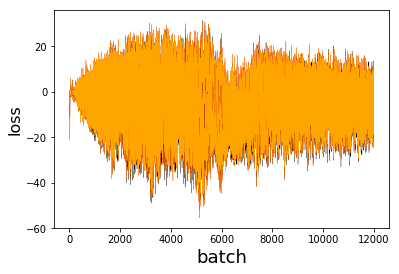

In [13]:
fig = plt.figure()
plt.plot([x[0] for x in gan.critic_valid_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.critic_valid_losses], color='green', linewidth=0.25)
plt.plot([x[0] for x in gan.critic_generated_losses], color='red', linewidth=0.25)
plt.plot(gan.generator_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [14]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [15]:

r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [16]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
gen_imgs = gan.generator_model.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()